In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import random

# print directory
import os
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())

from src.models.sparse_autoencoder import *
from src.visualization.plotting import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/home/dbm829/projects/interpreting_omics_models/02_experiments/notebooks
/home/dbm829/projects/interpreting_omics_models


# Sim 1: Gene Regulatory Network

## setup

In [2]:
# setup:
# 3 genes, transcribed into mRNA and translated into proteins
# the randomness comes from 2 places:
# 1. sampling from a poisson distribution, indicating the level of transcription activity
# 2. sampling from bernoulli distributions for each gene, indicating whether the gene is even accessible or not

# set up experiment parameters
poisson_lambda = 2.0
p_bernoulli = torch.tensor([0.5, 0.1, 0.9])
gene_regulation = torch.tensor([
    [0., 1., 1., 0., 0.],
    [1., 1., 0., 1., 0.],
    [0., 0., 0., 1., 1.]
])

n_samples_validation = 2000
n_samples = 10000 + n_samples_validation
n_epochs = 20000

In [3]:
# init distributions

activity_distribution = torch.distributions.poisson.Poisson(torch.tensor([poisson_lambda]))
accessibility_distribution = torch.distributions.bernoulli.Bernoulli(p_bernoulli)

# sample from distributions to create mRNA counts
# get the activity score
activity_score = activity_distribution.sample((n_samples,))
# get the accessibility scores
accessibility_scores = accessibility_distribution.sample((n_samples,))
# get the mRNA counts
tf_scores = activity_score * accessibility_scores

# correct mRNA counts for gene regulation
# first, get the regulation scores
def get_regulation_scores(tf_scores, gene_regulation):
    # get the regulation scores
    return torch.matmul(tf_scores, gene_regulation)

rna_counts = get_regulation_scores(tf_scores, gene_regulation)

In [50]:
# save all the data for reproducibility

np.save("01_data/sim_rna_counts.npy", rna_counts.numpy())
np.save("01_data/sim_tf_scores.npy", tf_scores.numpy())
np.save("01_data/sim_activity_scores.npy", activity_score.numpy())
np.save("01_data/sim_accessibility_scores.npy", accessibility_scores.numpy())

In [5]:
print(f'RNA shape: {rna_counts.shape}')
print(f'activity score shape: {activity_score.shape}') # one per sample
print(f'accessibility score shape: {accessibility_scores.shape}') # one per originating gene

RNA shape: torch.Size([12000, 5])
activity score shape: torch.Size([12000, 1])
accessibility score shape: torch.Size([12000, 3])


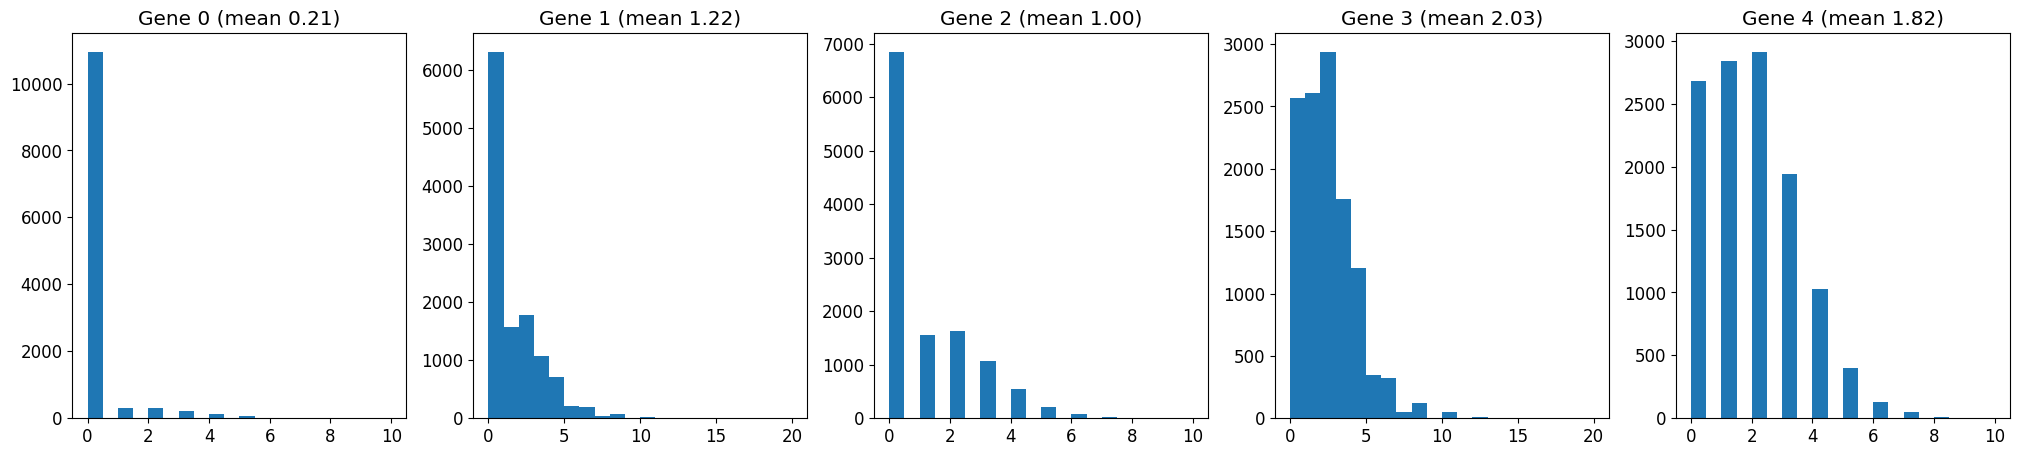

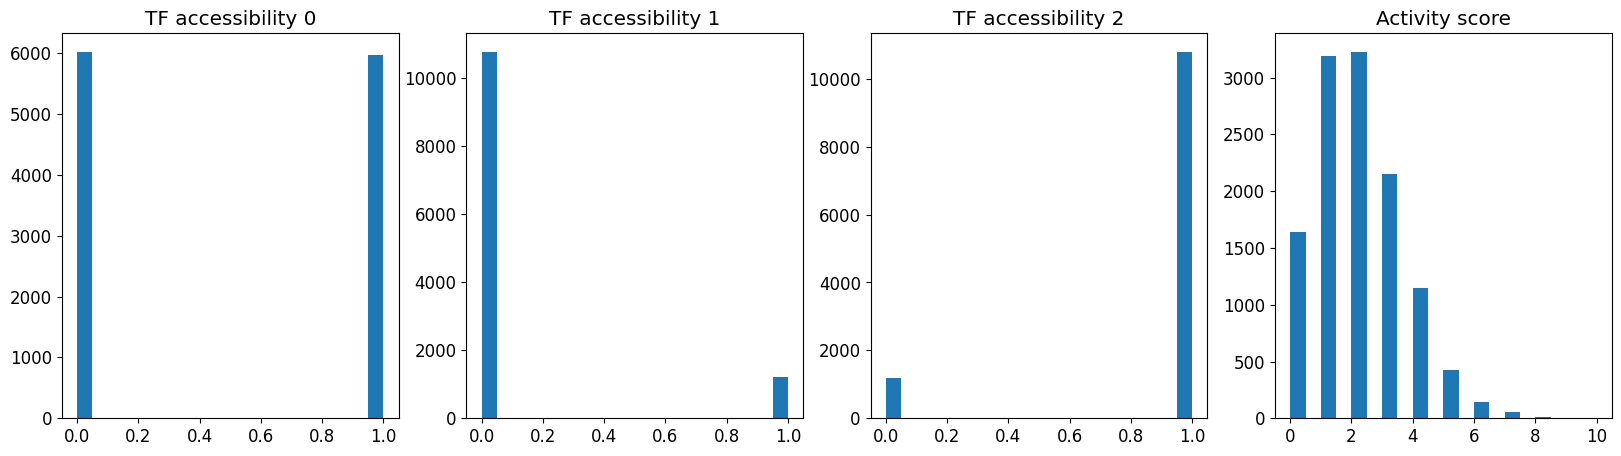

In [15]:
# make a figure with 5 suplots and plot histograms of each "gene's mRNA counts"

n_cols = 5

fig, axs = plt.subplots(1, n_cols, figsize=(n_cols*5, 5))
for i in range(n_cols):
    axs[i].hist(rna_counts[:, i].numpy(), bins=20)
    axs[i].set_title(f'Gene {i} (mean {rna_counts[:, i].mean().item():.2f})')
plt.show()

# same for TF's + activity scores
n_cols = 4

fig, axs = plt.subplots(1, n_cols, figsize=(n_cols*5, 5))
for i in range(n_cols-1):
    axs[i].hist(accessibility_scores[:, i].numpy(), bins=20)
    axs[i].set_title(f'TF accessibility {i}')
axs[-1].hist(activity_score.numpy(), bins=20)
axs[-1].set_title('Activity score')
plt.show()

### functions

In [48]:
def train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, learning_rate=1e-4):
    # loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')

    # optimizer
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    # train
    train_loss = []
    val_loss = []

    for e in range(n_epochs):
        # train
        # forward pass
        encoded = encoder(rna_counts[:(n_samples-n_samples_validation)])
        decoded = decoder(encoded)

        # compute loss
        loss = loss_fn(decoded, rna_counts[:(n_samples-n_samples_validation)])
        train_loss.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()

        # validation
        # forward pass
        encoded = encoder(rna_counts[(n_samples-n_samples_validation):])
        decoded = decoder(encoded)

        # compute loss
        loss = loss_fn(decoded, rna_counts[(n_samples-n_samples_validation):])
        val_loss.append(loss.item())
    
    # plot loss curves
    import matplotlib.pyplot as plt
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='validation')
    plt.legend()
    plt.show()

    # make scatter plots for each gene with output vs input
    # get the output
    encoded = encoder(rna_counts)
    decoded = decoder(encoded)
    # plot subplots
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        axs[i].scatter(rna_counts[:, i].detach().numpy(), decoded[:, i].detach().numpy(), s=1)
        axs[i].set_xlabel('input')
        axs[i].set_ylabel('output')
        axs[i].set_title('gene {}'.format(i))
    plt.show()

    # rank underlying features by their importance
    # first, get the weights of the encoder
    encoder_weights = encoder[0].weight.detach().t().numpy()
    # then, get the weights of the decoder
    decoder_weights = decoder[-2].weight.detach().t().numpy()
    # multiply them together
    weights = np.matmul(encoder_weights, decoder_weights)
    # get the absolute values
    weights = np.abs(weights)
    # sum the weights for each gene
    weights = np.sum(weights, axis=1)
    # sort the weights
    #weights = np.argsort(weights)

    # plot the weights
    plt.bar(np.arange(5), weights)
    plt.xlabel('gene')
    plt.ylabel('weight')
    plt.title('gene importance')
    plt.show()

    return encoder, decoder

three_cols = ["#60276F", "#1663A5", "#53787B"]
fontsize = 12

def plot_neuron_layer(activations, corr_threshold=0.9, name=''):
    # make the font size smaller
    plt.rcParams.update({'font.size': fontsize})
    if activations.shape[1] > 10:
        # look for neurons that correlate strongly with a gene
        # first, get the correlations
        for i in range(activations.shape[1]):
            for j in range(tf_scores.shape[1]):
                corr = np.corrcoef(activations[:, i].detach().numpy(), tf_scores[:, j].detach().numpy())[0, 1]
                if corr > corr_threshold:
                    # plot the neuron
                    plt.scatter(activations[:, i].detach().numpy(), tf_scores[:, j].detach().numpy())
                    plt.xlabel('neuron {}'.format(i))
                    plt.ylabel('tf_score {}'.format(j))
                    plt.title('correlation: {}'.format(corr))
                    plt.legend().remove()
                    plt.show()
    else:
        # now plot each activation against each tf_score
        fig, axs = plt.subplots(activations.shape[1], 3, figsize=(9, 3*activations.shape[1]))
        for i in range(activations.shape[1]):
            for j in range(3):
                # make a dataframe
                df = pd.DataFrame({'neuron': activations[:, i].detach().numpy(), 'tf_score': tf_scores[:, j].detach().numpy(), 'activity': activity_score.flatten().detach().numpy()})
                sns.scatterplot(x='neuron', y='tf_score', hue='activity', data=df, ax=axs[i, j])
                axs[i, j].set_xlabel('neuron {}'.format(i))
                axs[i, j].set_ylabel('tf_score {}'.format(j))
                axs[i, j].legend().remove()
        plt.show()

    # for tf_score 0, fit a linear regression model to the activations
    from sklearn.linear_model import LinearRegression

    fig, axs = plt.subplots(1, tf_scores.shape[1], figsize=(10, 3))
    # add spacing
    fig.subplots_adjust(wspace=0.5)
    for i in range(tf_scores.shape[1]):
        reg = LinearRegression().fit(activations.detach().numpy(), tf_scores[:, i].detach().numpy())
        print(reg.score(activations.detach().numpy(), tf_scores[:, i].detach().numpy()))
        # use these coefficients to plot the activations against the tf_scores
        superposition = np.matmul(activations.detach().numpy(), reg.coef_.T)
        # now plot the tf_score against the superposition
        axs[i].scatter(superposition, tf_scores[:, i].detach().numpy(), c=three_cols[i])
        axs[i].set_xlabel('superposition')
        axs[i].set_ylabel('TF score {}'.format(i))
        # the title should be the coefficients
        axs[i].set_title('coefficients: {}'.format(np.round(reg.coef_,2)), fontsize=fontsize-2)
    # save as pdf
    plt.savefig('tf_score_superposition'+name+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    # also find the superposition for the activity score
    reg = LinearRegression().fit(activations.detach().numpy(), activity_score.flatten().detach().numpy())
    print(reg.score(activations.detach().numpy(), activity_score.flatten().detach().numpy()))
    # use these coefficients to plot the activations against the tf_scores
    superposition = np.matmul(activations.detach().numpy(), reg.coef_.T)
    # now plot the tf_score against the superposition
    fig, axs = plt.subplots(1, 1, figsize=(3, 3))
    plt.scatter(superposition, activity_score.flatten().detach().numpy(), c='black')
    plt.xlabel('superposition')
    plt.ylabel('activity_score')
    # the title should be the coefficients
    plt.title('coefficients: {}'.format(np.round(reg.coef_,2)), fontsize=fontsize)
    # save as pdf
    plt.savefig('activity_score_superposition'+name+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    # make one plot showing a pca with the coefficient vectors for each tf score
    fig, axs = plt.subplots(1, 1, figsize=(3, 3))
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(activations.detach().numpy())
    # get the coefficients
    coefficients = []
    for i in range(tf_scores.shape[1]):
        reg = LinearRegression().fit(activations.detach().numpy(), tf_scores[:, i].detach().numpy())
        coefficients.append(reg.coef_)
    # add the activity score coefficients
    reg = LinearRegression().fit(activations.detach().numpy(), activity_score.flatten().detach().numpy())
    coefficients.append(reg.coef_)
    coefficients = np.array(coefficients)
    # transform the coefficients
    coefficients = pca.transform(coefficients)
    # plot the coefficients
    plt.scatter(coefficients[:, 0], coefficients[:, 1], s=1)
    # label the coefficients
    #for i in range(coefficients.shape[0]):
    #    plt.annotate('TF score {}'.format(i), (coefficients[i, 0]+0.05, coefficients[i, 1]*1.1))
    # plot arrows from the origin to the coefficients
    mean = pca.transform(pca.mean_.reshape(1, -1))
    for i in range(coefficients.shape[0]):
        if i == coefficients.shape[0]-1:
            plt.arrow(mean[0][0], mean[0][1], coefficients[i, 0], coefficients[i, 1], head_width=0.05, head_length=0.1, fc='black', ec='black')
        else:
            plt.arrow(mean[0][0], mean[0][1], coefficients[i, 0], coefficients[i, 1], head_width=0.05, head_length=0.1, fc=three_cols[i], ec=three_cols[i])
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('TF score coefficients', fontsize=fontsize)
    # save as pdf
    plt.savefig('tf_score_coefficients'+name+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    # do the same for the activity score and the accessibility scores
    if activations.shape[1] > 10:
        # look for neurons that correlate strongly with a gene
        # first, get the correlations
        for i in range(activations.shape[1]):
            for j in range(accessibility_scores.shape[1]):
                corr = np.corrcoef(activations[:, i].detach().numpy(), accessibility_scores[:, j].detach().numpy())[0, 1]
                if corr > corr_threshold:
                    # plot the neuron
                    plt.scatter(activations[:, i].detach().numpy(), accessibility_scores[:, j].detach().numpy())
                    plt.xlabel('neuron {}'.format(i))
                    plt.ylabel('accessibility_score {}'.format(j))
                    plt.title('correlation: {}'.format(corr))
                    plt.legend().remove()
                    plt.show()
    else:
        fig, axs = plt.subplots(activations.shape[1], accessibility_scores.shape[1], figsize=(9, 3*activations.shape[1]))
        for i in range(activations.shape[1]):
            for j in range(accessibility_scores.shape[1]):
                # make a dataframe
                df = pd.DataFrame({'neuron': activations[:, i].detach().numpy(), 'accessibility_score': accessibility_scores[:, j].detach().numpy(), 'activity': activity_score.flatten().detach().numpy()})
                sns.scatterplot(x='neuron', y='accessibility_score', hue='activity', data=df, ax=axs[i, j])
                axs[i, j].set_xlabel('neuron {}'.format(i))
                axs[i, j].set_ylabel('accessibility_score {}'.format(j))
                axs[i, j].legend().remove()
        plt.show()
    fig, axs = plt.subplots(1, accessibility_scores.shape[1], figsize=(9, 3))
    for i in range(accessibility_scores.shape[1]):
        reg = LinearRegression().fit(activations.detach().numpy(), accessibility_scores[:, i].detach().numpy())
        # use these coefficients to plot the activations against the tf_scores
        superposition = np.matmul(activations.detach().numpy(), reg.coef_.T)
        # now plot the tf_score against the superposition
        axs[i].scatter(superposition, accessibility_scores[:, i].detach().numpy())
        axs[i].set_xlabel('superposition')
        axs[i].set_ylabel('accessibility_score {}'.format(i))
        # the title should be the coefficients
        axs[i].set_title('coefficients: {}'.format(reg.coef_))
    plt.show()

    fig, axs = plt.subplots(1, activations.shape[1], figsize=(activations.shape[1]*3, 3))
    for i in range(activations.shape[1]):
        # make a dataframe
        axs[i].scatter(activations[:, i].detach().numpy(), activity_score.flatten().detach().numpy())
        axs[i].set_xlabel('neuron {}'.format(i))
        axs[i].set_ylabel('activity_score')
    plt.show()
    reg = LinearRegression().fit(activations.detach().numpy(), activity_score.flatten().detach().numpy())
    # use these coefficients to plot the activations against the tf_scores
    superposition = np.matmul(activations.detach().numpy(), reg.coef_.T)
    # now plot the tf_score against the superposition
    plt.scatter(superposition, activity_score.flatten().detach().numpy())
    plt.xlabel('superposition')
    plt.ylabel('activity_score')
    # the title should be the coefficients
    plt.title('coefficients: {}'.format(reg.coef_))
    plt.show()

## Exp1: Superpositions depending on the bottleneck size (relative to causal variables) for single-layer networks

Here, the number of causal variables are 4: 3 TFs and the activity in the sample.

### overcomplete case

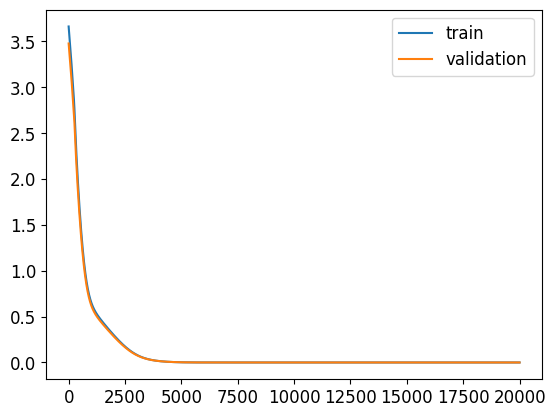

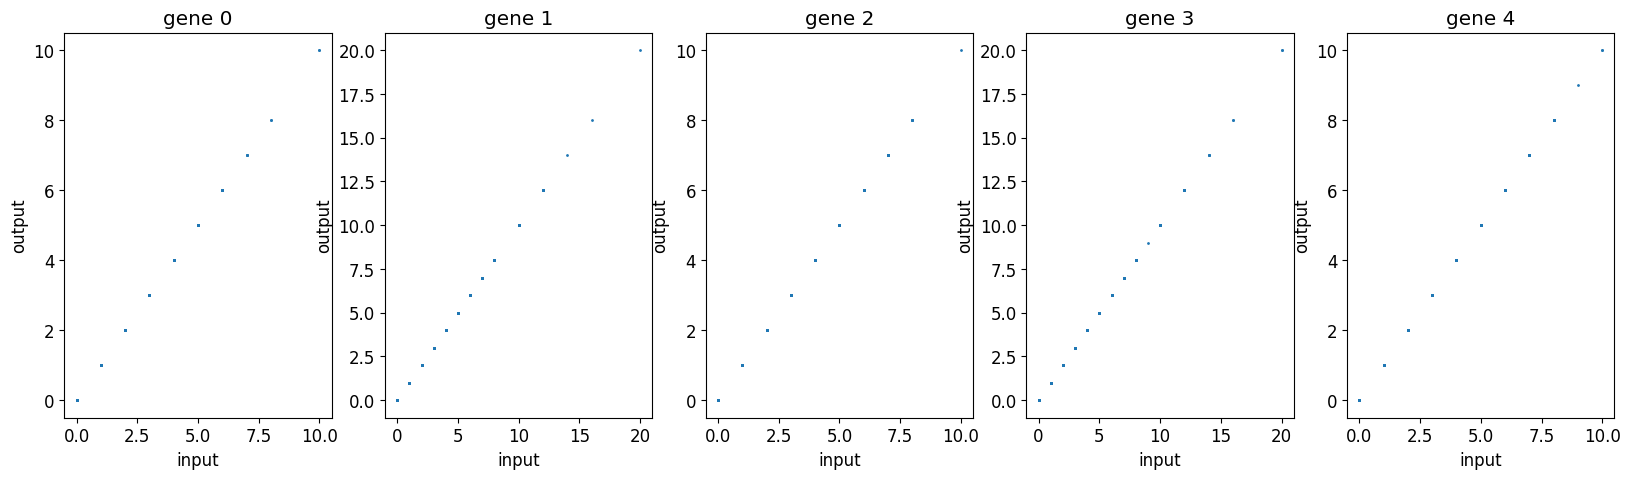

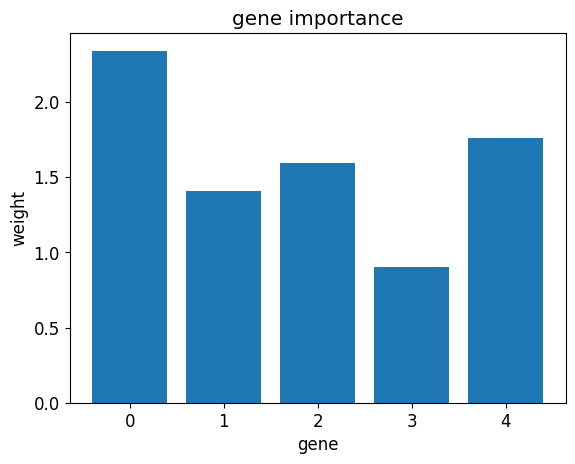

In [24]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(5, 10)
)
decoder = torch.nn.Sequential(
    torch.nn.Linear(10, 5),
    torch.nn.ReLU()
)

encoder, decoder = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation)

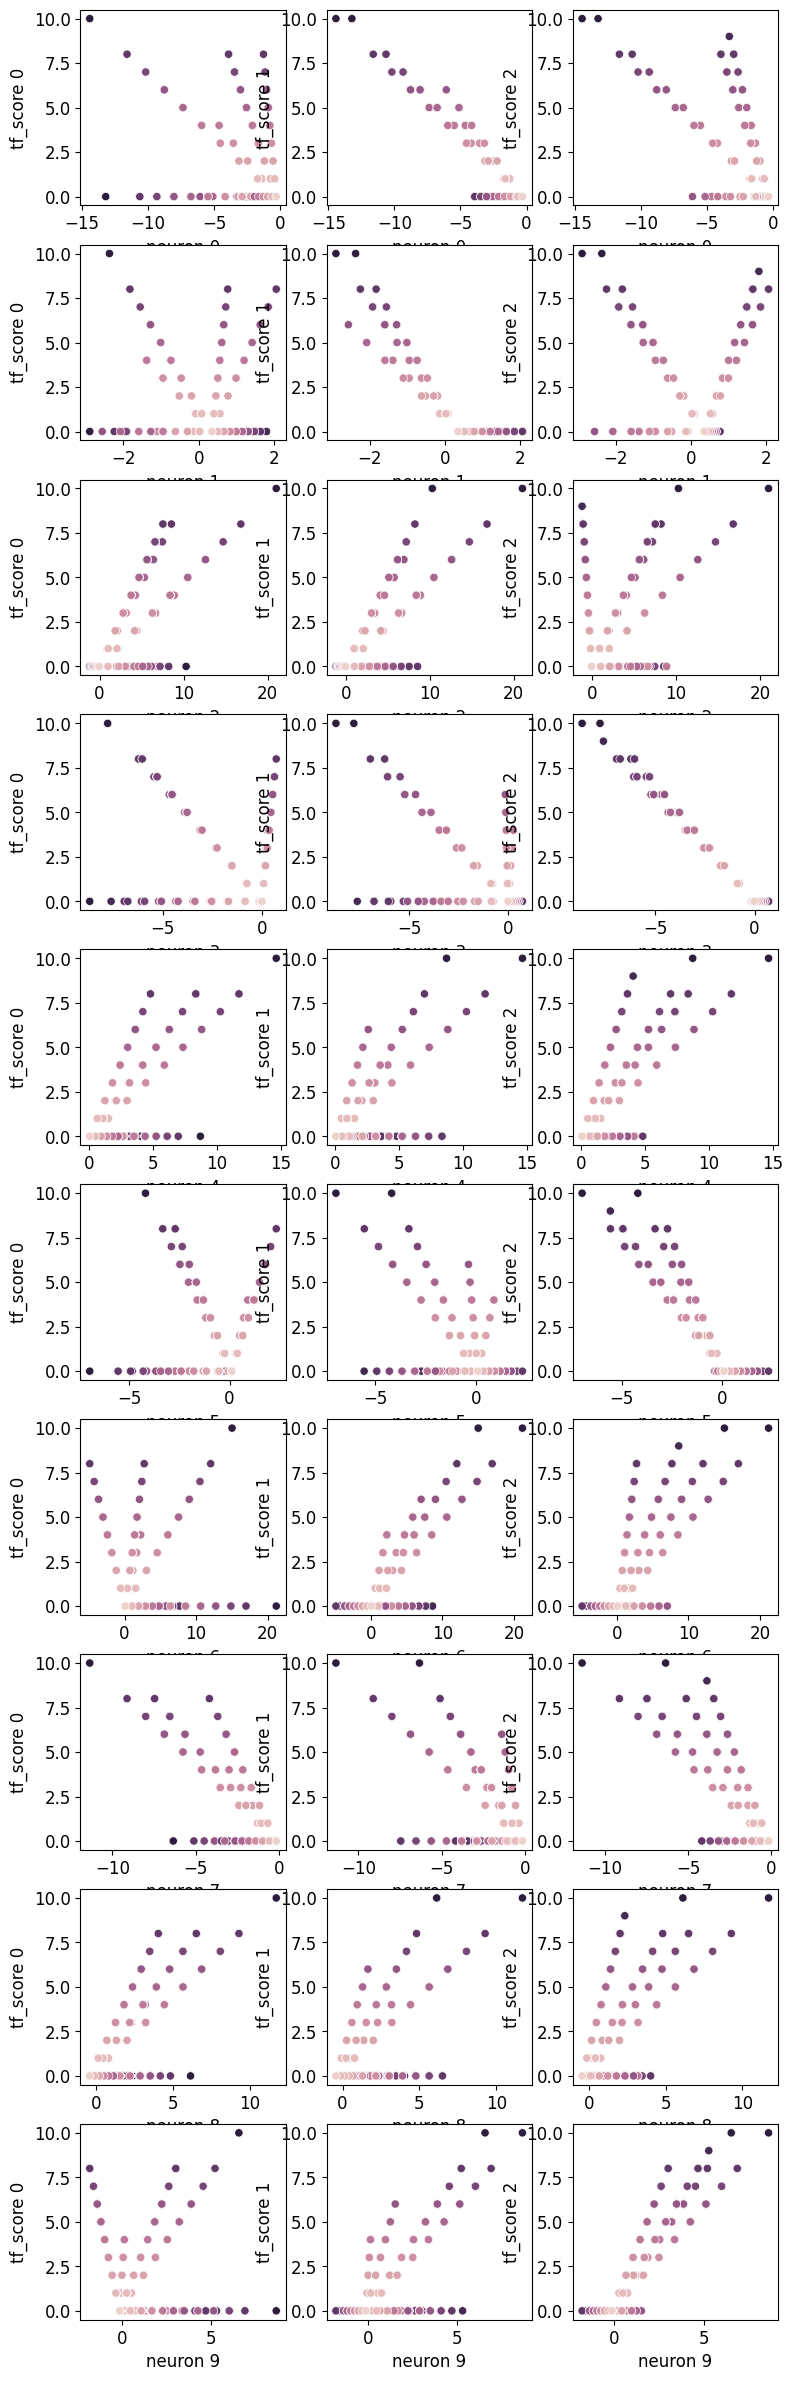

0.9999999999998881
0.9999999999984417
0.9999999999999282


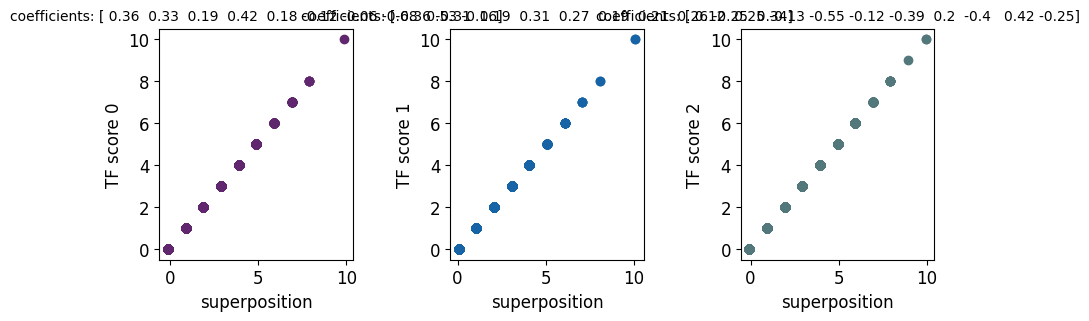

0.7797947835525716


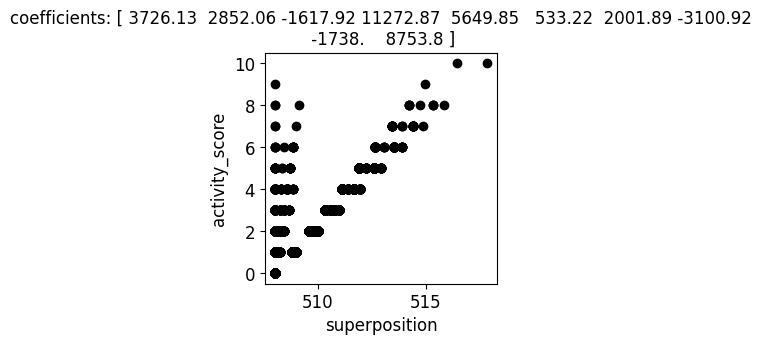

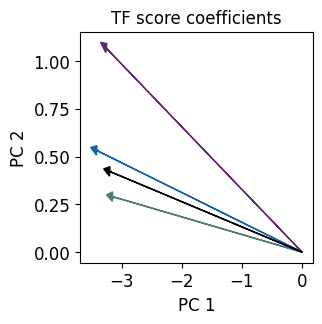

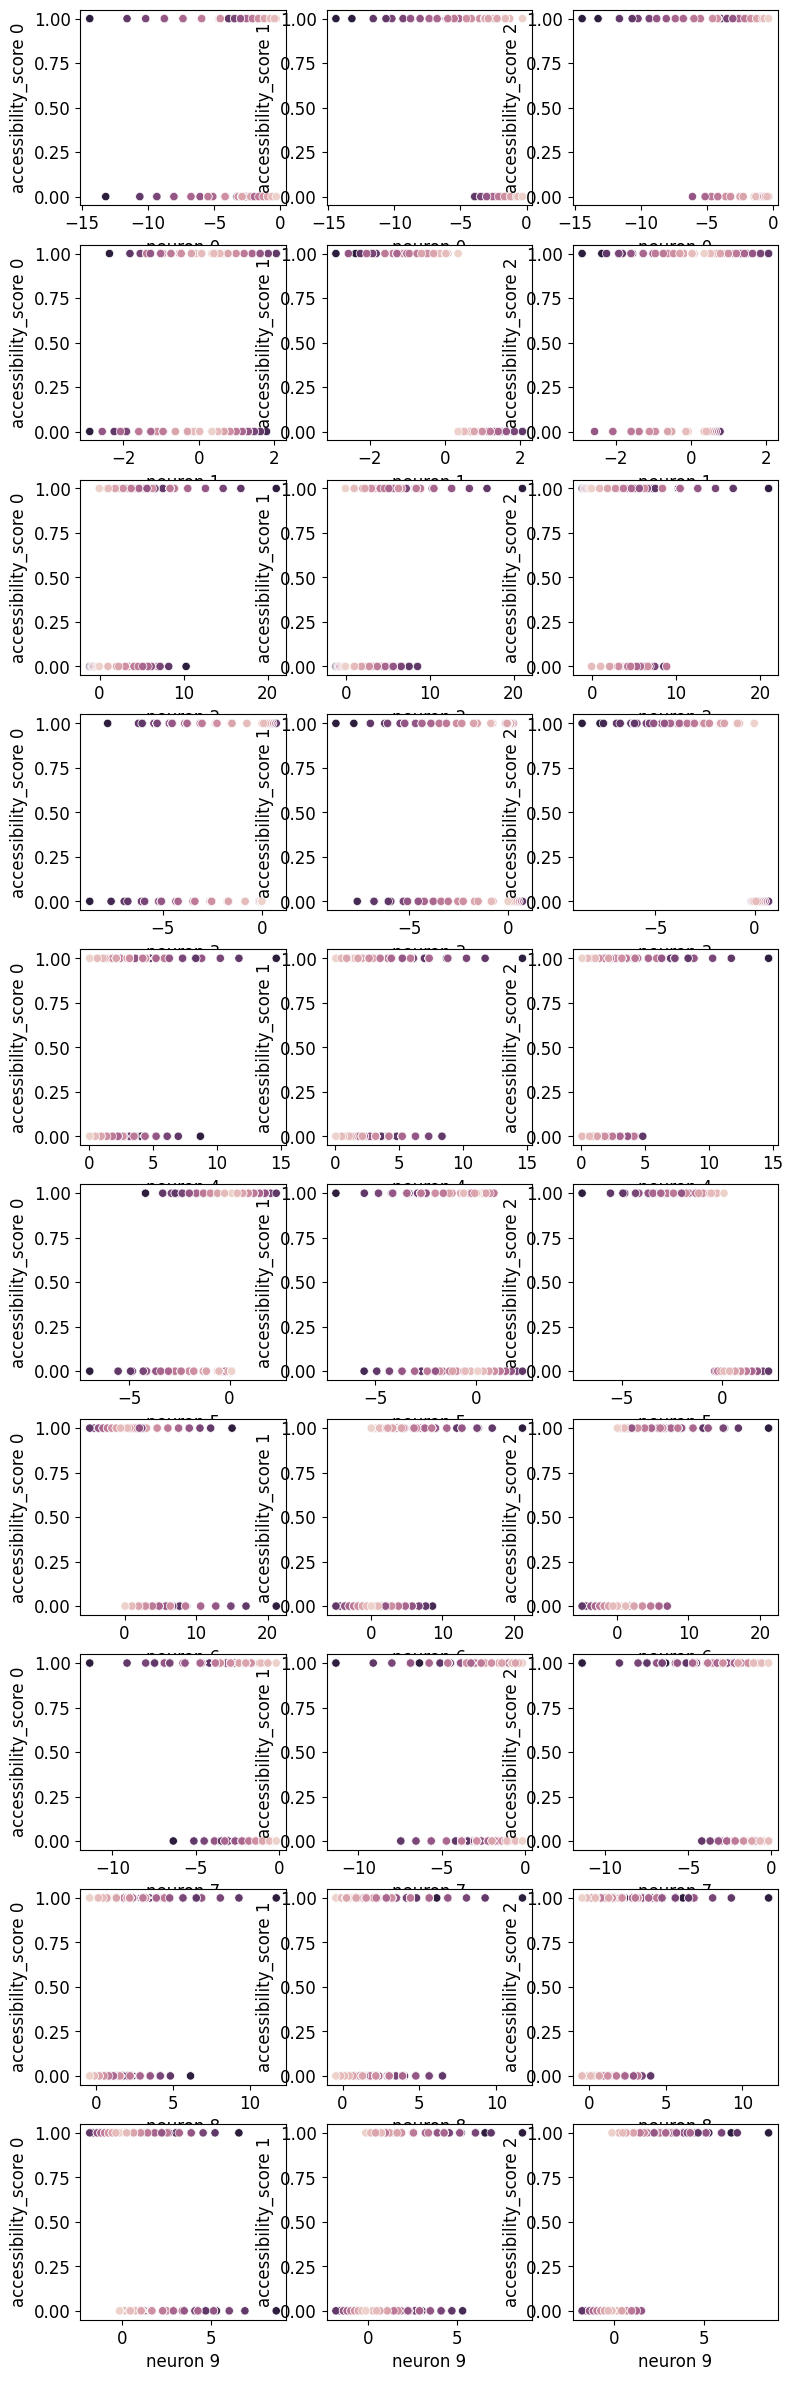

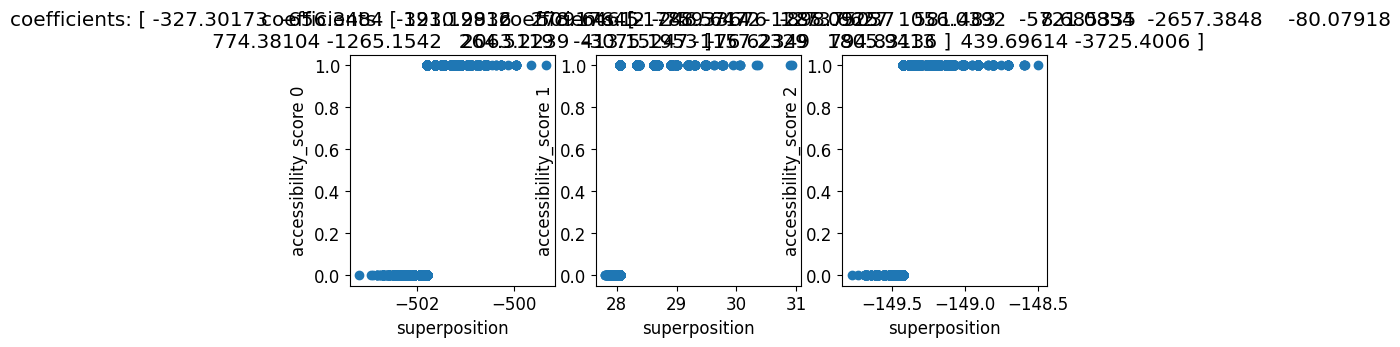

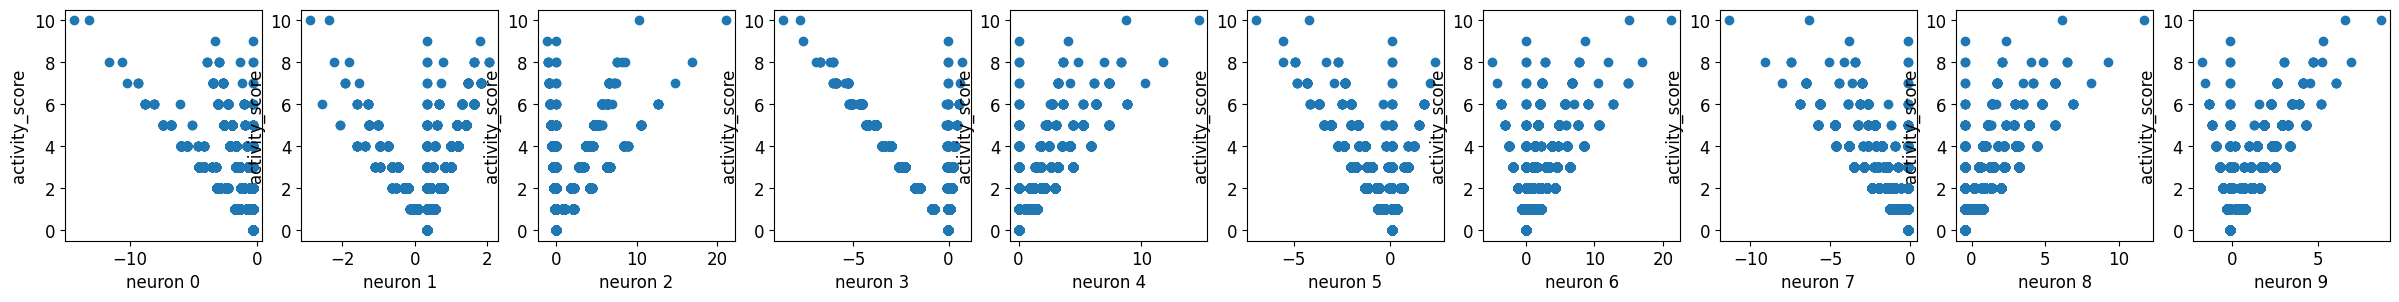

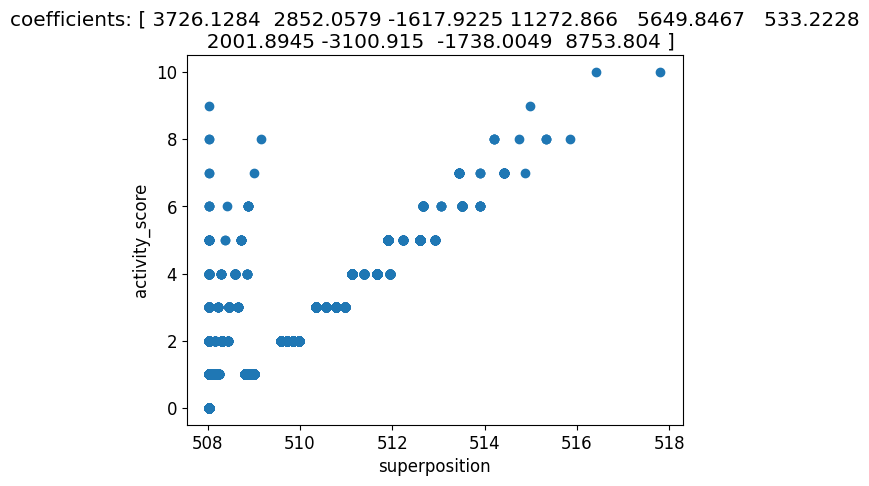

In [25]:
activations = encoder(rna_counts)

plot_neuron_layer(activations)

### ideal case

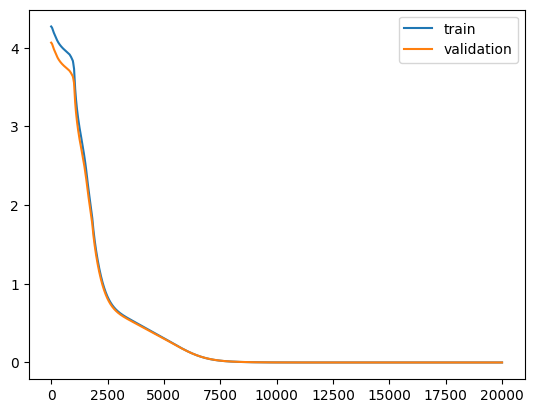

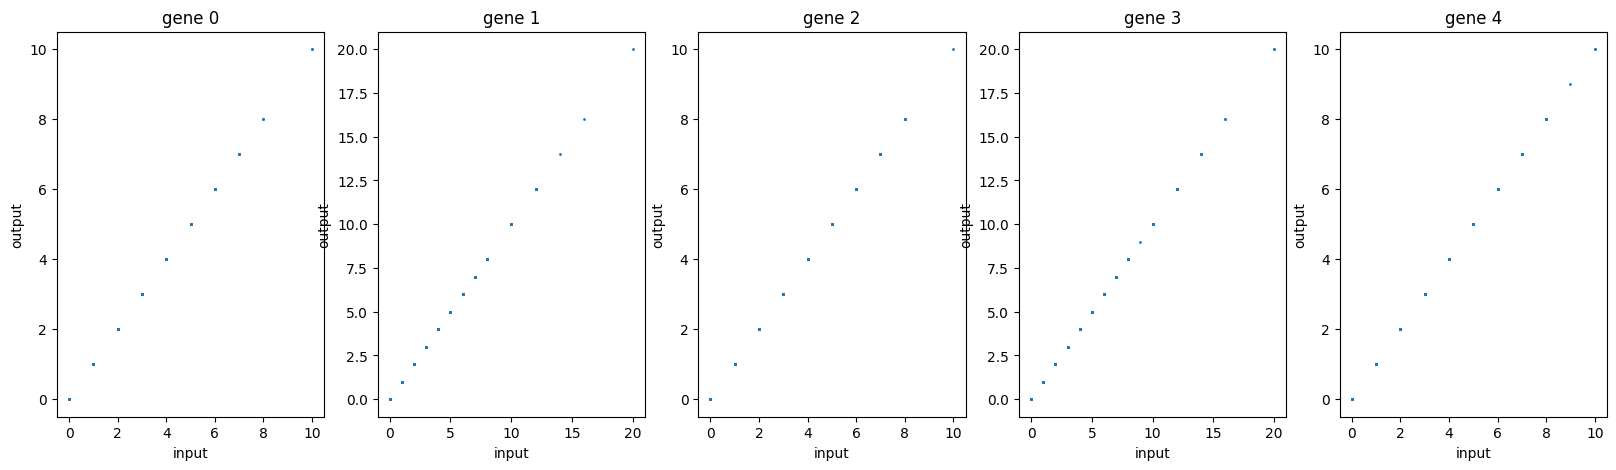

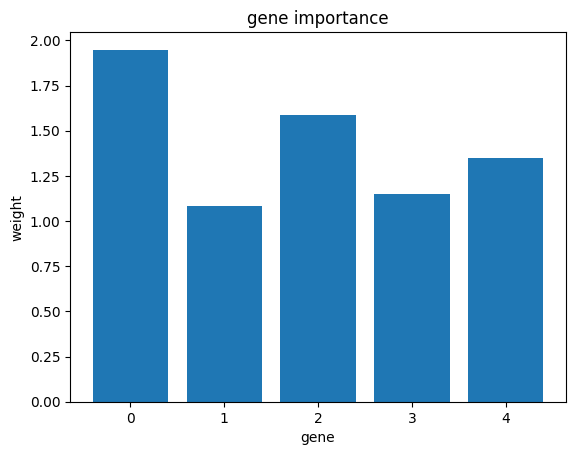

In [8]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(5, 4)
)
decoder = torch.nn.Sequential(
    torch.nn.Linear(4, 5),
    torch.nn.ReLU()
)

encoder, decoder = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation)

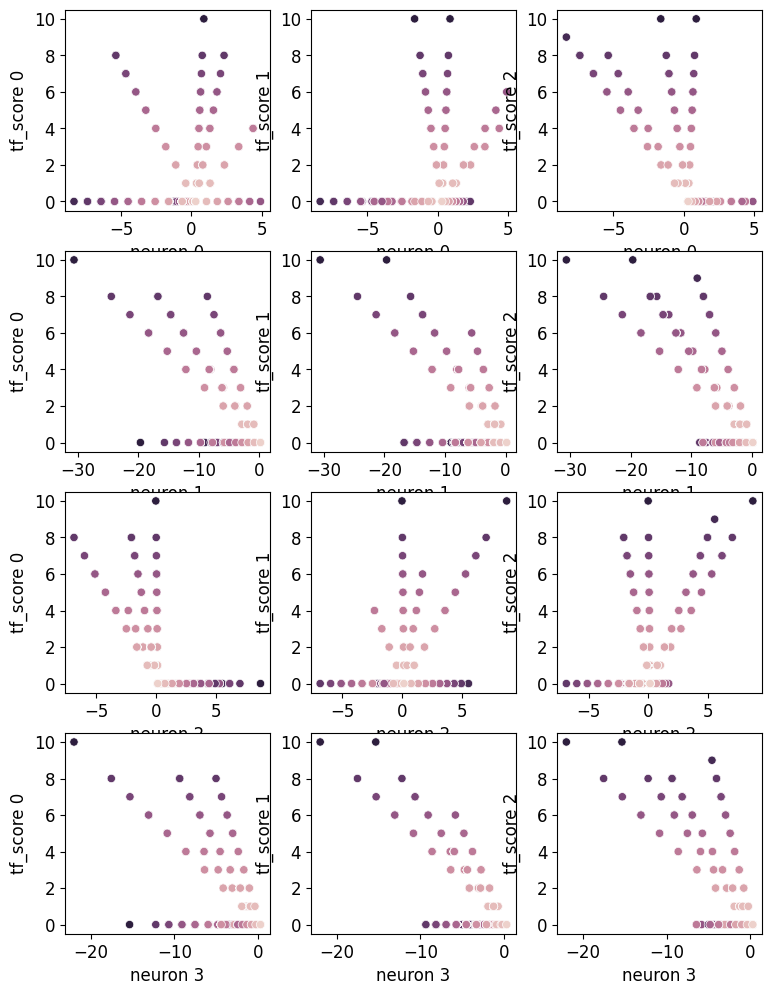

0.9999999999997186
0.9999999999994449
0.9999999999999467


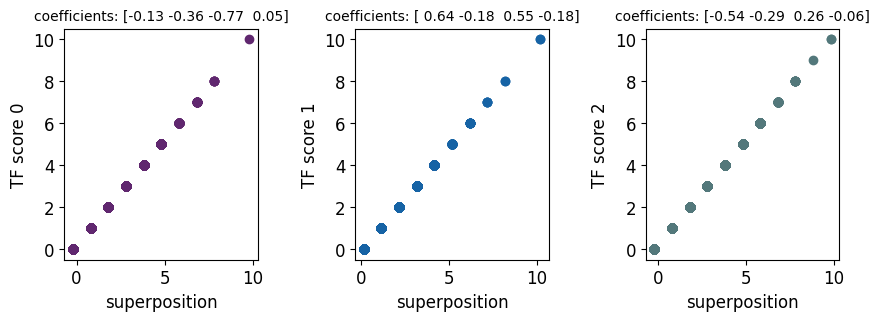

0.7797682147024828


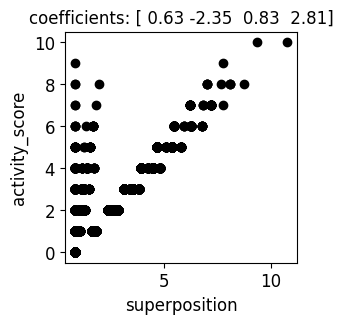

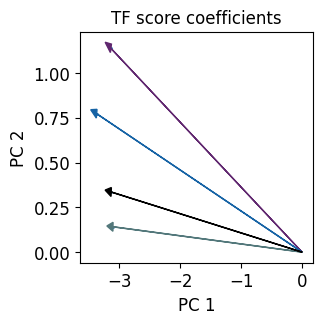

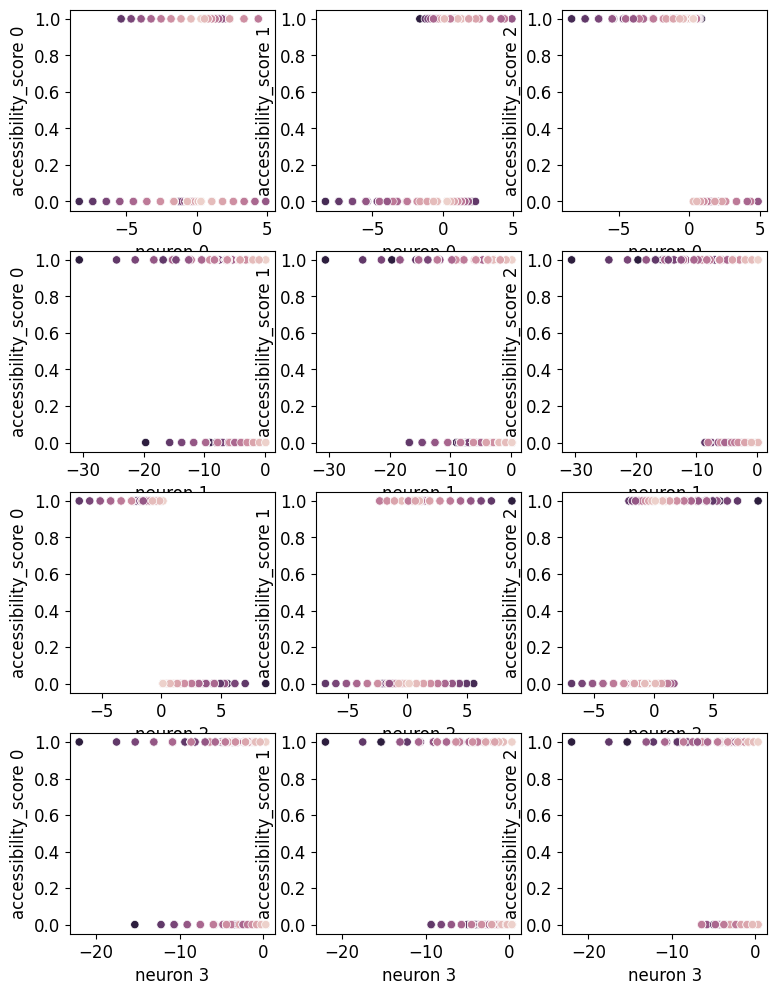

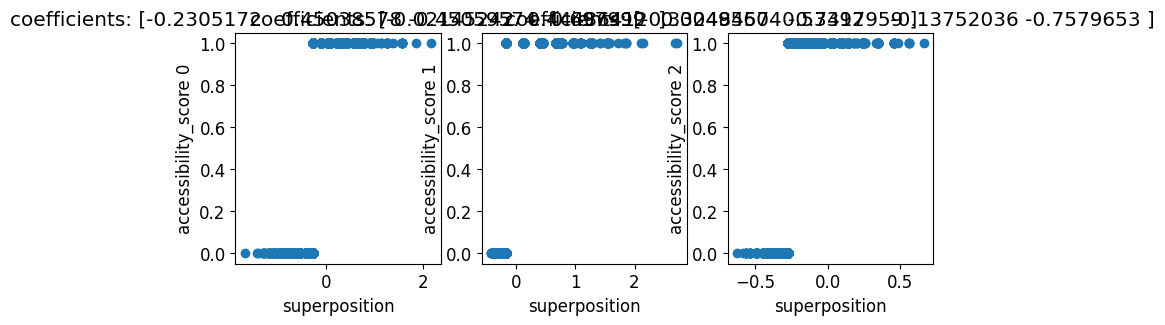

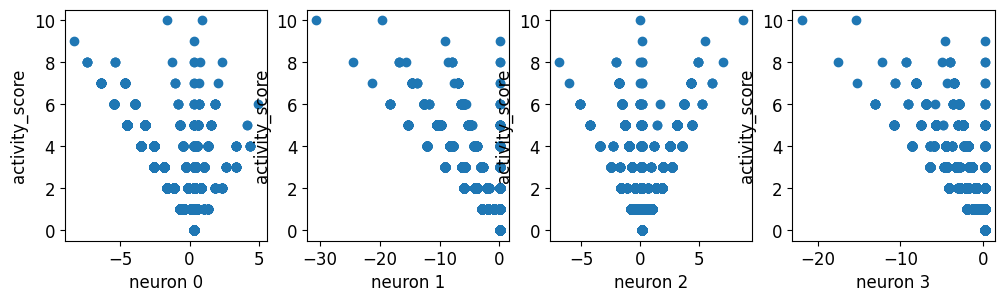

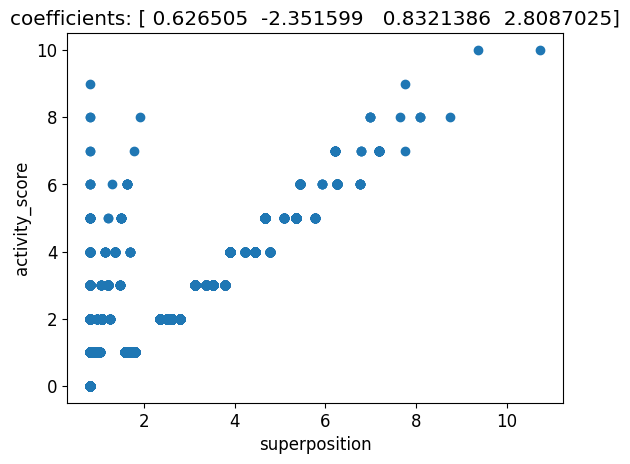

In [23]:
activations = encoder(rna_counts)

plot_neuron_layer(activations)

### bottleneck smaller than the number of causal variables

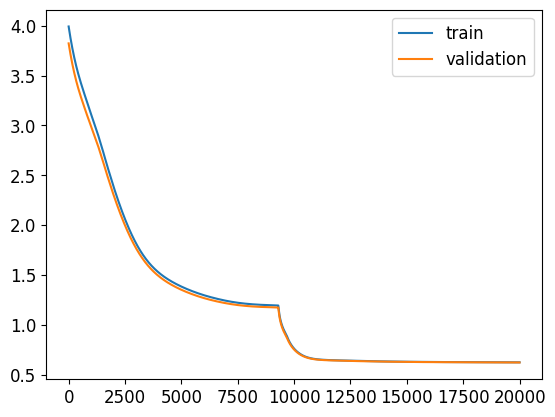

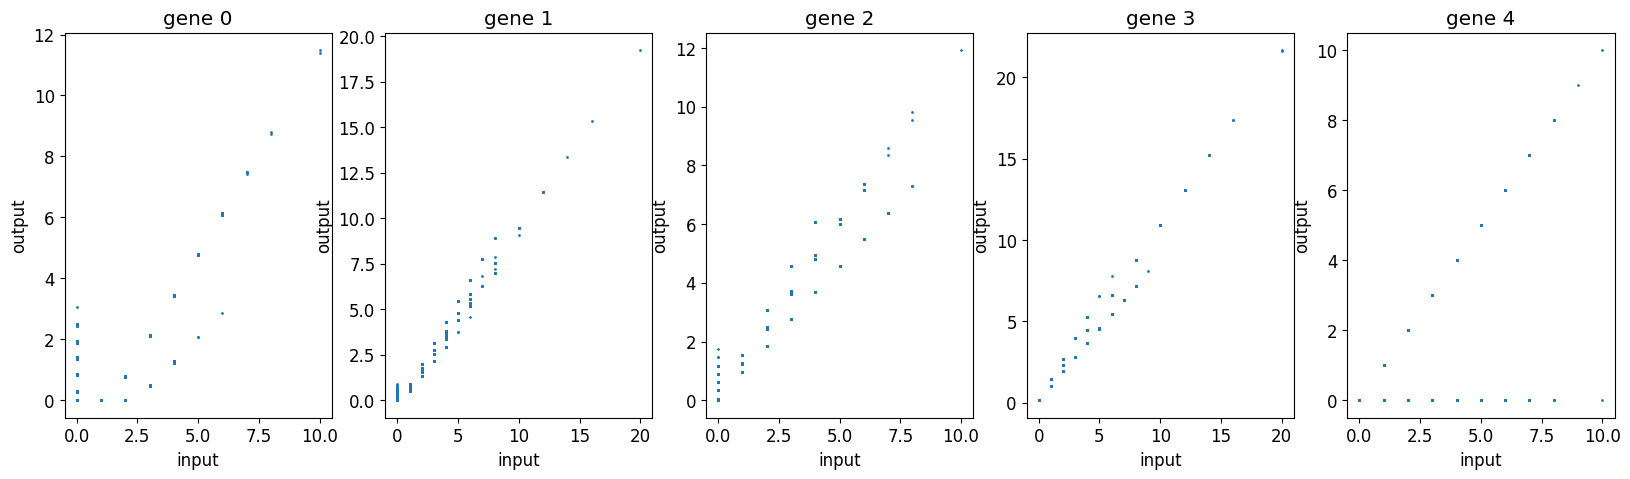

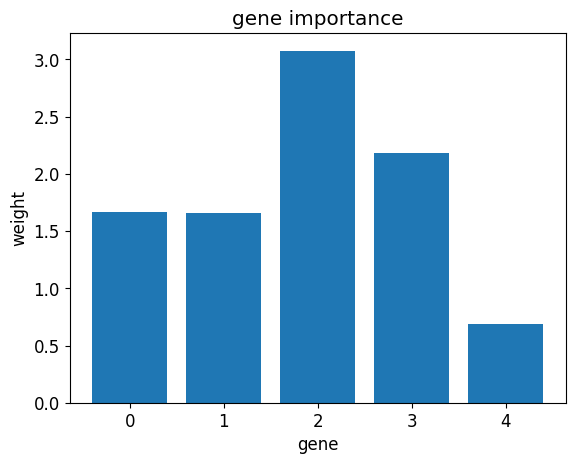

In [26]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(5, 2)
)
decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.ReLU()
)

encoder, decoder = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation)

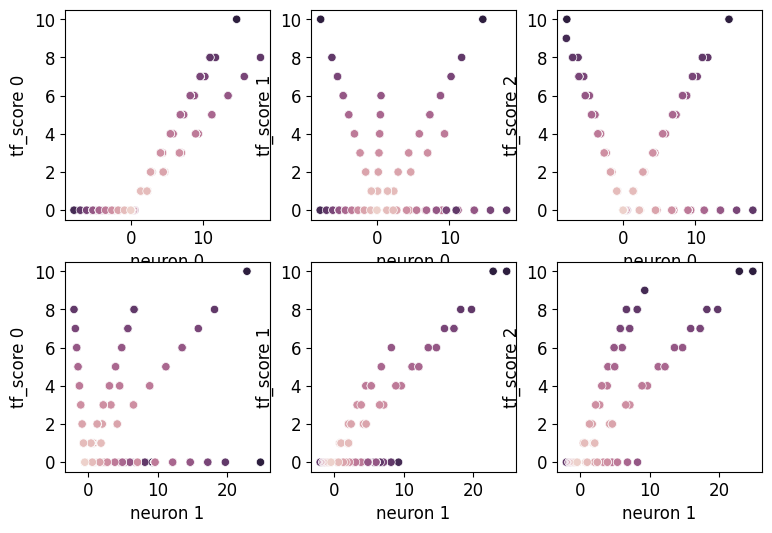

0.9428071209043121
0.48576776607306915
0.6990230704142808


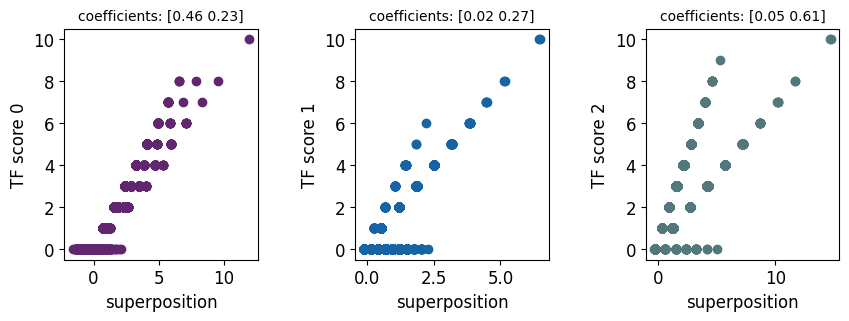

0.5855647290630274


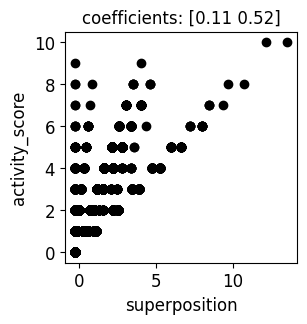

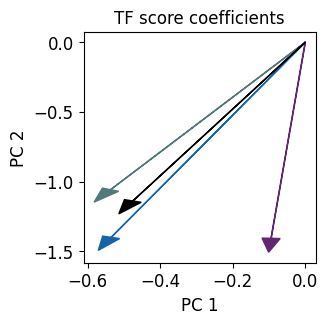

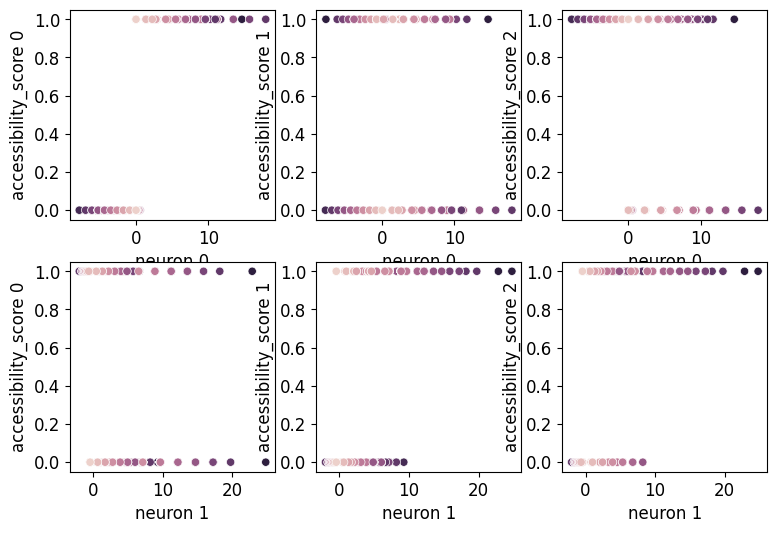

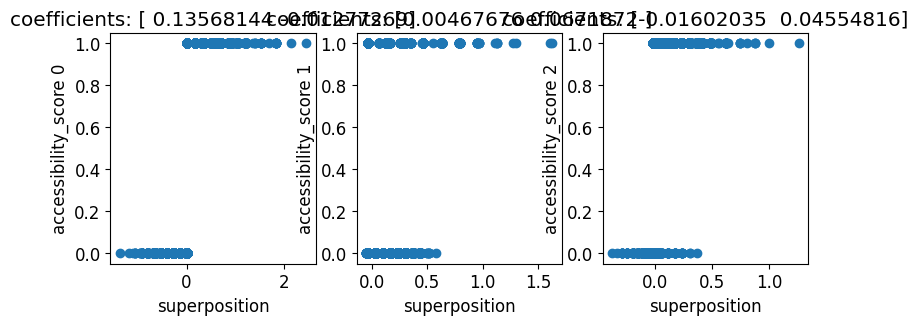

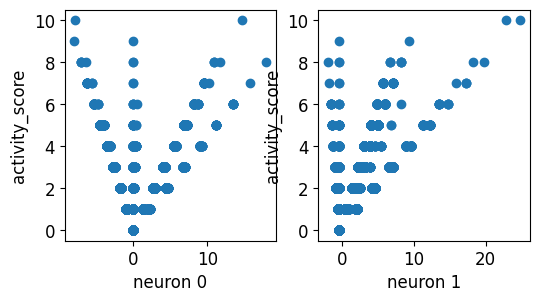

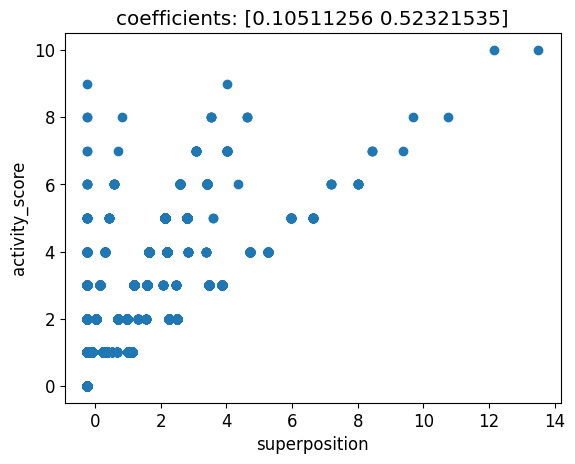

In [27]:
activations = encoder(rna_counts)

plot_neuron_layer(activations)

## Exp 2: 2 layers with nonlinearity

In [49]:
import torch.nn.init as init

def custom_weight_init(m, init_option='kaiming'):
    if isinstance(m, torch.nn.Linear):
        if init_option == 'xavier':
            init.xavier_uniform_(m.weight)
        elif init_option == 'uniform':
            init.uniform_(m.weight, -0.1, 0.1)
        elif init_option == 'normal':
            init.normal_(m.weight, 0, 0.1)
        elif init_option == 'kaiming_uniform':
            init.kaiming_uniform_(m.weight)
        else:
            init.kaiming_normal_(m.weight)
        
        if m.bias is not None:
            init.zeros_(m.bias)

### overcomplete case

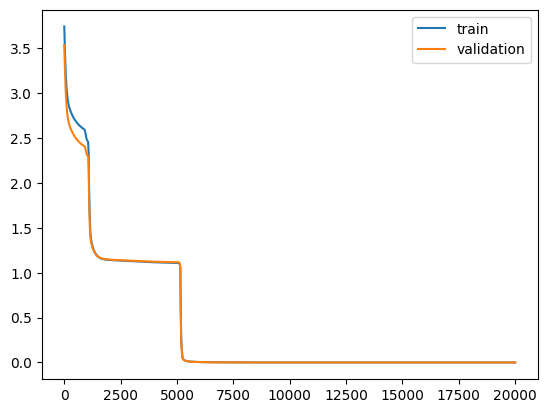

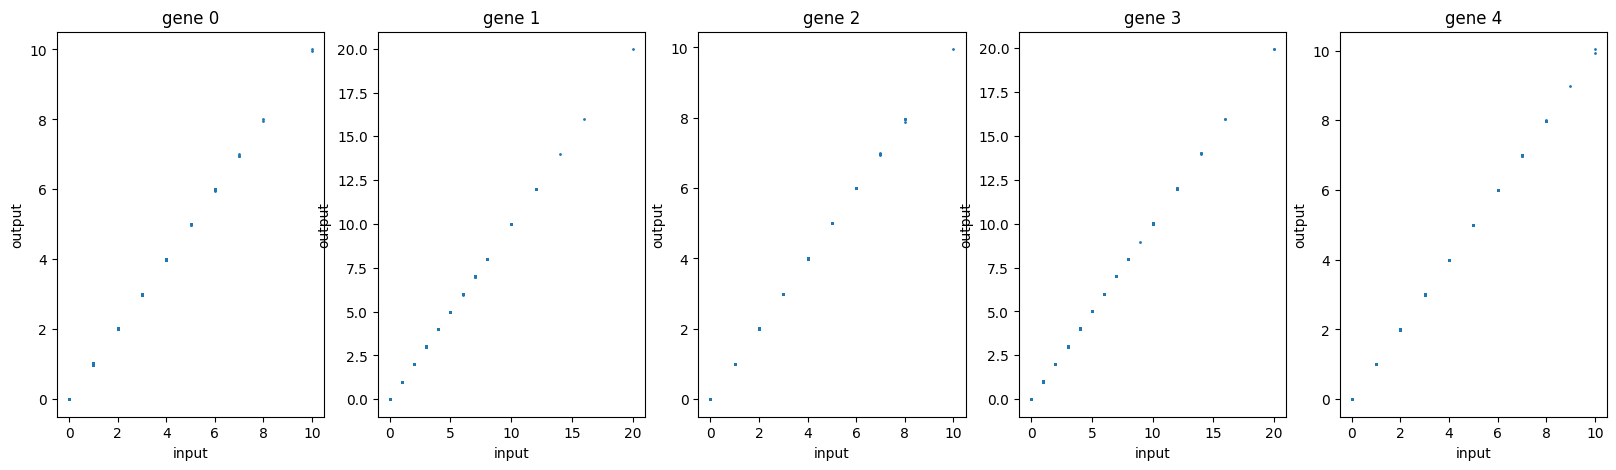

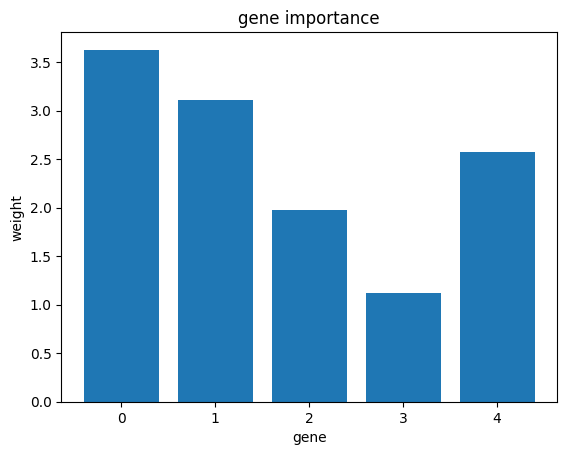

In [11]:
init_type = 'xavier'

encoder = torch.nn.Sequential(
    torch.nn.Linear(5, 10),
    torch.nn.SiLU(),
    torch.nn.Linear(10, 100),
)
encoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

decoder = torch.nn.Sequential(
    torch.nn.Linear(100, 10),
    torch.nn.SiLU(),
    torch.nn.Linear(10, 5),
    torch.nn.ReLU()
)
decoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

encoder, decoder = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation)

In [ ]:
activations = encoder(rna_counts)

plot_neuron_layer(activations)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


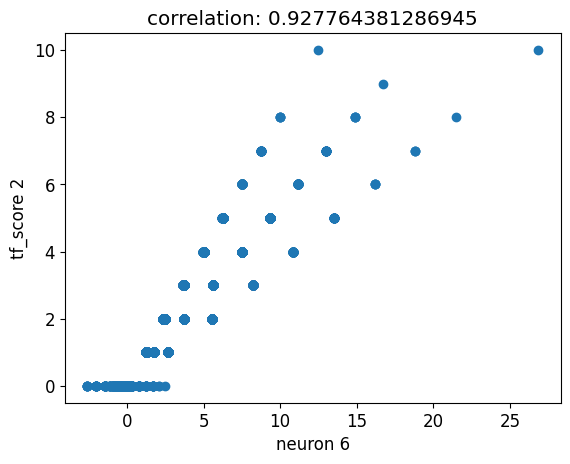

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


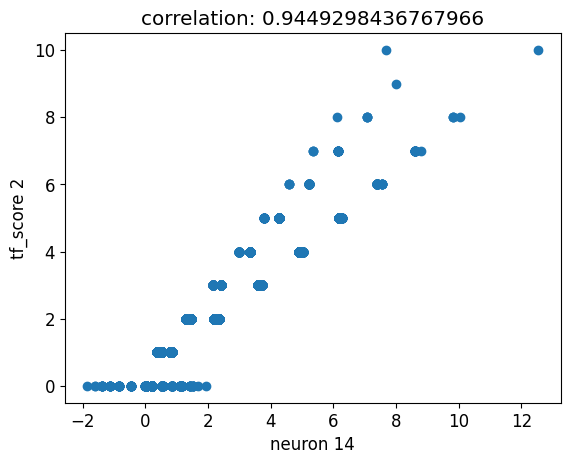

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


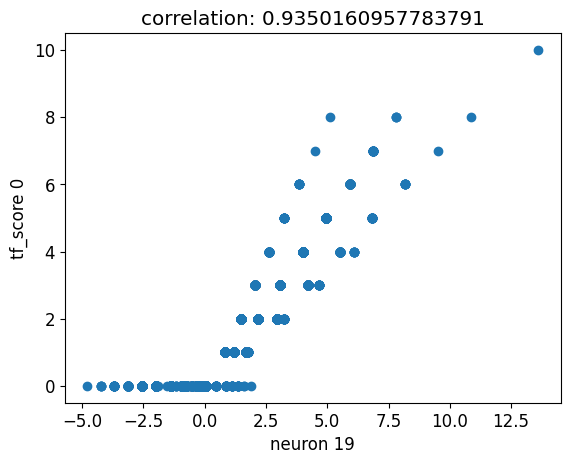

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


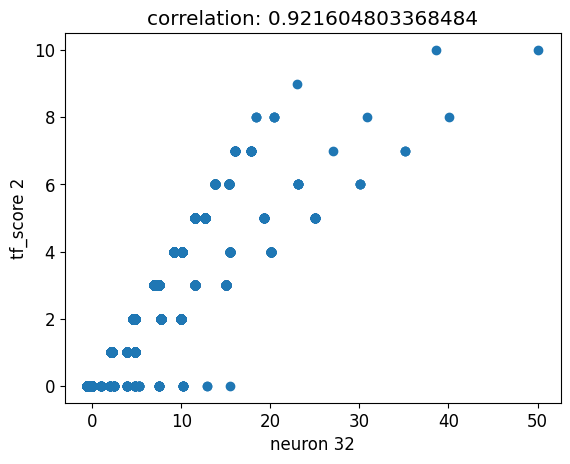

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


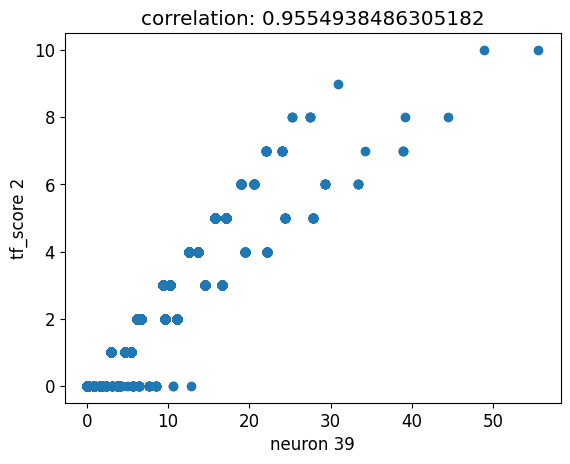

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


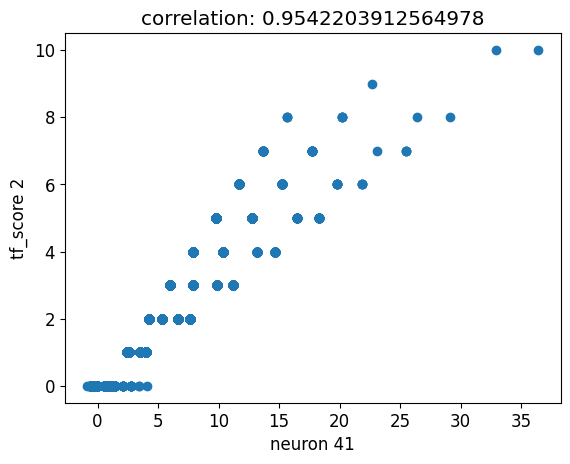

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


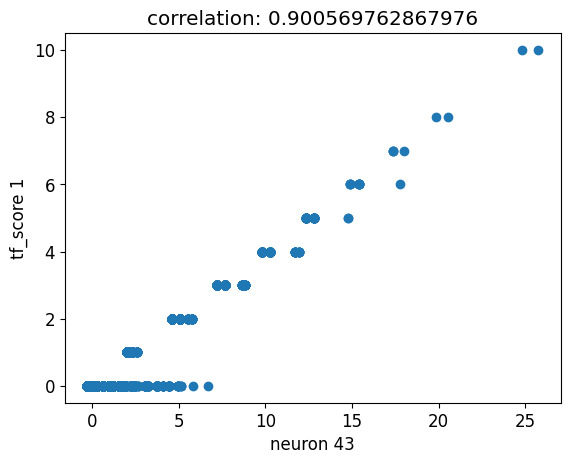

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


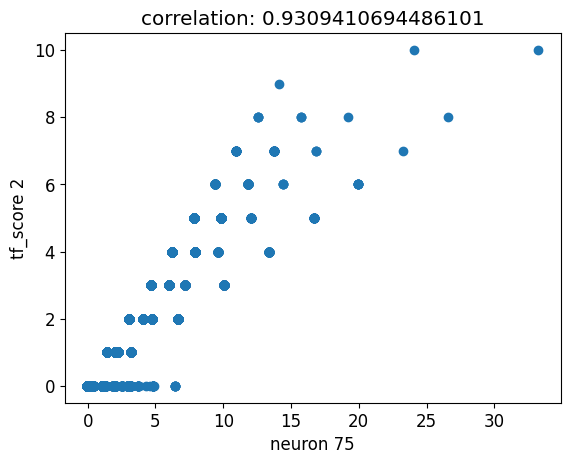

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


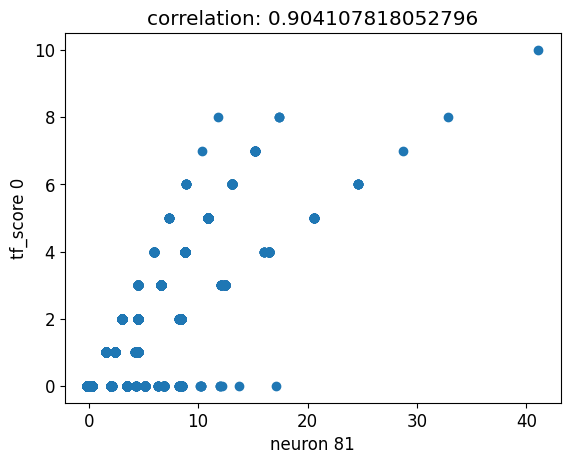

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


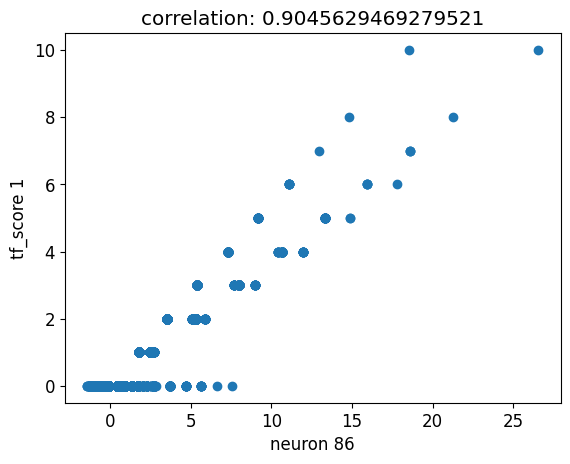

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


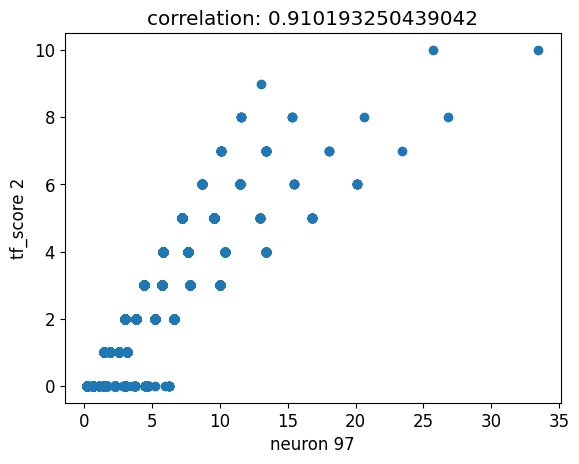

0.9995657173342729
0.9996714692100562
0.9999427740769644


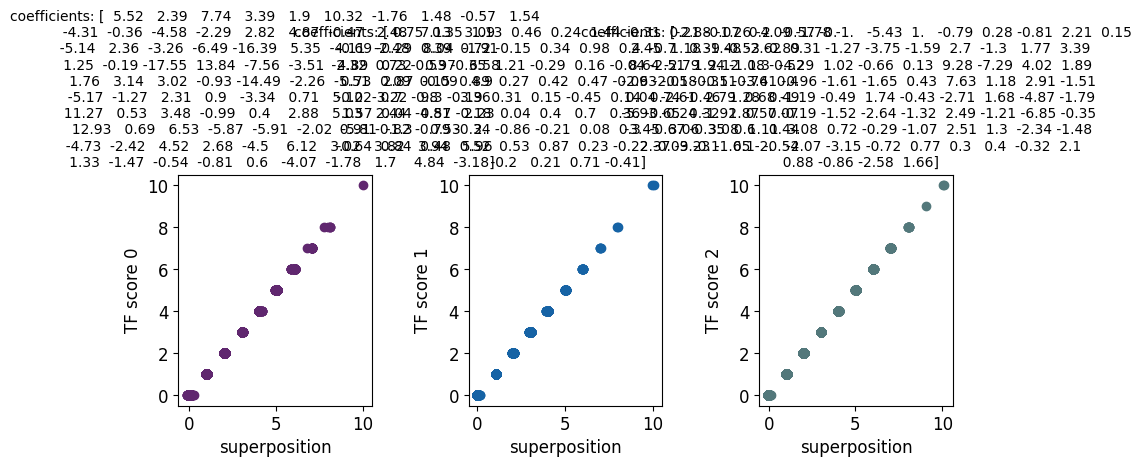

0.8864929269107845


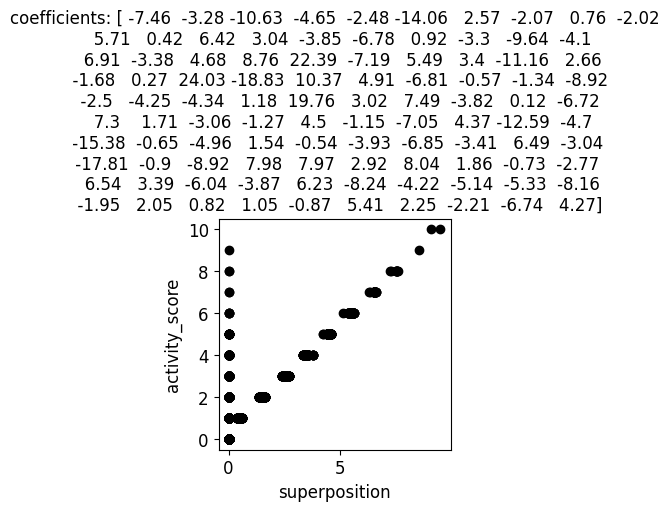

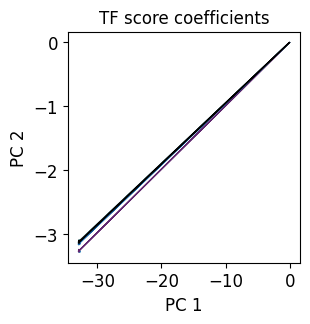

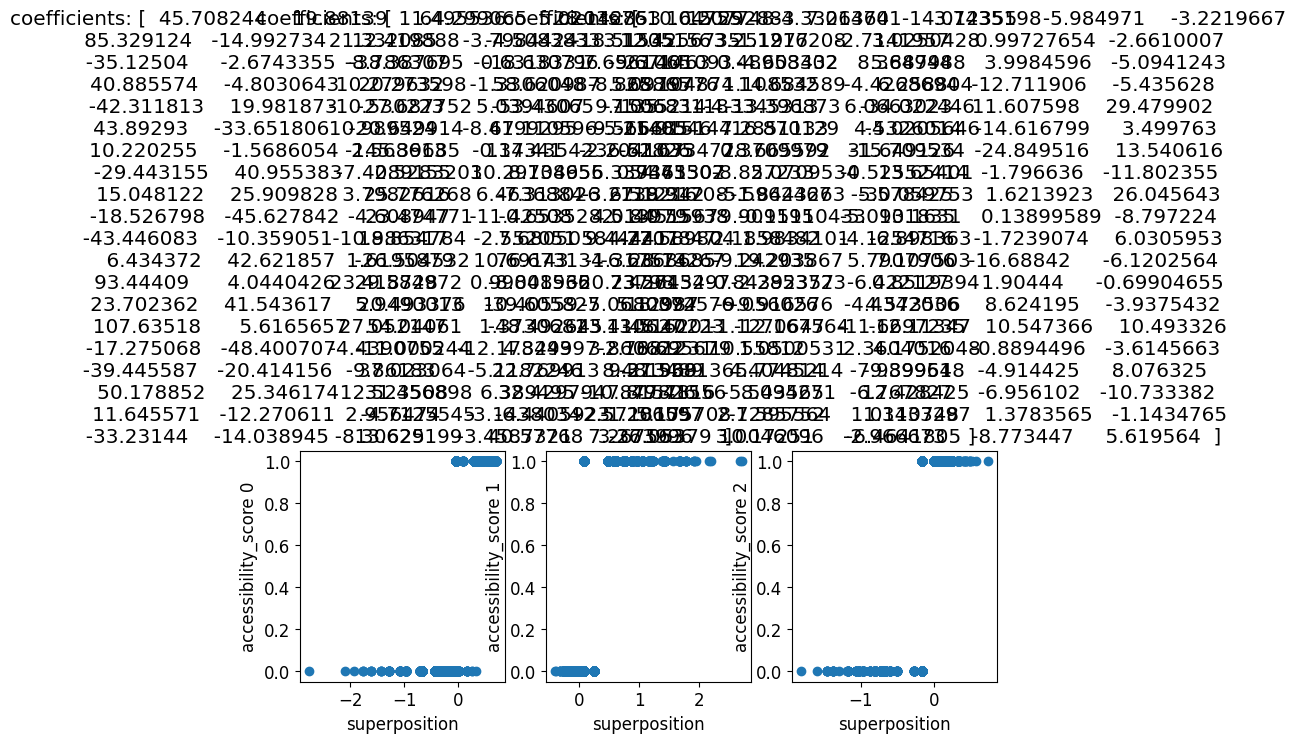

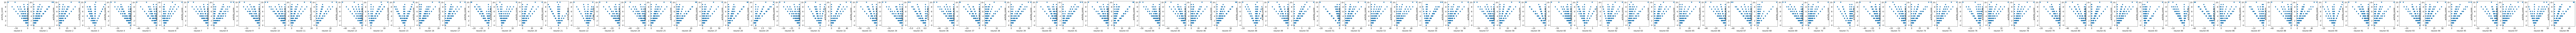

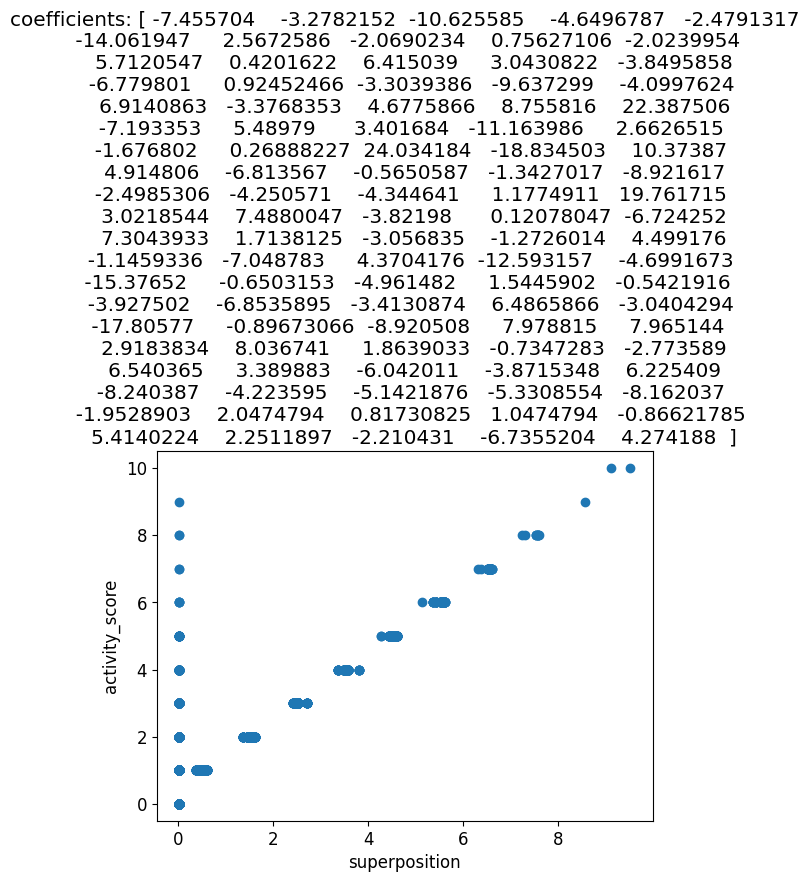

In [13]:
activations = encoder(rna_counts)

plot_neuron_layer(activations)

### ideal

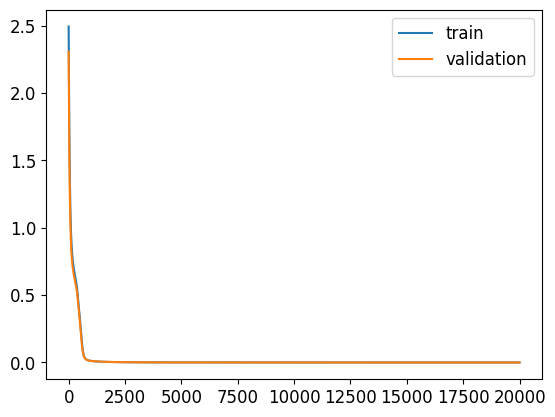

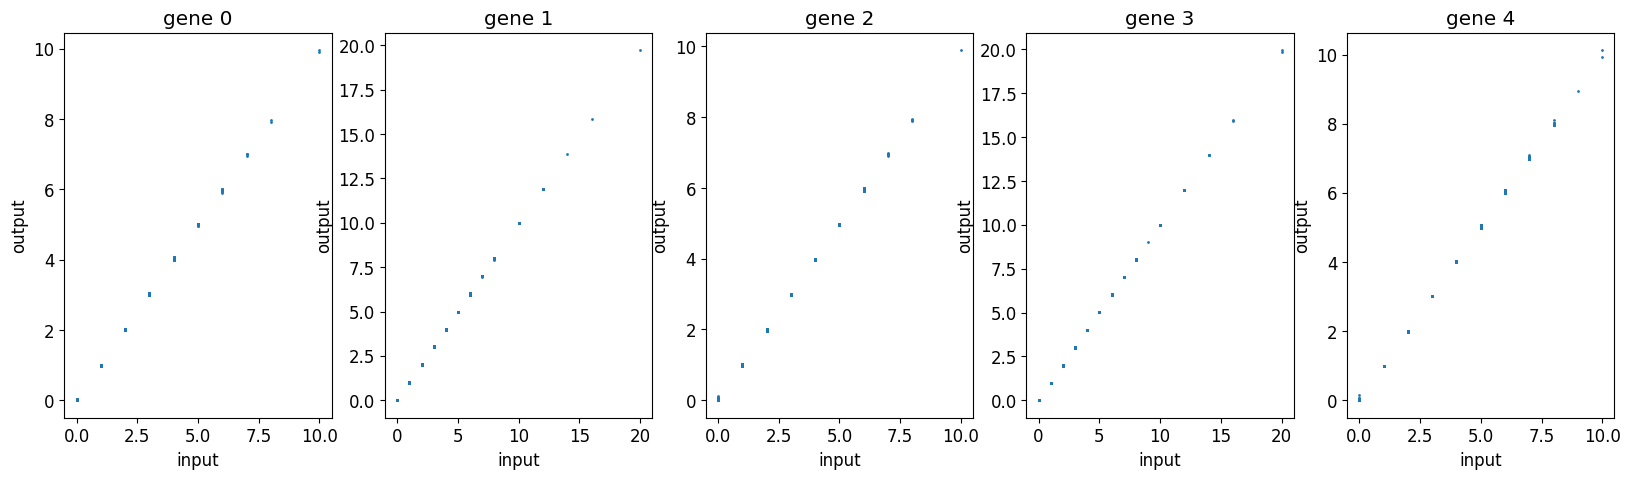

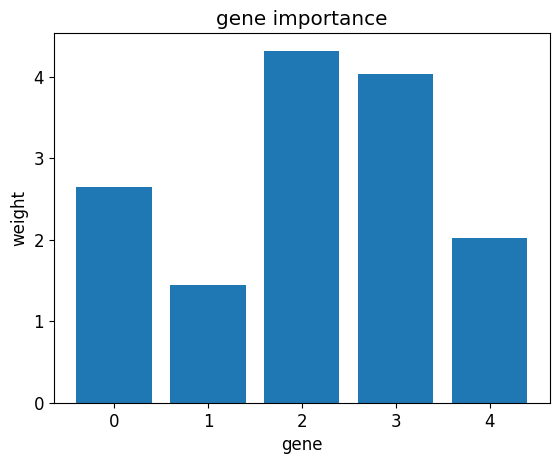

In [18]:
init_type = 'xavier'

encoder = torch.nn.Sequential(
    torch.nn.Linear(5, 5),
    torch.nn.SiLU(),
    torch.nn.Linear(5, 4),
)
encoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

decoder = torch.nn.Sequential(
    torch.nn.Linear(4, 5),
    torch.nn.SiLU(),
    torch.nn.Linear(5, 5),
    torch.nn.ReLU()
)
decoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

encoder, decoder = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, learning_rate=1e-3)

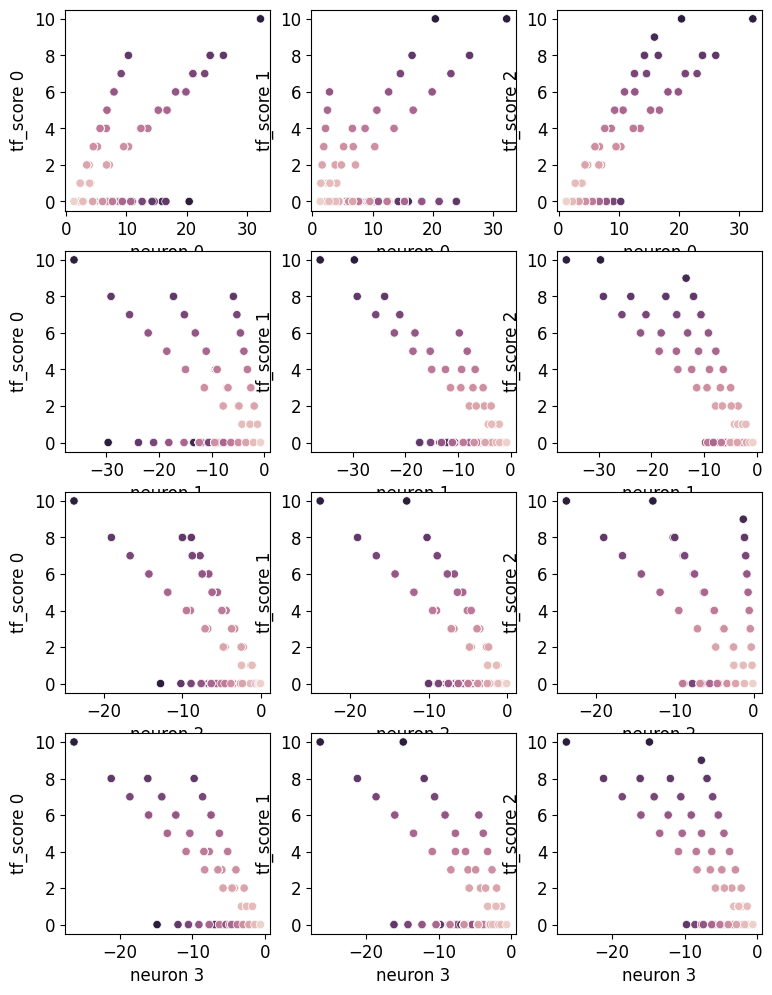

0.9998955295307704
0.9997514508388339
0.9997709585202597


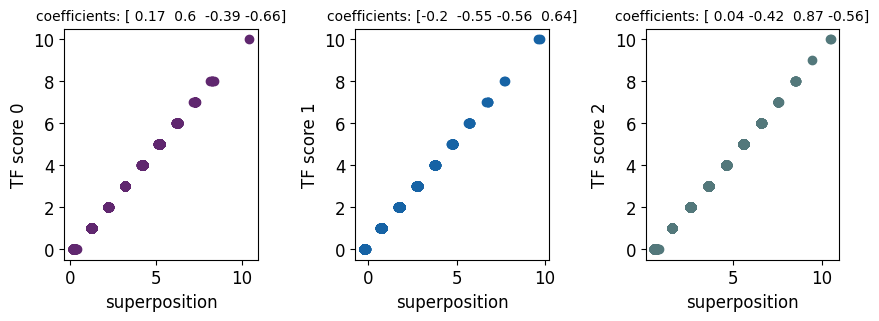

0.7794883832488757


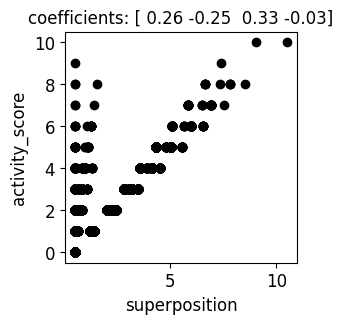

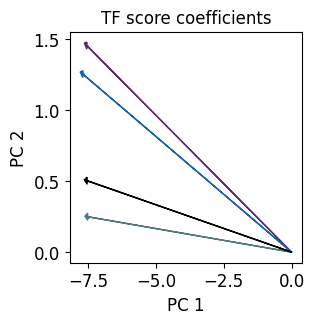

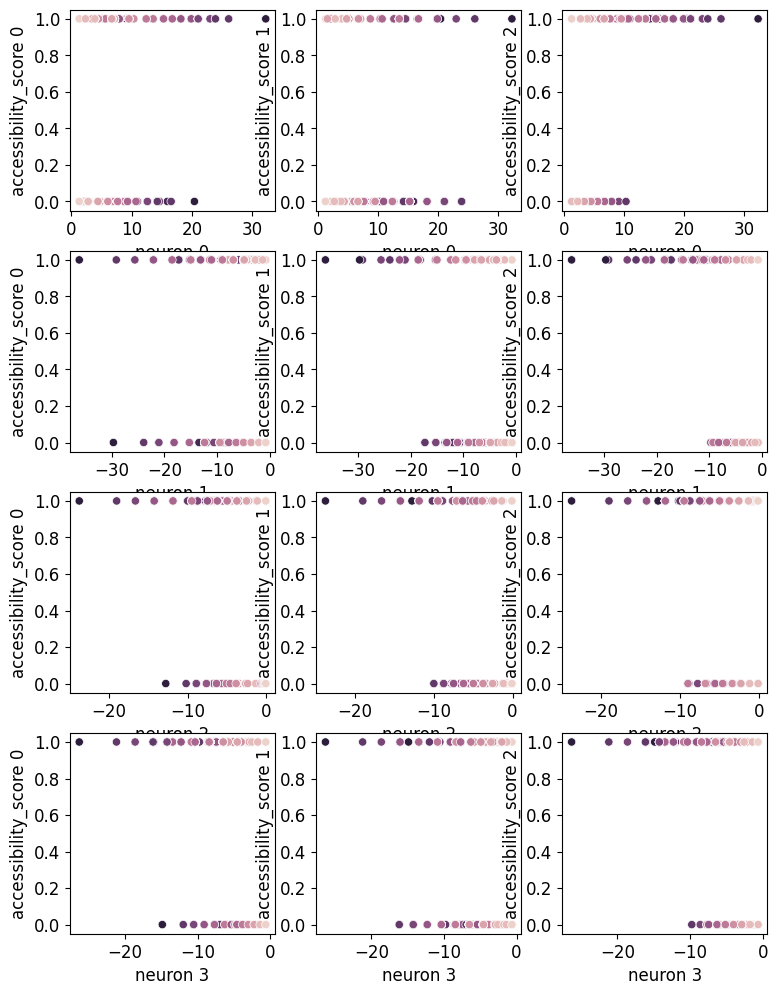

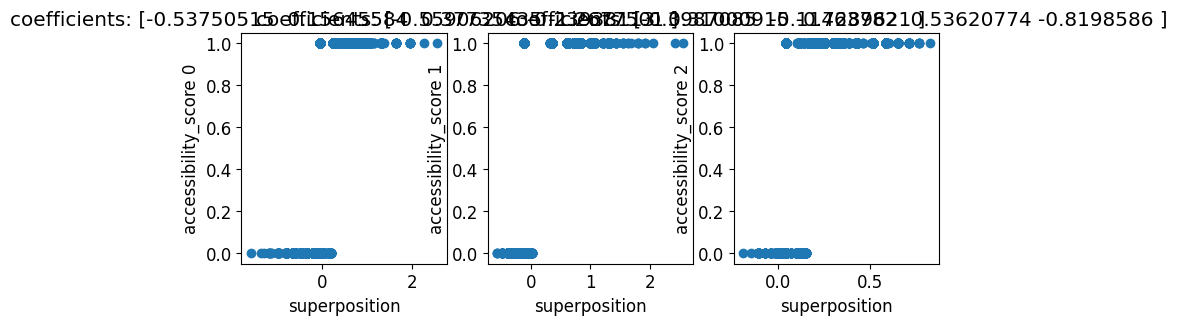

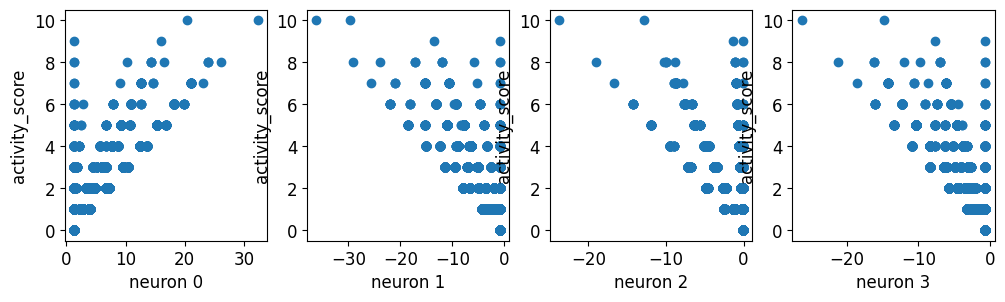

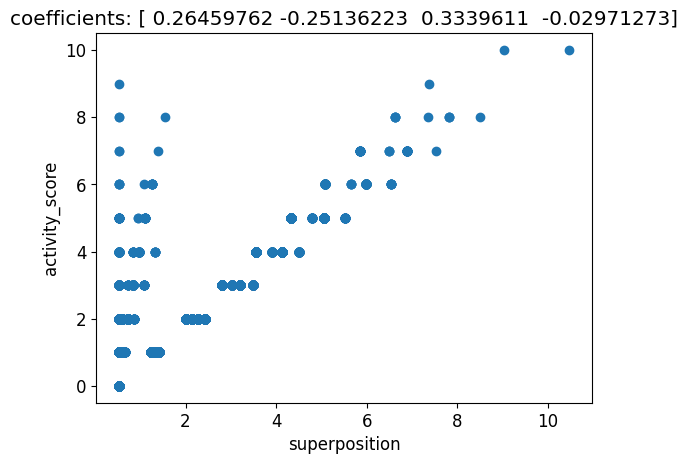

In [19]:
activations = encoder(rna_counts)

plot_neuron_layer(activations)

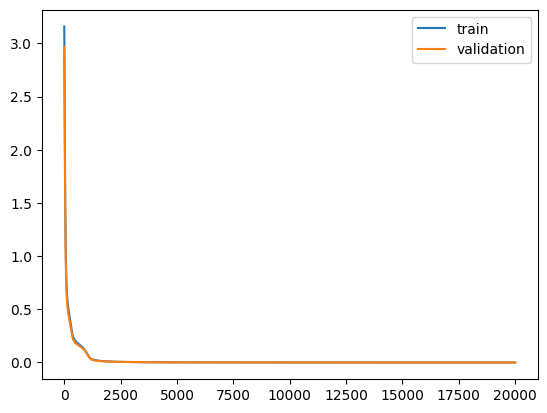

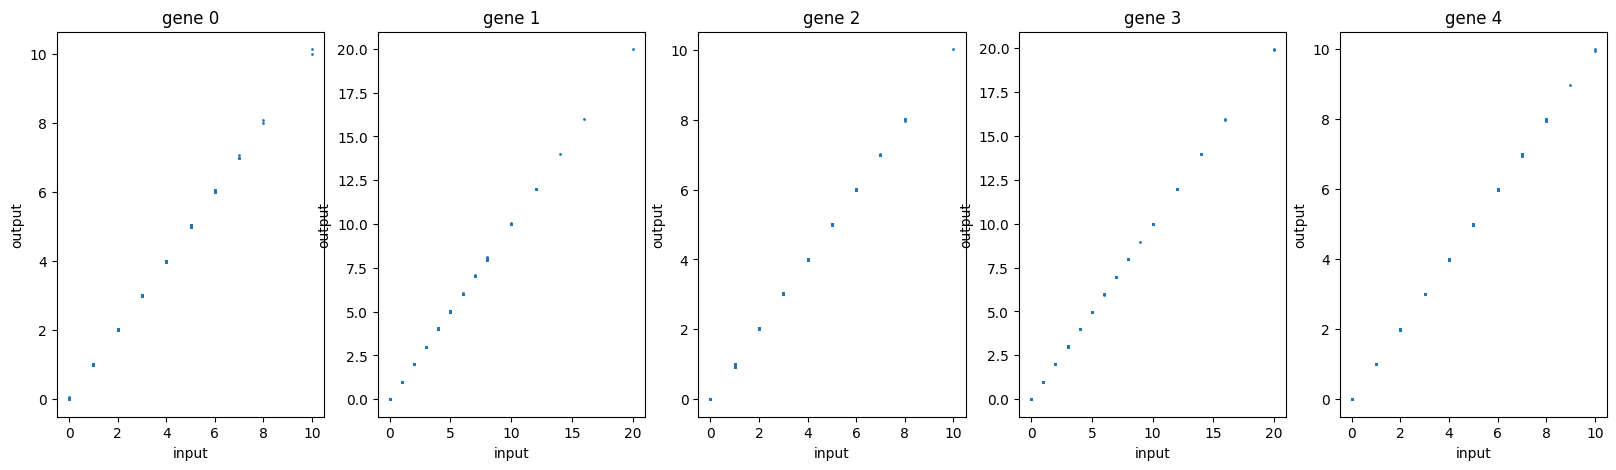

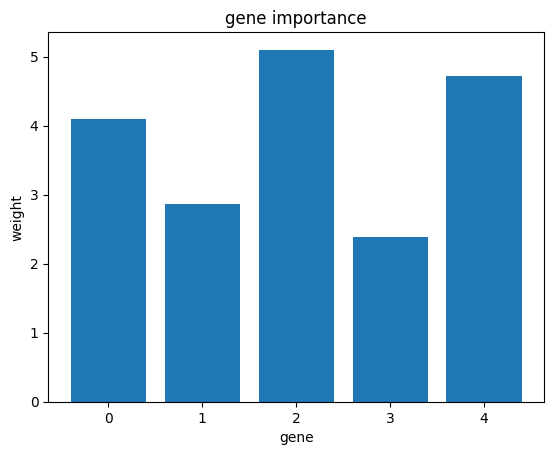

In [63]:
init_type = 'xavier'

encoder = torch.nn.Sequential(
    torch.nn.Linear(5, 5),
    torch.nn.SiLU(),
    torch.nn.Linear(5, 4),
)
encoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

decoder = torch.nn.Sequential(
    torch.nn.Linear(4, 5),
    torch.nn.SiLU(),
    torch.nn.Linear(5, 5),
    torch.nn.ReLU()
)
decoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

encoder, decoder = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, learning_rate=1e-3)

In [64]:
# save this model as the best one
model_name = 'layer2_latent4_xavier'

torch.save(encoder, '03_results/models/sim1_'+model_name+'_encoder.pth')
torch.save(decoder, '03_results/models/sim1_'+model_name+'_decoder.pth')

In [65]:
reps = encoder(rna_counts).detach()

### bottleneck smaller than the number of causal variables

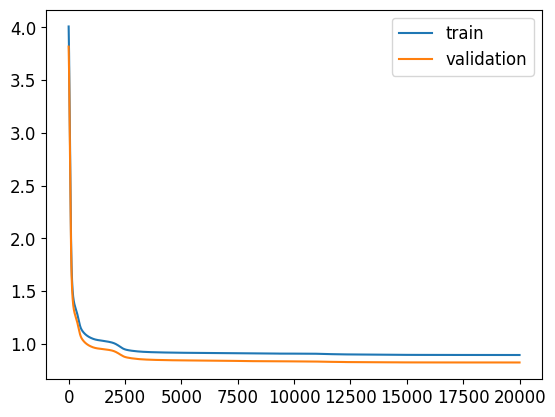

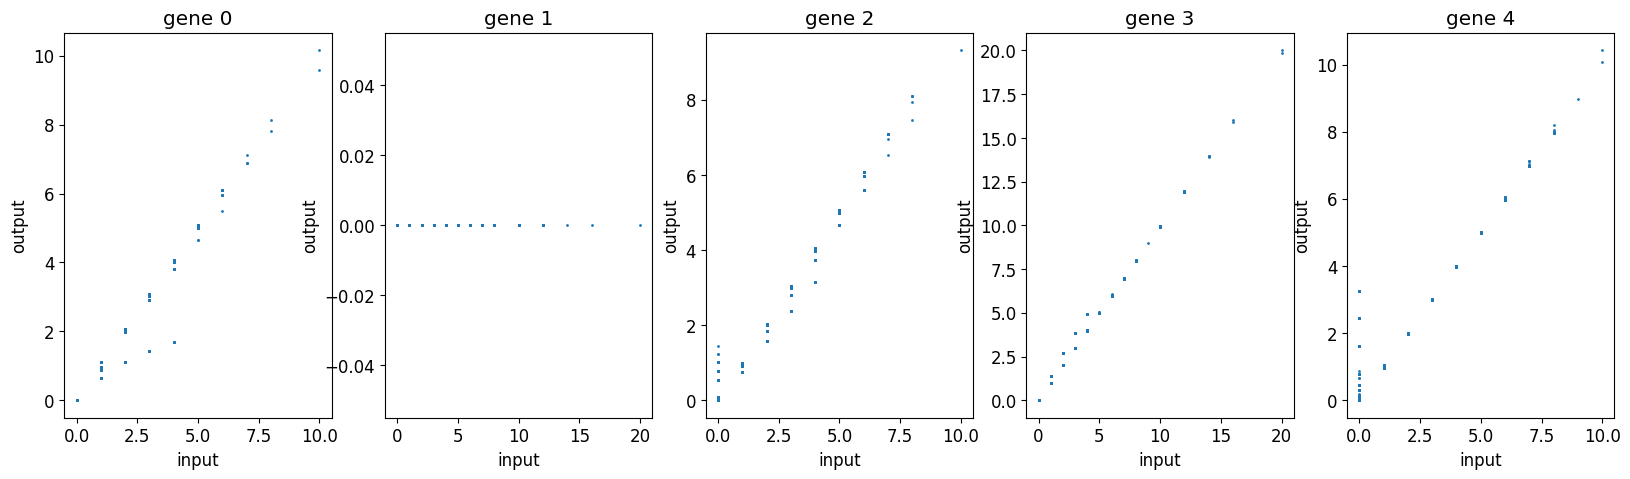

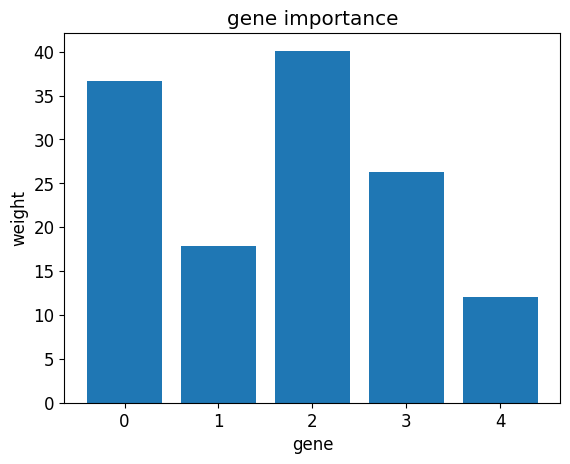

In [20]:
init_type = 'xavier'

encoder = torch.nn.Sequential(
    torch.nn.Linear(5, 5),
    torch.nn.SiLU(),
    torch.nn.Linear(5, 2),
)
encoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.SiLU(),
    torch.nn.Linear(5, 5),
    torch.nn.ReLU()
)
decoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

encoder, decoder = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, learning_rate=1e-3)

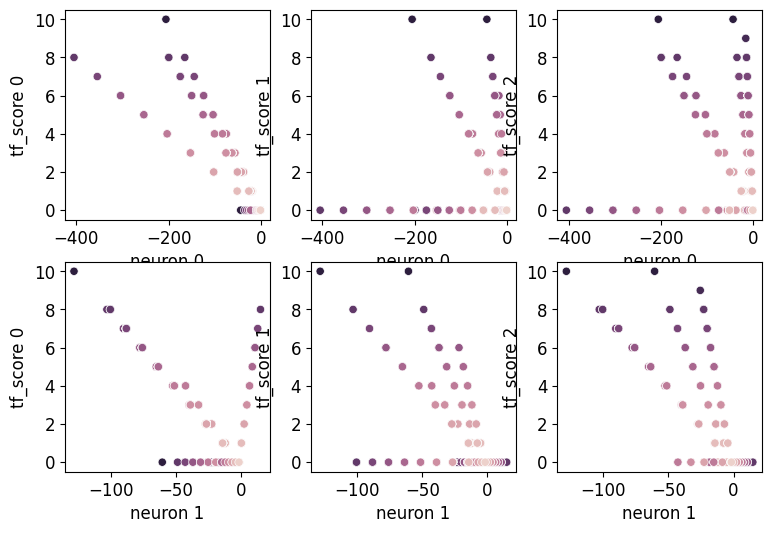

0.9739286297253543
0.07556042118396933
0.5450966974007561


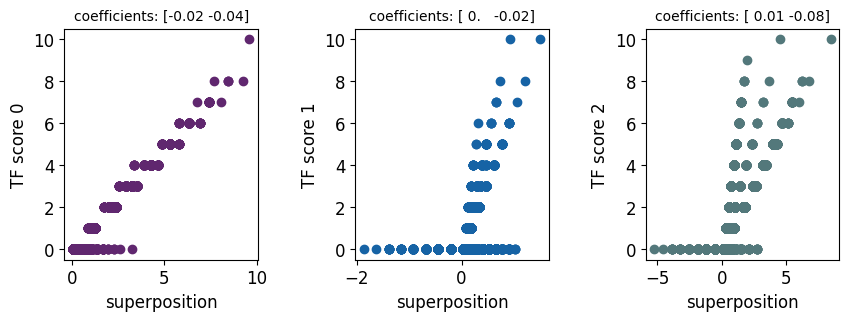

0.39809314410862096


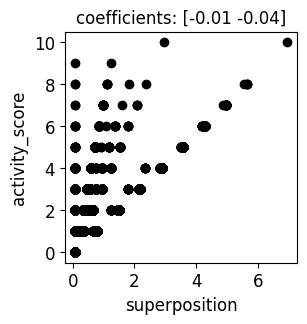

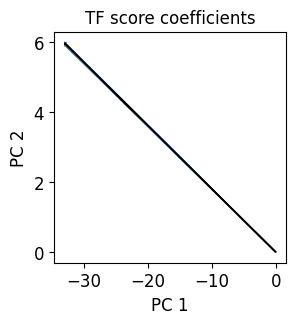

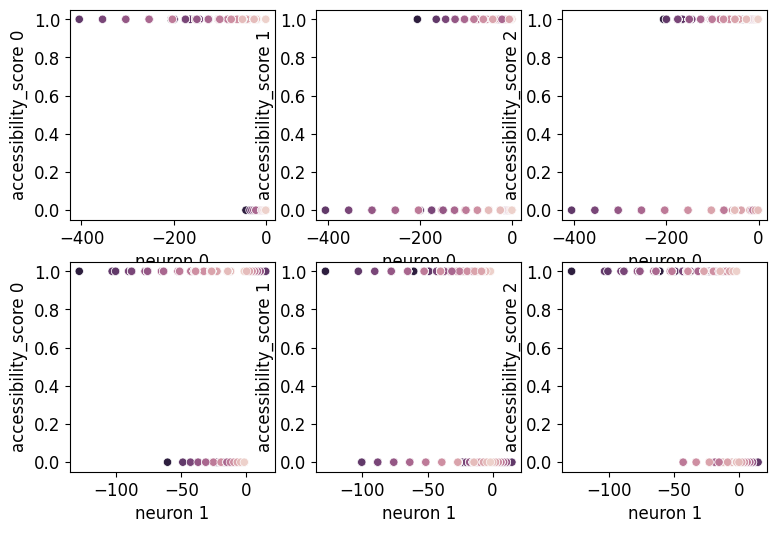

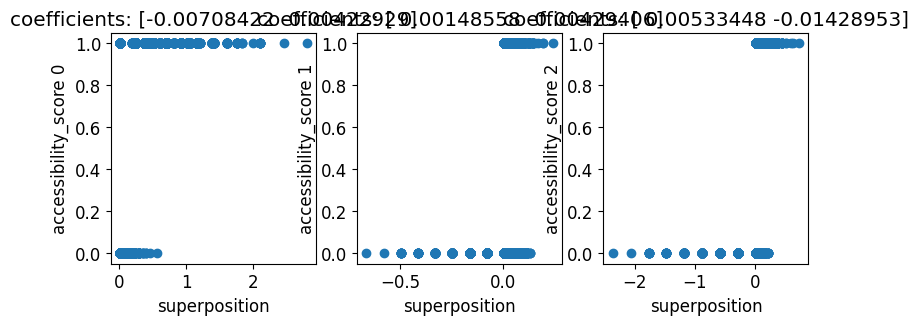

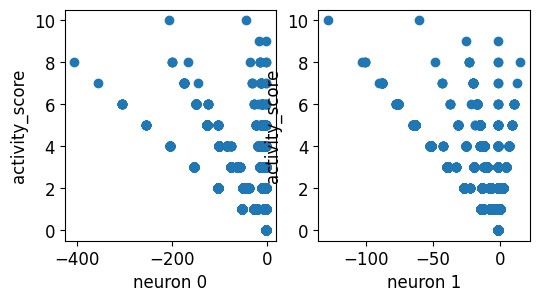

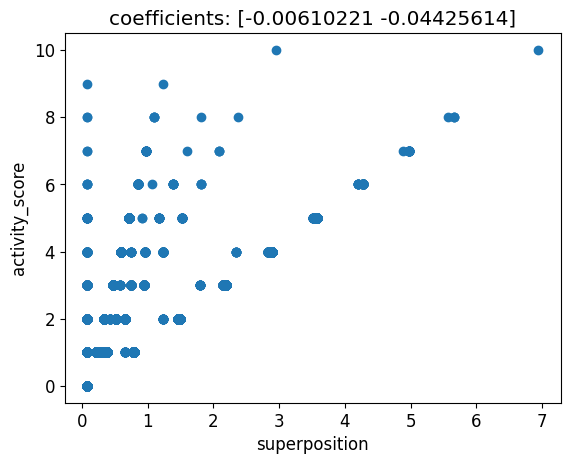

In [21]:
activations = encoder(rna_counts)

plot_neuron_layer(activations)

## Sparse Autoencoder

Hypothesis: the sparse autoencoder can decompose the superpositions into sparse features where one or more directly correspond to the causal variables (TFs, because the activity and accessibility are not decomposable).

### train the normal model to get latents (single-layer)

In [4]:
latent_size = 4

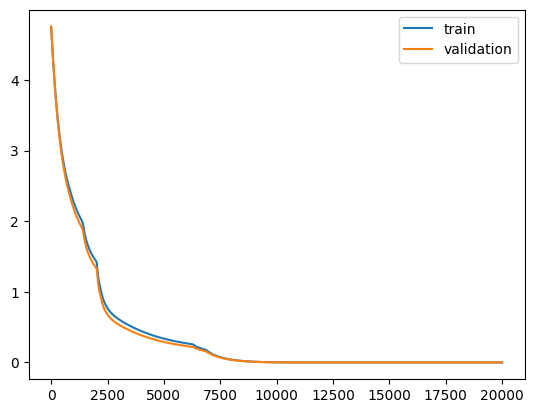

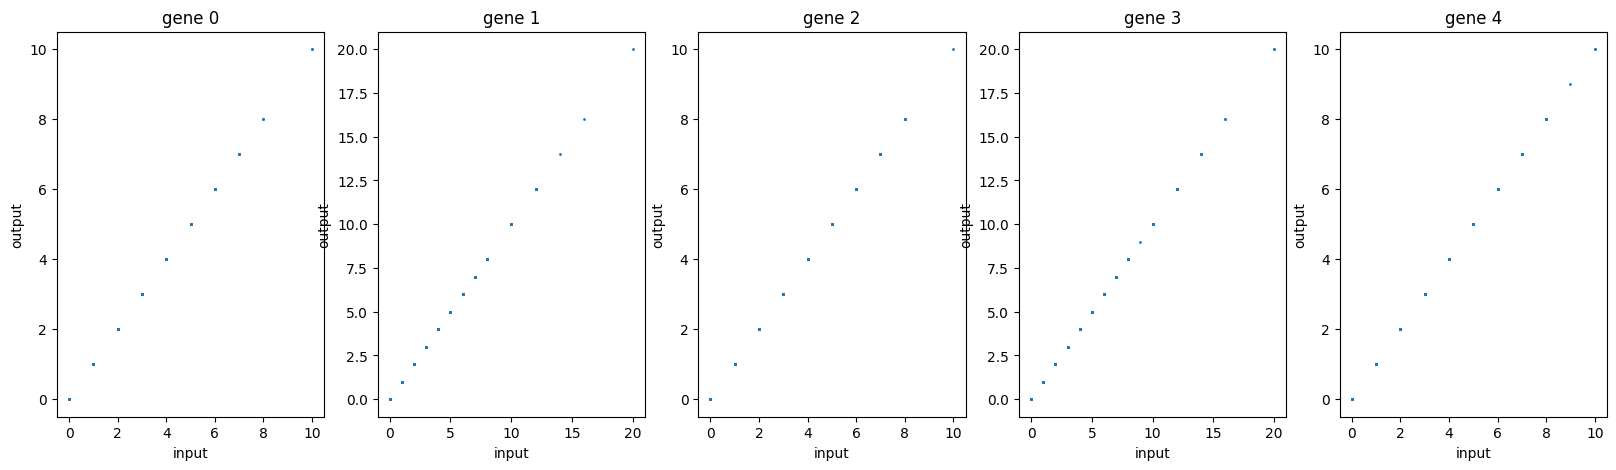

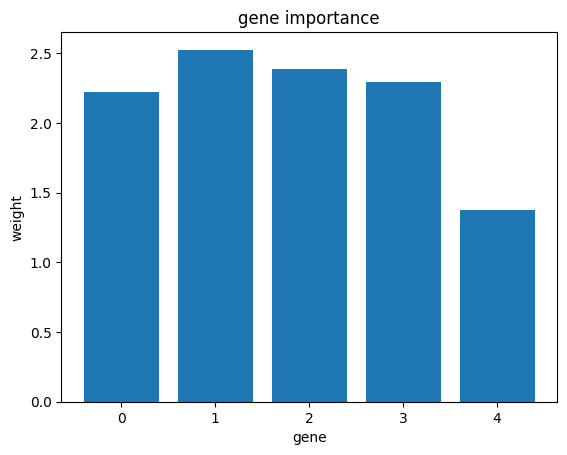

In [17]:
#init_type = 'xavier'
init_type = 'kaiming'

encoder = torch.nn.Sequential(
    torch.nn.Linear(5, latent_size),
)
encoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

decoder = torch.nn.Sequential(
    torch.nn.Linear(latent_size, 5),
    torch.nn.ReLU()
)
decoder.apply(lambda m: custom_weight_init(m, init_option=init_type))

encoder, decoder = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, learning_rate=1e-4)

In [18]:
# save this model as the best one
model_name = 'layer1_latent4'

torch.save(encoder, '03_results/models/sim1_'+model_name+'_encoder.pth')
torch.save(decoder, '03_results/models/sim1_'+model_name+'_decoder.pth')

In [23]:
reps = encoder(rna_counts).detach()

### train an SAE

Epoch [1/500], Loss: 0.53703223
Epoch [2/500], Loss: 0.00571645
Epoch [3/500], Loss: 0.00446802
Epoch [4/500], Loss: 0.00427940
Epoch [5/500], Loss: 0.00418644
Epoch [6/500], Loss: 0.00413838
Epoch [7/500], Loss: 0.00410713
Epoch [8/500], Loss: 0.00408259
Epoch [9/500], Loss: 0.00405994
Epoch [10/500], Loss: 0.00403974
Epoch [11/500], Loss: 0.00401974
Epoch [12/500], Loss: 0.00399963
Epoch [13/500], Loss: 0.00398062
Epoch [14/500], Loss: 0.00395980
Epoch [15/500], Loss: 0.00394272
Epoch [16/500], Loss: 0.00392243
Epoch [17/500], Loss: 0.00390065
Epoch [18/500], Loss: 0.00388000
Epoch [19/500], Loss: 0.00386323
Epoch [20/500], Loss: 0.00384187
Epoch [21/500], Loss: 0.00382274
Epoch [22/500], Loss: 0.00380041
Epoch [23/500], Loss: 0.00378458
Epoch [24/500], Loss: 0.00376638
Epoch [25/500], Loss: 0.00374052
Epoch [26/500], Loss: 0.00372079
Epoch [27/500], Loss: 0.00369716
Epoch [28/500], Loss: 0.00378713
Epoch [29/500], Loss: 0.00364297
Epoch [30/500], Loss: 0.00361854
Epoch [31/500], Los

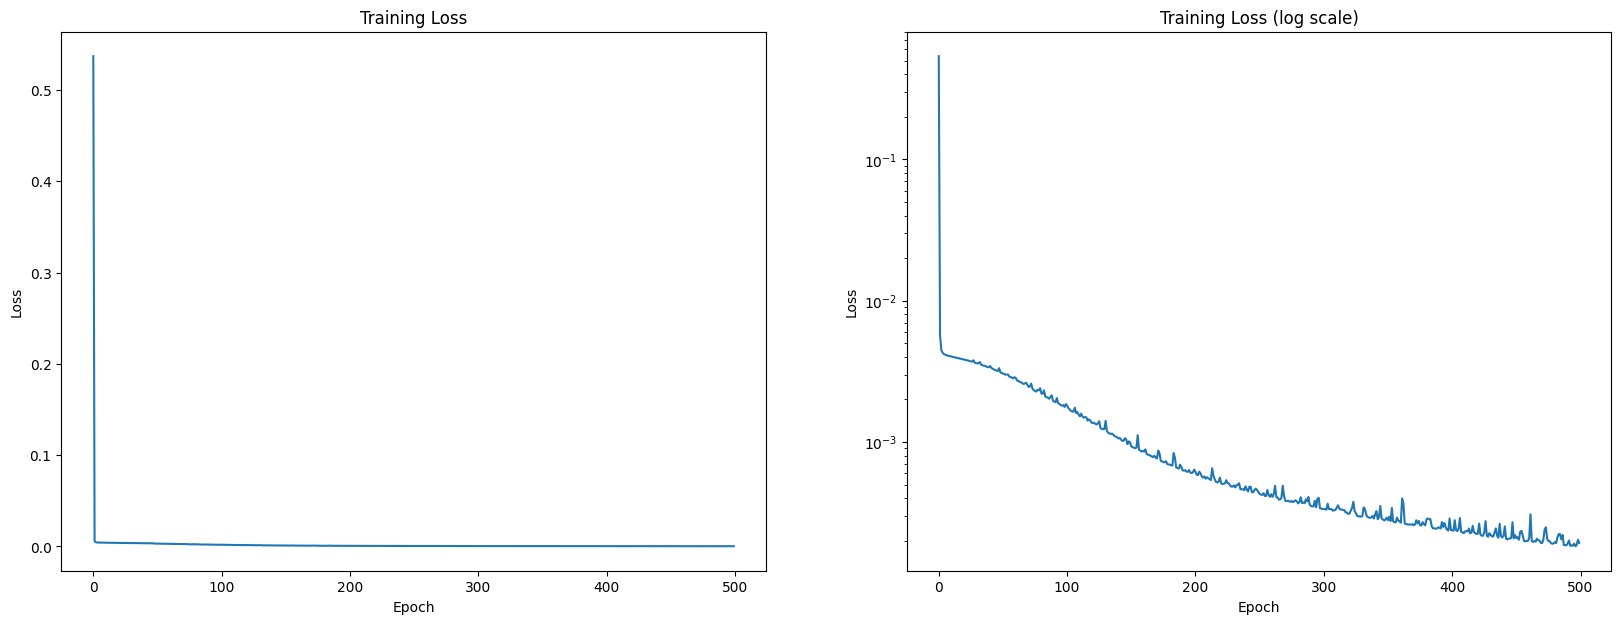

In [24]:
# Hyperparameters
input_size = latent_size
hidden_size = input_size * 100
learning_rate = 1e-3
num_epochs = 500
batch_size = 128
sparsity_penalty = 1e-5  # Weight for weight sparsity
l1_weight = 1e-3  # Weight for activation sparsity
#early_stopping = 10

# Load dataset (Replace with your own dataset)
# Example using random data, replace with actual dataset
train_data = reps.clone().to(device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize model
sae_model = SparseAutoencoder(input_size, hidden_size)
sae_model = sae_model.to(device)

# Optimizer
optimizer = optim.Adam(sae_model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):

    # early stopping if the last 10 epochs have not improved the loss
    #if len(losses) > early_stopping:
    #    if np.min(losses[-early_stopping:]) == losses[-early_stopping]:
    #        print(f'Early stopping at epoch {epoch + 1}')
    #        break
    
    total_loss = 0
    for x in train_loader:
        # Get inputs and convert to torch Variable
        inputs = x
        inputs = inputs.to(device)
        
        # Forward pass
        outputs, encoded = sae_model(inputs)
        
        # Compute loss
        loss = loss_function(
            outputs, 
            inputs, 
            encoded, 
            sae_model.encoder[0].weight,  # Pass the encoder's weights for weight sparsity
            sparsity_penalty, 
            l1_weight
        )
        
        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    losses.append(total_loss / len(train_loader))
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.8f}')

print("Training complete.")

# plot loss curve (normal) and log_scaled
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs[0].plot(losses)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[1].plot(losses)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training Loss (log scale)')
axs[1].set_yscale('log')
plt.show()

### finding sparse features that correspond to causal variables

In [26]:
reps_reconstructed, activations = sae_model(reps.to(device))

In [35]:
n_activation_features = activations.shape[1]
print(f'Number of activation features: {n_activation_features}')

# check which activation features are active at all
threshold = 1e-10

unique_active_unit_indices = get_unique_active_unit_indices(sae_model, train_loader, threshold=threshold)
print(f'Unique Active Neuron Indices: {unique_active_unit_indices}')
print(f'Number of unique active hidden units: {len(unique_active_unit_indices)}')

avg_active_hidden_units = count_active_hidden_units(sae_model, train_loader, threshold=threshold, avg=True)
print(f'Average number of active hidden units per sample: {avg_active_hidden_units:.2f}')

Number of activation features: 400
Unique Active Neuron Indices: [1, 3, 12, 18, 24, 28, 31, 33, 39, 46, 47, 58, 65, 76, 78, 79, 88, 93, 104, 108, 113, 124, 126, 134, 147, 157, 158, 168, 169, 170, 171, 174, 178, 179, 181, 184, 185, 188, 191, 203, 206, 207, 211, 220, 222, 223, 228, 231, 236, 238, 243, 252, 260, 267, 271, 274, 276, 280, 282, 283, 291, 296, 298, 299, 304, 324, 331, 333, 339, 347, 348, 350, 356, 357, 361, 381, 390, 392, 394]
Number of unique active hidden units: 79
Average number of active hidden units per sample: 57.54


In [43]:
# go through all active activations and calculate correlation with the rna counts, tf_scores, activity and accessibility scores
comparison_data = np.concatenate((rna_counts, tf_scores, activity_score, accessibility_scores), axis=1)

correlations = np.zeros((len(unique_active_unit_indices), comparison_data.shape[1]))

for i, feat in enumerate(unique_active_unit_indices):
    # get the activations
    feat_activation = activations[:, feat]
    for j in range(comparison_data.shape[1]):
        corr = np.corrcoef(feat_activation.cpu().detach().numpy(), comparison_data[:, j])[0, 1]
        correlations[i, j] = corr

# make a dataframe
column_names = [f'RNA {i}' for i in range(rna_counts.shape[1])] + [f'TF {i}' for i in range(tf_scores.shape[1])] + ['Activity'] + [f'Accessibility {i}' for i in range(accessibility_scores.shape[1])]
df_corr = pd.DataFrame(correlations, columns=column_names, index=unique_active_unit_indices)

In [44]:
df_corr

RNA 0     RNA 1     RNA 2     RNA 3     RNA 4      TF 0      TF 1  \
1    0.258041  0.949569  0.987065  0.481278  0.448977  0.987065  0.258041   
3    0.500098  0.418294  0.222102  0.929011  0.865605  0.222102  0.500098   
12   0.286242  0.924077  0.941229  0.648121  0.636952  0.941229  0.286242   
18  -0.146184 -0.152395 -0.100741 -0.603865 -0.657065 -0.100741 -0.146184   
24  -0.154524 -0.420701 -0.415185 -0.591533 -0.637670 -0.415185 -0.154524   
..        ...       ...       ...       ...       ...       ...       ...   
361  0.287362  0.926997  0.944085  0.658077  0.648467  0.944085  0.287362   
381  0.472101  0.488085  0.320499  0.982717  0.945681  0.320499  0.472101   
390 -0.048220  0.290980  0.372539  0.776596  0.969693  0.372539 -0.048220   
392  0.146914  0.908092  0.998916  0.436273  0.452911  0.998916  0.146914   
394 -0.247207 -0.884815 -0.916031 -0.698304 -0.718572 -0.916031 -0.247207   

         TF 2  Activity  Accessibility 0  Accessibility 1  Accessibility 2  
1    0.448977  0.508701         0.689630         0.134159         0.003915  
3    0.865605  0.809790        -0.160825         0.263242         0.225266  
12   0.636952  0.652373         0.537145         0.125691         0.105952  
18  -0.657065 -0.381864         0.149059        -0.083036        -0.649649  
24  -0.637670 -0.576919        -0.223782        -0.067359        -0.271814  
..        ...       ...              ...              ...              ...  
361  0.648467  0.663364         0.550730         0.126460         0.108753  
381  0.945681  0.838170        -0.098607         0.254406         0.364962  
390  0.969693  0.827650        -0.046213        -0.177038         0.424434  
392  0.452911  0.508649         0.700239         0.041512         0.011293  
394 -0.718572 -0.715257        -0.549765        -0.100149        -0.165553  

[79 rows x 12 columns]

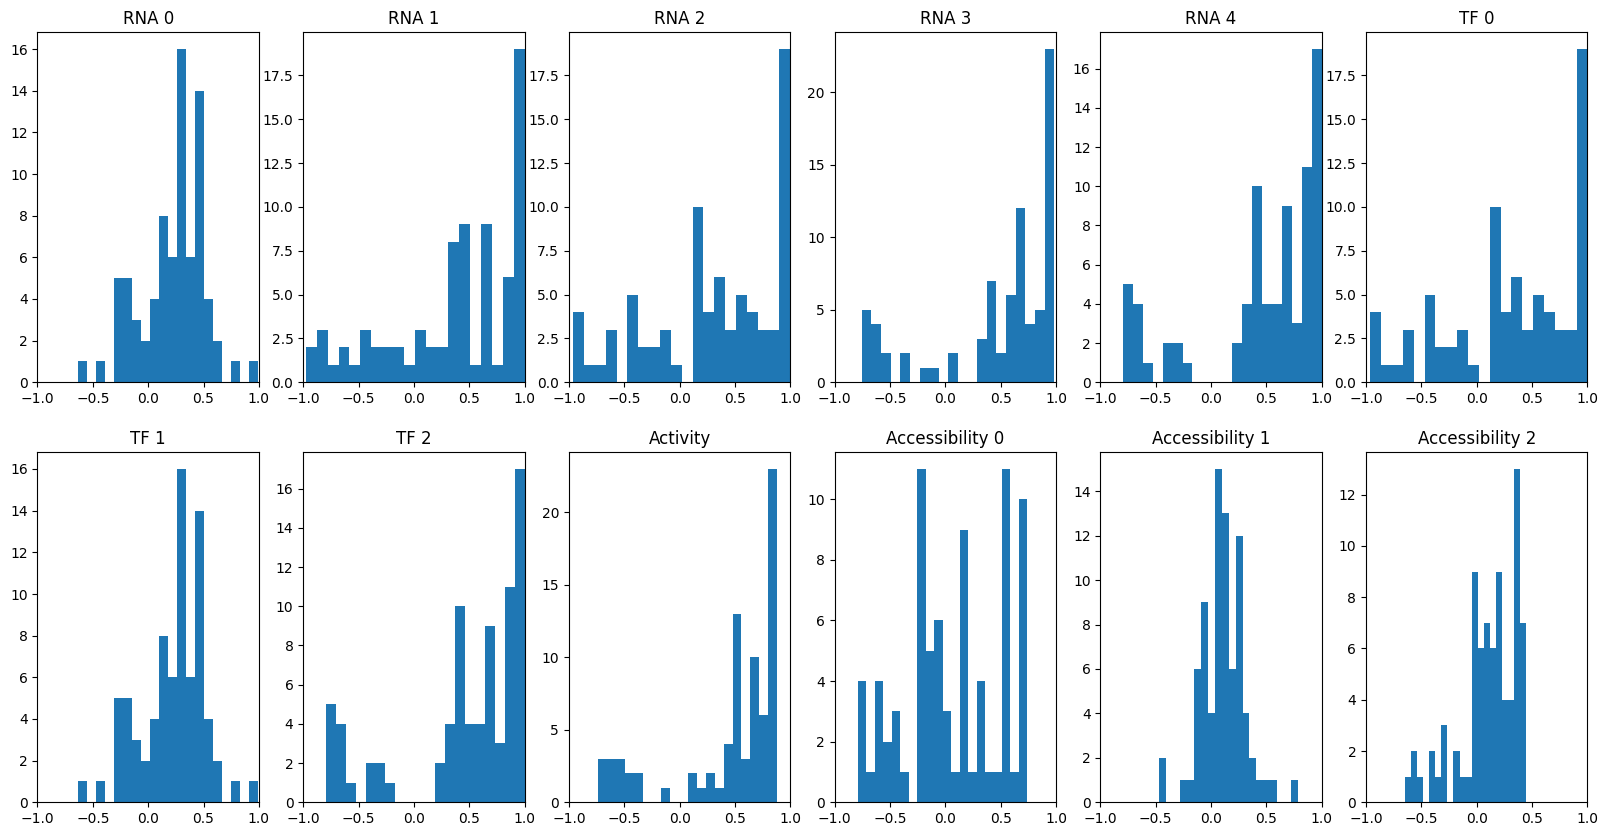

In [48]:
# plot a histogram for the correlations of each column

import math
n_cols = math.ceil(df_corr.shape[1] / 2)


fig, axs = plt.subplots(2, n_cols, figsize=(20, 10))
for i in range(df_corr.shape[1]):
    axs[i // n_cols, i % n_cols].hist(df_corr.iloc[:, i], bins=20)
    axs[i // n_cols, i % n_cols].set_title(column_names[i])
    # x limits should be -1, 1
    axs[i // n_cols, i % n_cols].set_xlim(-1, 1)
plt.show()

In [53]:
# for each column, show the highest correlating activation feature

best_ids = []
best_corrs = []

for i in range(df_corr.shape[1]):
    best_id = df_corr.iloc[:, i].idxmax()
    best_ids.append(best_id)
    best_corrs.append(df_corr.iloc[:, i].max())

# make a dataframe
df_best = pd.DataFrame({'Data feature': df_corr.columns, 'SAE feature': best_ids, 'Correlation': best_corrs}, index=column_names)
print(df_best)

                    Data feature  SAE feature  Correlation
RNA 0                      RNA 0          207     0.994422
RNA 1                      RNA 1          203     0.999561
RNA 2                      RNA 2          228     0.999010
RNA 3                      RNA 3          381     0.982717
RNA 4                      RNA 4           39     0.998980
TF 0                        TF 0          228     0.999010
TF 1                        TF 1          207     0.994422
TF 2                        TF 2           39     0.998980
Activity                Activity          124     0.881810
Accessibility 0  Accessibility 0           46     0.741767
Accessibility 1  Accessibility 1          207     0.785473
Accessibility 2  Accessibility 2          304     0.448883


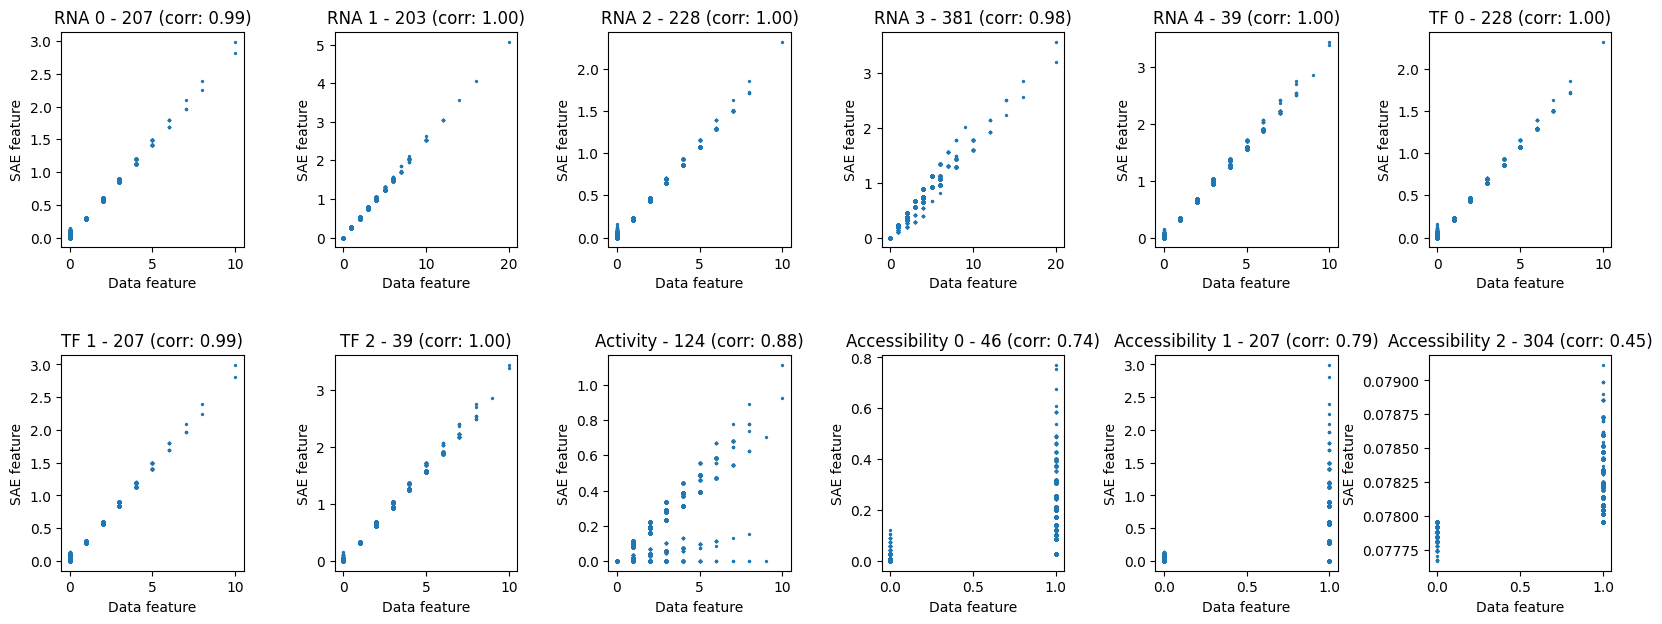

In [60]:
# plot the data features against these SAE features

fig, axs = plt.subplots(2, n_cols, figsize=(20, 7))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(df_corr.shape[1]):
    axs[i // n_cols, i % n_cols].scatter(comparison_data[:, i], activations[:, best_ids[i]].cpu().detach().numpy(), s=2)
    axs[i // n_cols, i % n_cols].set_title(column_names[i] + f' - {best_ids[i]} (corr: {best_corrs[i]:.2f})')
    axs[i // n_cols, i % n_cols].set_ylabel('SAE feature')
    axs[i // n_cols, i % n_cols].set_xlabel('Data feature')

plt.show()

## Exp 2: performance metrics

In [2]:
# load the data
rna_counts = torch.tensor(np.load("01_data/sim_rna_counts.npy"))
tf_scores = torch.tensor(np.load("01_data/sim_tf_scores.npy"))
activity_score = torch.tensor(np.load("01_data/sim_activity_scores.npy"))
accessibility_scores = torch.tensor(np.load("01_data/sim_accessibility_scores.npy"))

### utils

In [12]:
import torch
import torch.nn as nn
import math
from typing import Callable

class BiasLayer(torch.nn.Module):
    def __init__(self, input_size, init='standard') -> None:
        super().__init__()
        if init == 'standard':
            stdv = 1. / math.sqrt(input_size)
            # init bias to a uniform distribution
            bias_value = torch.empty((input_size)).uniform_(-stdv, stdv)
        else:
            bias_value = torch.zeros(input_size)

        self.bias_layer = torch.nn.Parameter(bias_value)
    
    def forward(self, x):
        return x + self.bias_layer

# Sparse Autoencoder Model with Mechanistic Interpretability
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, input_bias: bool = False, activation: Callable = nn.ReLU(), bias_type='standard', tied: bool = False):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.pre_bias = BiasLayer(input_size, init=bias_type)
        self.latent_bias = BiasLayer(hidden_size, init=bias_type)
        self.encoder_linear = nn.Linear(input_size, hidden_size, bias=False)
        self.activation = activation
        if input_bias:
            self.encoder = nn.Sequential(
                self.pre_bias,
                self.encoder_linear,
                self.latent_bias,
                self.activation
            )
        else:
            self.encoder = nn.Sequential(
                self.encoder_linear,
                self.latent_bias,
                self.activation
            )
        #decoder
        if tied:
            self.decoder: nn.Linear | TiedTranspose = TiedTranspose(self.encoder)
            self.decoder = nn.Sequential(
                nn.Linear(hidden_size, input_size, bias=False)
            )
        else:
            self.decoder = nn.Sequential(
                nn.Linear(hidden_size, input_size, bias=False),
                BiasLayer(input_size, init=bias_type)
            )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

class TiedTranspose(nn.Module):
    def __init__(self, linear: nn.Linear):
        super().__init__()
        self.linear = linear

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert self.linear.bias is None
        return F.linear(x, self.linear.weight.t(), None)

    @property
    def weight(self) -> torch.Tensor:
        return self.linear.weight.t()

    @property
    def bias(self) -> torch.Tensor:
        return self.linear.bias

class TopK(nn.Module):
    def __init__(self, k: int, postact_fn: Callable = nn.ReLU()) -> None:
        super().__init__()
        self.k = k
        self.postact_fn = postact_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        topk = torch.topk(x, k=self.k, dim=-1)
        values = self.postact_fn(topk.values)
        # make all other values 0
        result = torch.zeros_like(x)
        result.scatter_(-1, topk.indices, values)
        return result

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        state_dict = super().state_dict(destination, prefix, keep_vars)
        state_dict.update({prefix + "k": self.k, prefix + "postact_fn": self.postact_fn.__class__.__name__})
        return state_dict

    @classmethod
    def from_state_dict(cls, state_dict: dict[str, torch.Tensor], strict: bool = True) -> "TopK":
        k = state_dict["k"]
        postact_fn = ACTIVATIONS_CLASSES[state_dict["postact_fn"]]()
        return cls(k=k, postact_fn=postact_fn)


ACTIVATIONS_CLASSES = {
    "ReLU": nn.ReLU,
    "Identity": nn.Identity,
    "TopK": TopK,
}

def train_sae(train_loader, hidden_factor, lr, l1_weight=1e-3, sparsity_penalty=0, n_epochs=500, sae_type='vanilla', k_latent_percent=100):
    # Initialize model
    hidden_size = input_size * hidden_factor
    k_latent = max(1, int(hidden_size * k_latent_percent / 100)) # make sure there is at least 1 latent feature
    if sae_type == 'vanilla':
        sae_model = SparseAutoencoder(input_size, hidden_size)
    elif sae_type == 'bricken':
        sae_model = SparseAutoencoder(input_size, hidden_size, input_bias=True, bias_type='zero')
    elif sae_type == 'topk':
        sae_model = SparseAutoencoder(input_size, hidden_size, input_bias=True, bias_type='zero', activation=TopK(k_latent))
    else:
        raise ValueError('Invalid SAE type')
    sae_model = sae_model.to(device)

    # Optimizer
    optimizer = optim.Adam(sae_model.parameters(), lr=lr)

    # Training loop
    losses = []
    for epoch in range(n_epochs):
        total_loss = 0
        for x in train_loader:
            # Get inputs and convert to torch Variable
            inputs = x
            inputs = inputs.to(device)
            
            # Forward pass
            outputs, encoded = sae_model(inputs)
            
            # Compute loss
            if sae_type != 'vanilla':
                loss = loss_function(
                    outputs, 
                    inputs, 
                    encoded, 
                    sae_model.encoder[1].weight,  # Pass the encoder's weights for weight sparsity
                    sparsity_penalty, 
                    l1_weight
                )
            else:
                loss = loss_function(
                    outputs, 
                    inputs, 
                    encoded, 
                    sae_model.encoder[0].weight,  # Pass the encoder's weights for weight sparsity
                    sparsity_penalty, 
                    l1_weight
                )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        losses.append(total_loss / len(train_loader))
    
    return sae_model, losses[-1]

############################################

def get_n_features(activations, threshold=1e-10):
    n_activation_features = activations.shape[1]
    unique_active_unit_indices = get_unique_active_unit_indices(sae_model, train_loader, threshold=threshold)
    avg_active_hidden_units = count_active_hidden_units(sae_model, train_loader, threshold=threshold, avg=True)
    return n_activation_features, unique_active_unit_indices, avg_active_hidden_units

def get_number_of_redundant_features(activations, unique_activs, threshold=0.95):
    # compute correlations between all active features
    redundant_set = set()
    for i in range(len(unique_activs)):
        for j in range(i+1, len(unique_activs)):
            corr = np.corrcoef(activations[:, unique_activs[i]].cpu().detach().numpy(), activations[:, unique_activs[j]].cpu().detach().numpy())[0, 1]
            if corr > threshold:
                # add the feature to the redundant set
                redundant_set.add(unique_activs[j])
    n_redundant = len(redundant_set)
    return n_redundant

def get_correlations_with_data(activations, unique_activs, comparison_data):
    correlations = np.zeros((len(unique_activs), comparison_data.shape[1]))
    for i, feat in enumerate(unique_activs):
        # get the activations
        feat_activation = activations[:, feat]
        for j in range(comparison_data.shape[1]):
            corr = np.corrcoef(feat_activation.cpu().detach().numpy(), comparison_data[:, j])[0, 1]
            correlations[i, j] = corr
    return correlations

def get_n_features_per_attribute(correlations, threshold=0.95):
    n_per_attribute = np.zeros(correlations.shape[1])
    for i in range(correlations.shape[1]):
        n_per_attribute[i] = np.sum(np.abs(correlations[:, i]) > threshold)
    return n_per_attribute

def get_highest_corr_per_attribute(correlations):
    best_corrs = np.zeros(correlations.shape[1])
    for i in range(correlations.shape[1]):
        best_id = np.argmax(np.abs(correlations[:, i]))
        best_corrs[i] = correlations[best_id, i]
    return best_corrs

def run_sae_analysis(activations, comparison_data):
    n_activation_features, unique_active_unit_indices, avg_active_hidden_units = get_n_features(activations)
    n_unique = len(unique_active_unit_indices)
    n_redundant = get_number_of_redundant_features(activations, unique_active_unit_indices)
    if len(unique_active_unit_indices) > 0:
        correlations = get_correlations_with_data(activations, unique_active_unit_indices, comparison_data)
        n_per_attribute = get_n_features_per_attribute(correlations)
        n_per_rna = n_per_attribute[:5].mean()
        n_per_tf = n_per_attribute[5:8].mean()
        n_per_activity = n_per_attribute[8]
        n_per_accessibility = n_per_attribute[9:].mean()
        highest_corrs = get_highest_corr_per_attribute(correlations)
        highest_corrs_rna = highest_corrs[:5].mean()
        highest_corrs_tf = highest_corrs[5:8].mean()
        highest_corrs_activity = highest_corrs[8]
        highest_corrs_accessibility = highest_corrs[9:].mean()
    else:
        n_per_rna = 0
        n_per_tf = 0
        n_per_activity = 0
        n_per_accessibility = 0
        highest_corrs_rna = 0
        highest_corrs_tf = 0
        highest_corrs_activity = 0
        highest_corrs_accessibility = 0
    return n_activation_features, n_unique, avg_active_hidden_units, n_redundant, n_per_rna, n_per_tf, n_per_activity, n_per_accessibility, highest_corrs_rna, highest_corrs_tf, highest_corrs_activity, highest_corrs_accessibility

### vanilla SAE

In [132]:
model_name = 'layer1_latent4'
latent_size = 4

encoder = torch.load('03_results/models/sim1_'+model_name+'_encoder.pth')

decoder = torch.load('03_results/models/sim1_'+model_name+'_decoder.pth')

input_size = latent_size
batch_size = 128
reps = encoder(rna_counts).detach()
train_data = reps.clone().to(device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_471478/3018831580.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('03_results/models/sim1_'+model_name+'_encoder.pth')
/tmp/ipykernel

In [13]:
comparison_data = np.concatenate((rna_counts, tf_scores, activity_score, accessibility_scores), axis=1)

In [140]:
sae_metrics_dict = {
    'hidden_factor': [],
    'lr': [],
    'l1_weight': [],
    'sparsity_penalty': [],
    'loss': [],
    'n_activation_features': [],
    'n_unique': [],
    'avg_active_hidden_units': [],
    'n_redundant': [],
    'n_per_rna': [],
    'n_per_tf': [],
    'n_per_activity': [],
    'n_per_accessibility': [],
    'highest_corrs_rna': [],
    'highest_corrs_tf': [],
    'highest_corrs_activity': [],
    'highest_corrs_accessibility': []
}

In [141]:
hidden_factor_options = [2, 5, 10, 20, 50, 100, 200, 1000]
lr_options = [1e-2, 1e-3, 1e-4, 1e-5]
l1_weight_options = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
sparsity_penalty_options = [1e-3, 1e-4, 1e-5, 0]

# add a progress bar
from tqdm import tqdm
# add the progress bar to the outer loop
for hidden_factor in tqdm(hidden_factor_options):
    for lr in lr_options:
        for l1_weight in l1_weight_options:
            for sparsity_penalty in sparsity_penalty_options:
                sae_setup = [hidden_factor, lr, l1_weight, sparsity_penalty]
                sae_model, loss = train_sae(train_loader, hidden_factor=hidden_factor, lr=lr, l1_weight=l1_weight, sparsity_penalty=sparsity_penalty, n_epochs=500)
                sae_setup.append(loss)

                reps_reconstructed, activations = sae_model(reps.to(device))
                sae_metrics = run_sae_analysis(activations, comparison_data)
                sae_metrics = sae_setup + list(sae_metrics)
                for i, key in enumerate(sae_metrics_dict.keys()):
                    sae_metrics_dict[key].append(sae_metrics[i])

100%|██████████| 8/8 [20:41:01<00:00, 9307.69s/it]  


In [142]:
# make the dict into a pandas dataframe and save it
df_sae_metrics = pd.DataFrame(sae_metrics_dict)
df_sae_metrics.to_csv('03_results/reports/files/sim_modl1l4_sae_metrics.csv', index=False)

In [4]:
hidden_factor_options = [2, 5, 10, 20, 50, 100, 200, 1000]
lr_options = [1e-2, 1e-3, 1e-4, 1e-5]
l1_weight_options = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
sparsity_penalty_options = [1e-3, 1e-4, 1e-5, 0]

# load the dataframe
df_sae_metrics = pd.read_csv('03_results/reports/files/sim_modl1l4_sae_metrics.csv')

### ReLU SAE from Bricken

In [6]:
model_name = 'layer1_latent4'
latent_size = 4

encoder = torch.load('03_results/models/sim1_'+model_name+'_encoder.pth')

decoder = torch.load('03_results/models/sim1_'+model_name+'_decoder.pth')

input_size = latent_size
batch_size = 128
reps = encoder(rna_counts).detach()
train_data = reps.clone().to(device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

comparison_data = np.concatenate((rna_counts, tf_scores, activity_score, accessibility_scores), axis=1)

/tmp/ipykernel_821765/1179475620.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('03_results/models/sim1_'+model_name+'_encoder.pth')
/tmp/ipykernel

In [20]:
sae_metrics_dict = {
    'hidden_factor': [],
    'lr': [],
    'l1_weight': [],
    'sparsity_penalty': [],
    'loss': [],
    'n_activation_features': [],
    'n_unique': [],
    'avg_active_hidden_units': [],
    'n_redundant': [],
    'n_per_rna': [],
    'n_per_tf': [],
    'n_per_activity': [],
    'n_per_accessibility': [],
    'highest_corrs_rna': [],
    'highest_corrs_tf': [],
    'highest_corrs_activity': [],
    'highest_corrs_accessibility': []
}

hidden_factor_options = [2, 5, 10, 20, 50, 100, 200, 1000]
lr_options = [1e-2, 1e-3, 1e-4, 1e-5]
l1_weight_options = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
sparsity_penalty = 0

# add a progress bar
from tqdm import tqdm
# add the progress bar to the outer loop
for hidden_factor in tqdm(hidden_factor_options):
    for lr in lr_options:
        for l1_weight in l1_weight_options:
            sae_setup = [hidden_factor, lr, l1_weight, sparsity_penalty]
            sae_model, loss = train_sae(train_loader, hidden_factor=hidden_factor, lr=lr, l1_weight=l1_weight, sparsity_penalty=sparsity_penalty, n_epochs=500, sae_type='bricken')
            sae_setup.append(loss)

            reps_reconstructed, activations = sae_model(reps.to(device))
            sae_metrics = run_sae_analysis(activations, comparison_data)
            sae_metrics = sae_setup + list(sae_metrics)
            for i, key in enumerate(sae_metrics_dict.keys()):
                sae_metrics_dict[key].append(sae_metrics[i])

# make the dict into a pandas dataframe and save it
df_sae_metrics = pd.DataFrame(sae_metrics_dict)
df_sae_metrics.to_csv('03_results/reports/files/sim_modl1l4_sae-bricken_metrics.csv', index=False)

100%|██████████| 8/8 [11:46:21<00:00, 5297.64s/it] 


### SAE with TopK and transpose weights

In [4]:
model_name = 'layer1_latent4'
latent_size = 4

encoder = torch.load('03_results/models/sim1_'+model_name+'_encoder.pth')

decoder = torch.load('03_results/models/sim1_'+model_name+'_decoder.pth')

input_size = latent_size
batch_size = 128
reps = encoder(rna_counts).detach()
train_data = reps.clone().to(device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

comparison_data = np.concatenate((rna_counts, tf_scores, activity_score, accessibility_scores), axis=1)

/tmp/ipykernel_885775/1179475620.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('03_results/models/sim1_'+model_name+'_encoder.pth')
/tmp/ipykernel

In [13]:
sae_metrics_dict = {
    'hidden_factor': [],
    'lr': [],
    'k': [],
    'sparsity_penalty': [],
    'loss': [],
    'n_activation_features': [],
    'n_unique': [],
    'avg_active_hidden_units': [],
    'n_redundant': [],
    'n_per_rna': [],
    'n_per_tf': [],
    'n_per_activity': [],
    'n_per_accessibility': [],
    'highest_corrs_rna': [],
    'highest_corrs_tf': [],
    'highest_corrs_activity': [],
    'highest_corrs_accessibility': []
}

hidden_factor_options = [2, 5, 10, 20, 50, 100, 200, 1000]
lr_options = [1e-2, 1e-3, 1e-4, 1e-5]
k_options = [1, 5, 10, 20, 50, 75, 100]
l1_weight = 0
sparsity_penalty = 0

# add a progress bar
from tqdm import tqdm
# add the progress bar to the outer loop
for hidden_factor in tqdm(hidden_factor_options):
    for lr in lr_options:
        for k in k_options:
            sae_setup = [hidden_factor, lr, k, sparsity_penalty]
            sae_model, loss = train_sae(train_loader, hidden_factor=hidden_factor, lr=lr, l1_weight=l1_weight, sparsity_penalty=sparsity_penalty, n_epochs=500, sae_type='topk', k_latent_percent=k)
            sae_setup.append(loss)

            reps_reconstructed, activations = sae_model(reps.to(device))
            sae_metrics = run_sae_analysis(activations, comparison_data)
            sae_metrics = sae_setup + list(sae_metrics)
            for i, key in enumerate(sae_metrics_dict.keys()):
                sae_metrics_dict[key].append(sae_metrics[i])

# make the dict into a pandas dataframe and save it
df_sae_metrics = pd.DataFrame(sae_metrics_dict)
df_sae_metrics.to_csv('03_results/reports/files/sim_modl1l4_sae-topK_metrics.csv', index=False)

100%|██████████| 8/8 [8:18:24<00:00, 3738.04s/it]  


## Plots

### latent

In [4]:
# load the model

model_name = 'layer1_latent4'
latent_size = 4

encoder = torch.load('03_results/models/sim1_'+model_name+'_encoder.pth')

reps = encoder(rna_counts).detach()

/tmp/ipykernel_745156/3902019681.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('03_results/models/sim1_'+model_name+'_encoder.pth')


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [40]:
# linear regression for the TF scores in the latent space and activations
reg_coeffs_reps = np.zeros((tf_scores.shape[1], reps.shape[1]))
reg_fits_reps = np.zeros(tf_scores.shape[1])
reg_coeffs_activations = np.zeros((tf_scores.shape[1], activations.shape[1]))
reg_fits_activations = np.zeros(tf_scores.shape[1])

for i in range(tf_scores.shape[1]):
    reg = LinearRegression().fit(reps.cpu().detach().numpy(), tf_scores[:, i].cpu().detach().numpy())
    reg_fits_reps[i] = reg.score(reps.cpu().detach().numpy(), tf_scores[:, i].cpu().detach().numpy())
    reg_coeffs_reps[i,:] = reg.coef_

    reg = LinearRegression().fit(activations.cpu().detach().numpy(), tf_scores[:, i].cpu().detach().numpy())
    reg_fits_activations[i] = reg.score(activations.cpu().detach().numpy(), tf_scores[:, i].cpu().detach().numpy())
    reg_coeffs_activations[i,:] = reg.coef_

In [ ]:
# make a PCA of the representations

pca = PCA(n_components=2)
reps_transformed = pca.fit_transform(reps.cpu().detach().numpy())

coefficients = pca.transform(reg_coeffs_reps)

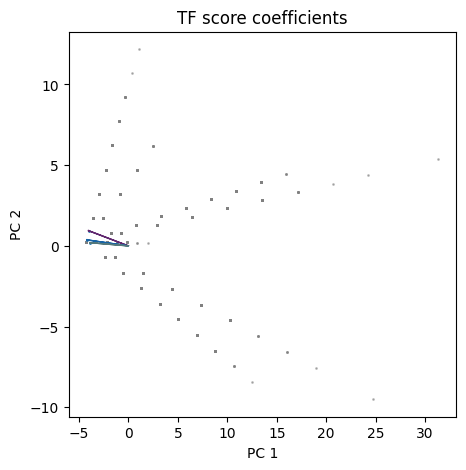

In [47]:
three_cols = ["#60276F", "#1663A5", "#53787B"]
fontsize = 12

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(reps_transformed[:, 0], reps_transformed[:, 1], s=1, c='grey', alpha=0.5)
plt.scatter(coefficients[:, 0], coefficients[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(coefficients.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], coefficients[i, 0], coefficients[i, 1], head_width=0.05, head_length=0.1, fc=three_cols[i], ec=three_cols[i])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('TF score coefficients', fontsize=fontsize)
plt.show()

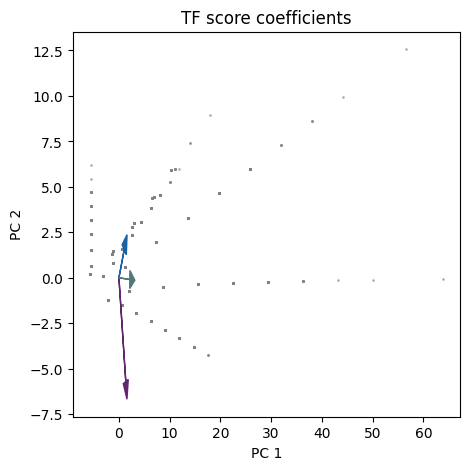

In [118]:
# try it for the model with 2 layers

# linear regression for the TF scores in the latent space and activations
reg_coeffs_reps = np.zeros((tf_scores.shape[1], reps.shape[1]))
reg_fits_reps = np.zeros(tf_scores.shape[1])

for i in range(tf_scores.shape[1]):
    reg = LinearRegression().fit(reps.cpu().detach().numpy(), tf_scores[:, i].cpu().detach().numpy())
    reg_fits_reps[i] = reg.score(reps.cpu().detach().numpy(), tf_scores[:, i].cpu().detach().numpy())
    reg_coeffs_reps[i,:] = reg.coef_

# make a PCA of the representations

pca = PCA(n_components=2)
reps_transformed = pca.fit_transform(reps.cpu().detach().numpy())
reps_mean = reps.cpu().detach().numpy().mean(axis=0)
# first repeat the mean for each tf score
reps_mean_plus_coefficients = np.repeat(reps_mean.reshape(1, -1), tf_scores.shape[1], axis=0)
# now add the coefficients
reps_mean_plus_coefficients += (reg_coeffs_reps * 10)

coefficients = pca.transform(reps_mean_plus_coefficients)
#coefficients = pca.transform(reg_coeffs_reps)

three_cols = ["#60276F", "#1663A5", "#53787B"]
fontsize = 12

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(reps_transformed[:, 0], reps_transformed[:, 1], s=1, c='grey', alpha=0.5)
plt.scatter(coefficients[:, 0], coefficients[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(coefficients.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], coefficients[i, 0], coefficients[i, 1], head_width=1, head_length=1, fc=three_cols[i], ec=three_cols[i])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('TF score coefficients', fontsize=fontsize)
plt.show()

In [82]:
reg_coeffs_reps

array([[-0.47622591,  0.41527167, -0.27211761, -1.38395631],
       [ 0.60251081,  0.05327847, -0.08271465, -0.24600589],
       [-0.98557115, -0.60121059,  0.2981922 ,  0.54013824]])

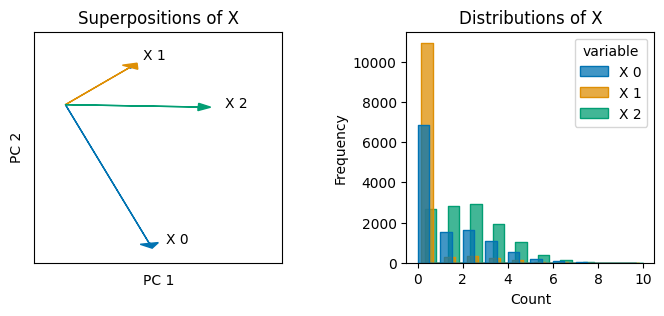

In [121]:
three_cols = sns.color_palette('colorblind', 3)
fontsize = 12

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)

axs[0].scatter(coefficients[:, 0], coefficients[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(coefficients.shape[0]):
    axs[0].arrow(mean[0][0], mean[0][1], coefficients[i, 0], coefficients[i, 1], head_width=0.3, head_length=0.2, fc=three_cols[i], ec=three_cols[i])
    # label the arrow
    axs[0].annotate('X {}'.format(i), (max(coefficients[i, 0],coefficients[i, 0]*1.2), max(coefficients[i, 1],coefficients[i, 1]*1.2)))
axs[0].set_xlim(-0.5, 3.5)
axs[0].set_ylim(-6.5, 3)
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
axs[0].set_title('Superpositions of X', fontsize=fontsize)
# remove the ticks
axs[0].set_xticks([])
axs[0].set_yticks([])
# next to that plot the histograms of X values
df_x = pd.DataFrame(tf_scores.cpu().detach().numpy(), columns=['X {}'.format(i) for i in range(tf_scores.shape[1])])
# long format
df_x_long = df_x.melt()
sns.histplot(data=df_x_long, x='value', hue='variable', ax=axs[1], bins=20, element='step', multiple='dodge', palette=three_cols)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distributions of X')
# make sure the x ticks stay integers
# define MaxNLocator object
from matplotlib.ticker import MaxNLocator
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

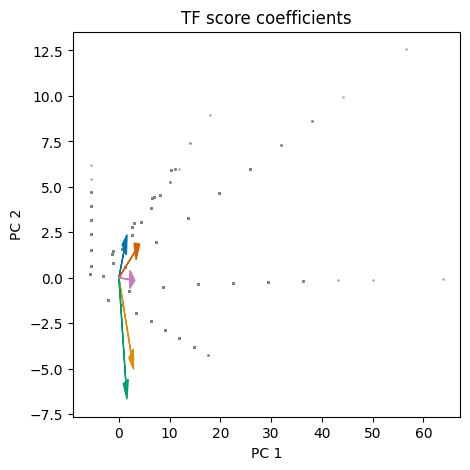

In [123]:
# same for the output data (sanity check)

# linear regression for the TF scores in the latent space and activations
reg_coeffs_reps = np.zeros((rna_counts.shape[1], reps.shape[1]))
reg_fits_reps = np.zeros(rna_counts.shape[1])

for i in range(rna_counts.shape[1]):
    reg = LinearRegression().fit(reps.cpu().detach().numpy(), rna_counts[:, i].cpu().detach().numpy())
    reg_fits_reps[i] = reg.score(reps.cpu().detach().numpy(), rna_counts[:, i].cpu().detach().numpy())
    reg_coeffs_reps[i,:] = reg.coef_

# make a PCA of the representations

pca = PCA(n_components=2)
reps_transformed = pca.fit_transform(reps.cpu().detach().numpy())
reps_mean = reps.cpu().detach().numpy().mean(axis=0)
# first repeat the mean for each tf score
reps_mean_plus_coefficients = np.repeat(reps_mean.reshape(1, -1), rna_counts.shape[1], axis=0)
# now add the coefficients
reps_mean_plus_coefficients += (reg_coeffs_reps * 10)

coefficients = pca.transform(reps_mean_plus_coefficients)
#coefficients = pca.transform(reg_coeffs_reps)

three_cols = sns.color_palette('colorblind', n_colors=10)
fontsize = 12

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(reps_transformed[:, 0], reps_transformed[:, 1], s=1, c='grey', alpha=0.5)
plt.scatter(coefficients[:, 0], coefficients[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(coefficients.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], coefficients[i, 0], coefficients[i, 1], head_width=1, head_length=1, fc=three_cols[i], ec=three_cols[i])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('TF score coefficients', fontsize=fontsize)
plt.show()

/tmp/ipykernel_471478/2255422991.py:22: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.histplot(data=df_x_long, x='value', hue='variable', ax=axs[1], bins=20, element='step', multiple='dodge', palette=three_cols, alpha=0.2)


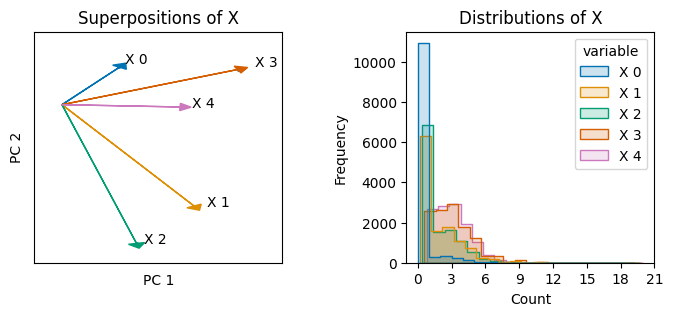

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)

axs[0].scatter(coefficients[:, 0], coefficients[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(coefficients.shape[0]):
    axs[0].arrow(mean[0][0], mean[0][1], coefficients[i, 0], coefficients[i, 1], head_width=0.3, head_length=0.2, fc=three_cols[i], ec=three_cols[i])
    # label the arrow
    axs[0].annotate('X {}'.format(i), (max(coefficients[i, 0],coefficients[i, 0]*1.1), max(coefficients[i, 1],coefficients[i, 1]*1.1)))
axs[0].set_xlim(-0.5, 4)
axs[0].set_ylim(-6.5, 3)
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
axs[0].set_title('Superpositions of X', fontsize=fontsize)
# remove the ticks
axs[0].set_xticks([])
axs[0].set_yticks([])
# next to that plot the histograms of X values
df_x = pd.DataFrame(rna_counts.cpu().detach().numpy(), columns=['X {}'.format(i) for i in range(rna_counts.shape[1])])
# long format
df_x_long = df_x.melt()
sns.histplot(data=df_x_long, x='value', hue='variable', ax=axs[1], bins=20, element='step', multiple='dodge', palette=three_cols, alpha=0.2)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distributions of X')
# make sure the x ticks stay integers
# define MaxNLocator object
from matplotlib.ticker import MaxNLocator
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

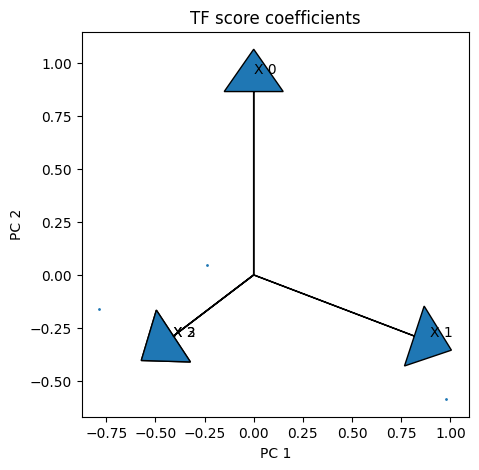

In [21]:
# try it for the model with 2 layers

# linear regression for the TF scores in the latent space and activations
reg_coeffs_reps = np.zeros((tf_scores.shape[1], reps.shape[1]))
reg_fits_reps = np.zeros(tf_scores.shape[1])

for i in range(tf_scores.shape[1]):
    reg = LinearRegression().fit(reps.cpu().detach().numpy(), tf_scores[:, i].cpu().detach().numpy())
    reg_fits_reps[i] = reg.score(reps.cpu().detach().numpy(), tf_scores[:, i].cpu().detach().numpy())
    reg_coeffs_reps[i,:] = reg.coef_

# make a PCA of the representations

priviledged_bases = np.zeros((reps.shape[1], reps.shape[1]))
for i in range(reps.shape[1]):
    priviledged_bases[i, i] = 1

pca = PCA(n_components=2)
pca.fit(priviledged_bases)
#reps_transformed = pca.fit_transform(reps.cpu().detach().numpy())
reps_mean = reps.cpu().detach().numpy().mean(axis=0)
# first repeat the mean for each tf score
reps_mean_plus_coefficients = np.repeat(reps_mean.reshape(1, -1), tf_scores.shape[1], axis=0)
# now add the coefficients
reps_mean_plus_coefficients += (reg_coeffs_reps)

#coefficients = pca.transform(reps_mean_plus_coefficients)
coefficients = pca.transform(reg_coeffs_reps)

priviledged_bases_transformed = pca.transform(priviledged_bases)

three_cols = ["#60276F", "#1663A5", "#53787B"]
fontsize = 12

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
#plt.scatter(reps_transformed[:, 0], reps_transformed[:, 1], s=1, c='grey', alpha=0.5)
plt.scatter(coefficients[:, 0], coefficients[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(priviledged_bases_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], priviledged_bases_transformed[i, 0], priviledged_bases_transformed[i, 1], head_width=0.3, head_length=0.2)
    # label the arrow
    plt.annotate('X {}'.format(i), 
                 (
                     max(priviledged_bases_transformed[i, 0],priviledged_bases_transformed[i, 0]*1.1), 
                     max(priviledged_bases_transformed[i, 1],priviledged_bases_transformed[i, 1]*1.1))
                )
#for i in range(coefficients.shape[0]):
#    plt.arrow(mean[0][0], mean[0][1], coefficients[i, 0], coefficients[i, 1], head_width=1, head_length=1, fc=three_cols[i], ec=three_cols[i])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('TF score coefficients', fontsize=fontsize)
plt.show()

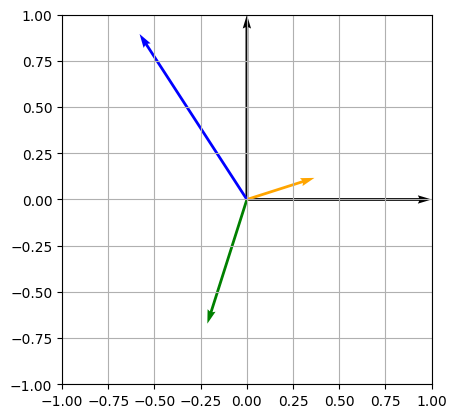

In [22]:
basis_vectors = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

projection_matrix = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

projected_basis_vectors = projection_matrix @ basis_vectors.T

superposition_vectors = reg_coeffs_reps

projected_superpositions = [projection_matrix @ v for v in superposition_vectors]

# Start plotting
fig, ax = plt.subplots()

# Plot the privileged basis vectors (black arrows)
for i in range(projected_basis_vectors.shape[1]):
    ax.quiver(0, 0, projected_basis_vectors[0, i], projected_basis_vectors[1, i], 
              angles='xy', scale_units='xy', scale=1, color='black')

# Plot the superposition vectors (colored arrows)
colors = ['orange', 'blue', 'green', 'red']
for i, vec in enumerate(projected_superpositions):
    ax.quiver(0, 0, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color=colors[i])

# Set equal scaling for both axes and display the grid
ax.set_aspect('equal')
ax.grid(True)

# Set axis limits for better view
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

plt.show()

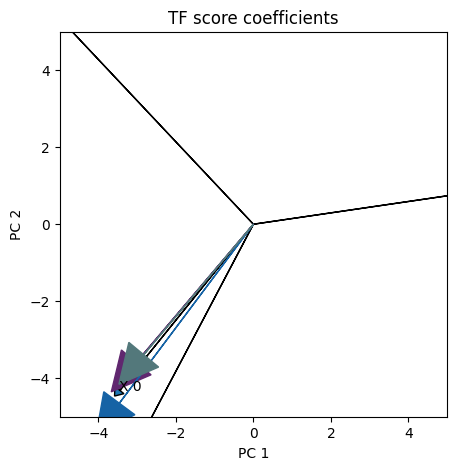

In [33]:
basis_vectors = np.zeros((reps.shape[1], reps.shape[1]))
for i in range(reps.shape[1]):
    basis_vectors[i, i] = max(reps[:,i])

# make a pca of the basis vectors

pca = PCA(n_components=2)
# fit the pca to both the basis vectors and the coefficients
pca.fit(basis_vectors)
basis_vectors_transformed = pca.transform(basis_vectors)
# transform the coefficients
coefficients_transformed = pca.transform(reg_coeffs_reps)

three_cols = ["#60276F", "#1663A5", "#53787B"]
fontsize = 12

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(basis_vectors_transformed[:, 0], basis_vectors_transformed[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(basis_vectors_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], basis_vectors_transformed[i, 0], basis_vectors_transformed[i, 1], head_width=0.3, head_length=0.2)
    # label the arrow
    plt.annotate('X {}'.format(i), 
                 (
                     max(basis_vectors_transformed[i, 0],basis_vectors_transformed[i, 0]*1.1), 
                     max(basis_vectors_transformed[i, 1],basis_vectors_transformed[i, 1]*1.1))
                )
for i in range(coefficients_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], coefficients_transformed[i, 0], coefficients_transformed[i, 1], head_width=1, head_length=1, fc=three_cols[i], ec=three_cols[i])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.ylim(-5, 5)
plt.xlim(-5, 5)
plt.title('TF score coefficients', fontsize=fontsize)
plt.show()

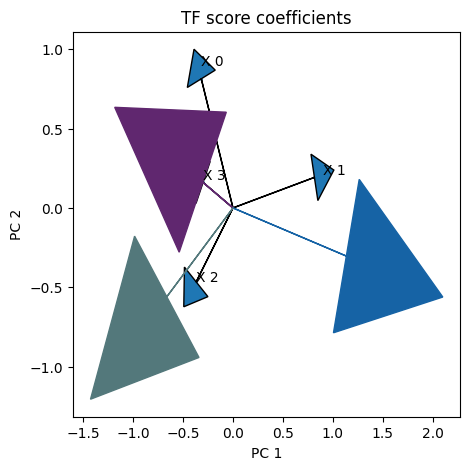

In [27]:
basis_vectors = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# make a pca of the basis vectors

pca = PCA(n_components=2)
# fit the pca to both the basis vectors and the coefficients
pca.fit(np.vstack([basis_vectors, reg_coeffs_reps]))
basis_vectors_transformed = pca.transform(basis_vectors)
# transform the coefficients
coefficients_transformed = pca.transform(reg_coeffs_reps)

three_cols = ["#60276F", "#1663A5", "#53787B"]
fontsize = 12

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(basis_vectors_transformed[:, 0], basis_vectors_transformed[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(basis_vectors_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], basis_vectors_transformed[i, 0], basis_vectors_transformed[i, 1], head_width=0.3, head_length=0.2)
    # label the arrow
    plt.annotate('X {}'.format(i), 
                 (
                     max(basis_vectors_transformed[i, 0],basis_vectors_transformed[i, 0]*1.1), 
                     max(basis_vectors_transformed[i, 1],basis_vectors_transformed[i, 1]*1.1))
                )
for i in range(coefficients_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], coefficients_transformed[i, 0], coefficients_transformed[i, 1], head_width=1, head_length=1, fc=three_cols[i], ec=three_cols[i])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('TF score coefficients', fontsize=fontsize)
plt.show()

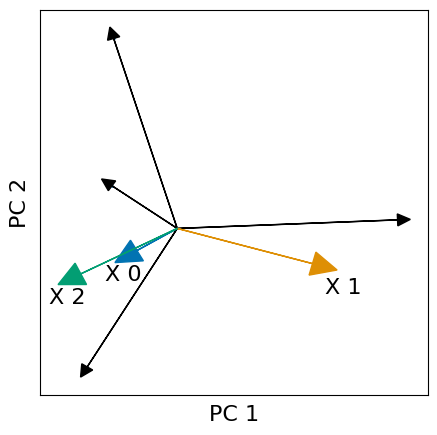

In [70]:
basis_vectors = np.array([
    [1, -1, -1, -1],
    [-1, 1, -1, -1],
    [-1, -1, 1, -1],
    [-1, -1, -1, 1]
])

# make a pca of the basis vectors

pca = PCA(n_components=2)
# fit the pca to both the basis vectors and the coefficients
pca.fit(np.vstack([basis_vectors, reg_coeffs_reps]))
basis_vectors_transformed = pca.transform(basis_vectors)
# transform the coefficients
coefficients_transformed = pca.transform(reg_coeffs_reps)

three_cols = sns.color_palette('colorblind', 3)
fontsize = 16
# set the fontsize
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(basis_vectors_transformed[:, 0], basis_vectors_transformed[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(basis_vectors_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], basis_vectors_transformed[i, 0], basis_vectors_transformed[i, 1], head_width=0.1, head_length=0.1, fc='black', ec='black')
for i in range(coefficients_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], coefficients_transformed[i, 0], coefficients_transformed[i, 1], head_width=0.2, head_length=0.2, fc=three_cols[i], ec=three_cols[i])
    # label
    if coefficients_transformed[i, 0] < 0:
        x_annot = coefficients_transformed[i, 0] - 0.25
    else:
        x_annot = coefficients_transformed[i, 0] + 0.1
    if coefficients_transformed[i, 1] < 0:
        y_annot = coefficients_transformed[i, 1] - 0.25
    else:
        y_annot = coefficients_transformed[i, 1] + 0.25
    plt.annotate('X {}'.format(i), (x_annot, y_annot))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# remove the ticks
plt.xticks([])
plt.yticks([])
#plt.title('TF score coefficients', fontsize=fontsize)
plt.show()

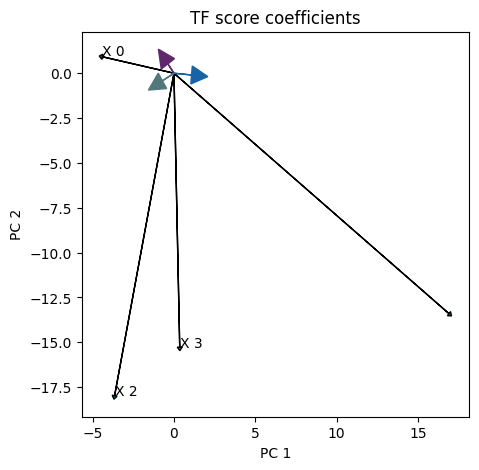

In [36]:
basis_vectors = np.zeros((reps.shape[1], reps.shape[1]))
for i in range(reps.shape[1]):
    for j in range(reps.shape[1]):
        if i == j:
            basis_vectors[i, j] = max(reps[:,i])
        else:
            basis_vectors[i, j] = min(reps[:,j])


pca = PCA(n_components=2)
# fit the pca to both the basis vectors and the coefficients
pca.fit(reg_coeffs_reps)
basis_vectors_transformed = pca.transform(basis_vectors)
# transform the coefficients
coefficients_transformed = pca.transform(reg_coeffs_reps)

three_cols = ["#60276F", "#1663A5", "#53787B"]
fontsize = 12

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(basis_vectors_transformed[:, 0], basis_vectors_transformed[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(basis_vectors_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], basis_vectors_transformed[i, 0], basis_vectors_transformed[i, 1], head_width=0.3, head_length=0.2)
    # label the arrow
    plt.annotate('X {}'.format(i), 
                 (
                     max(basis_vectors_transformed[i, 0],basis_vectors_transformed[i, 0]*1.1), 
                     max(basis_vectors_transformed[i, 1],basis_vectors_transformed[i, 1]*1.1))
                )
for i in range(coefficients_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], coefficients_transformed[i, 0], coefficients_transformed[i, 1], head_width=1, head_length=1, fc=three_cols[i], ec=three_cols[i])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('TF score coefficients', fontsize=fontsize)
plt.show()

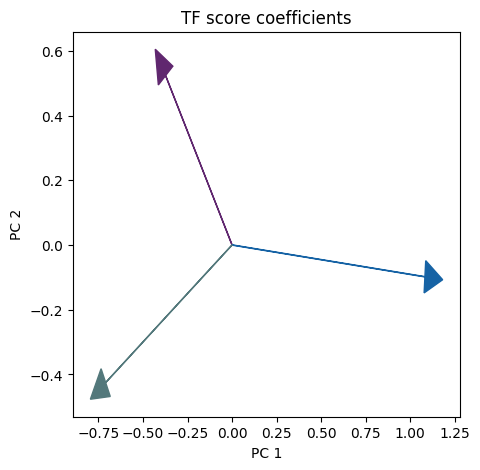

In [40]:
pca = PCA(n_components=2)
# fit the pca to both the basis vectors and the coefficients
pca.fit(reg_coeffs_reps)
# transform the coefficients
coefficients_transformed = pca.transform(reg_coeffs_reps)

three_cols = ["#60276F", "#1663A5", "#53787B"]
fontsize = 12

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(coefficients_transformed.shape[0]):
    plt.arrow(mean[0][0], mean[0][1], coefficients_transformed[i, 0], coefficients_transformed[i, 1], head_width=0.1, head_length=0.1, fc=three_cols[i], ec=three_cols[i])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('TF score coefficients', fontsize=fontsize)
plt.show()

In [25]:
reg_coeffs_reps

array([[ 0.36561039,  0.11681932,  0.47837567,  0.33480182],
       [-0.58077657,  0.8954134 , -0.22765833, -0.37638611],
       [-0.21399508, -0.6721195 ,  0.479406  ,  0.10106188]])

In [19]:
priviledged_bases

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

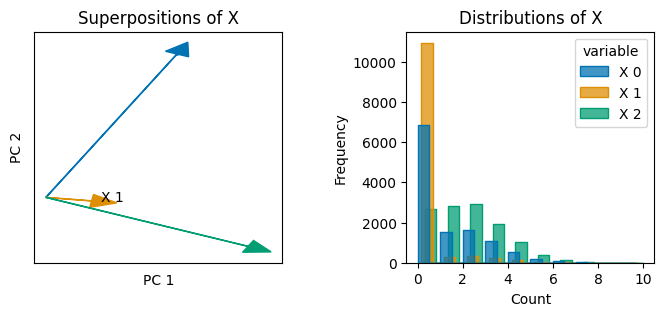

In [14]:
three_cols = sns.color_palette('colorblind', 3)
fontsize = 12

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)

axs[0].scatter(coefficients[:, 0], coefficients[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(coefficients.shape[0]):
    axs[0].arrow(mean[0][0], mean[0][1], coefficients[i, 0], coefficients[i, 1], head_width=0.05, head_length=0.05, fc=three_cols[i], ec=three_cols[i])
    # label the arrow
    axs[0].annotate('X {}'.format(i), (max(coefficients[i, 0],coefficients[i, 0]*1.2), max(coefficients[i, 1],coefficients[i, 1]*1.2)))
#axs[0].set_xlim(-0.5, 3.5)
#axs[0].set_ylim(-6.5, 3)
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
axs[0].set_title('Superpositions of X', fontsize=fontsize)
# remove the ticks
axs[0].set_xticks([])
axs[0].set_yticks([])
# next to that plot the histograms of X values
df_x = pd.DataFrame(tf_scores.cpu().detach().numpy(), columns=['X {}'.format(i) for i in range(tf_scores.shape[1])])
# long format
df_x_long = df_x.melt()
sns.histplot(data=df_x_long, x='value', hue='variable', ax=axs[1], bins=20, element='step', multiple='dodge', palette=three_cols)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distributions of X')
# make sure the x ticks stay integers
# define MaxNLocator object
from matplotlib.ticker import MaxNLocator
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

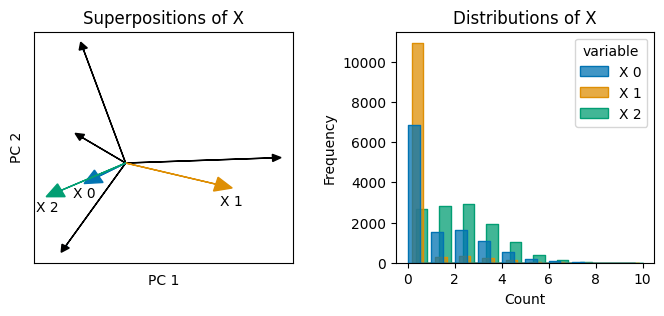

In [81]:
basis_vectors = np.array([
    [1, -1, -1, -1],
    [-1, 1, -1, -1],
    [-1, -1, 1, -1],
    [-1, -1, -1, 1]
])

# make a pca of the basis vectors

pca = PCA(n_components=2)
# fit the pca to both the basis vectors and the coefficients
pca.fit(np.vstack([basis_vectors, reg_coeffs_reps]))
basis_vectors_transformed = pca.transform(basis_vectors)
# transform the coefficients
coefficients_transformed = pca.transform(reg_coeffs_reps)

three_cols = sns.color_palette('colorblind', 3)
fontsize = 12
# set the fontsize
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.4)

mean = pca.transform(pca.mean_.reshape(1, -1))
axs[0].scatter(basis_vectors_transformed[:, 0], basis_vectors_transformed[:, 1], s=1)
mean = pca.transform(pca.mean_.reshape(1, -1))
for i in range(basis_vectors_transformed.shape[0]):
    axs[0].arrow(
        mean[0][0], mean[0][1], 
        basis_vectors_transformed[i, 0], basis_vectors_transformed[i, 1], 
        head_width=0.1, head_length=0.1, fc='black', ec='black'
        )
for i in range(coefficients_transformed.shape[0]):
    axs[0].arrow(
        mean[0][0], mean[0][1], 
        coefficients_transformed[i, 0], coefficients_transformed[i, 1], 
        head_width=0.2, head_length=0.2, fc=three_cols[i], ec=three_cols[i]
        )
    # label
    if coefficients_transformed[i, 0] < 0:
        x_annot = coefficients_transformed[i, 0] - 0.3
    else:
        x_annot = coefficients_transformed[i, 0] + 0.05
    if coefficients_transformed[i, 1] < 0:
        y_annot = coefficients_transformed[i, 1] - 0.3
    else:
        y_annot = coefficients_transformed[i, 1] + 0.25
    axs[0].annotate('X {}'.format(i), (x_annot, y_annot))
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
axs[0].set_title('Superpositions of X', fontsize=fontsize)
# remove the ticks
axs[0].set_xticks([])
axs[0].set_yticks([])
# next to that plot the histograms of X values
df_x = pd.DataFrame(tf_scores.cpu().detach().numpy(), columns=['X {}'.format(i) for i in range(tf_scores.shape[1])])
# long format
df_x_long = df_x.melt()
sns.histplot(data=df_x_long, x='value', hue='variable', ax=axs[1], bins=20, element='step', multiple='dodge', palette=three_cols)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distributions of X')
# make sure the x ticks stay integers
# define MaxNLocator object
from matplotlib.ticker import MaxNLocator
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

# save the figure as pdf
fig.savefig('03_results/reports/figures/sim1_latent4_tf_score_coefficients_and_distributions.pdf', bbox_inches='tight')

### metrics

In [143]:
df_sae_metrics.head()

hidden_factor    lr  l1_weight  sparsity_penalty      loss  \
0              2  0.01       0.10           0.00100  0.006121   
1              2  0.01       0.10           0.00010  0.004826   
2              2  0.01       0.10           0.00001  0.006519   
3              2  0.01       0.10           0.00000  0.005061   
4              2  0.01       0.01           0.00100  0.001836   

   n_activation_features  n_unique  avg_active_hidden_units  n_redundant  \
0                      8         3                 1.521333            0   
1                      8         4                 1.413167            0   
2                      8         4                 0.959167            0   
3                      8         4                 1.512833            0   
4                      8         3                 2.299583            0   

   n_per_rna  n_per_tf  n_per_activity  n_per_accessibility  \
0        0.8  1.000000             0.0                  0.0   
1        0.4  0.666667             0.0                  0.0   
2        0.4  0.666667             0.0                  0.0   
3        0.6  0.666667             0.0                  0.0   
4        0.8  1.000000             0.0                  0.0   

   highest_corrs_rna  highest_corrs_tf  highest_corrs_activity  \
0           0.967846          0.994862                0.867839   
1           0.956051          0.982154                0.870009   
2           0.792469          0.828493                0.501848   
3           0.956191          0.973341                0.840737   
4           0.973602          0.993318                0.866983   

   highest_corrs_accessibility  
0                     0.630040  
1                     0.289326  
2                     0.367584  
3                     0.287931  
4                     0.626854

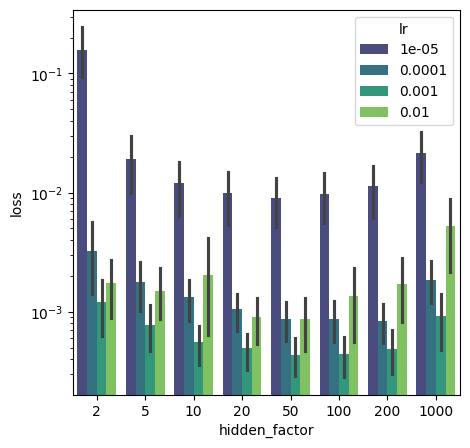

In [150]:
# plot the loss over the different hyperparameters
hue = 'loss'
x = 'hidden_factor'
y = 'lr'

lr_palette = sns.color_palette('viridis', n_colors=len(lr_options))

fig, axs = plt.subplots(1, 1, figsize=(5,5))
sns.barplot(data=df_sae_metrics, x=x, y=hue, hue=y, ax=axs, palette=lr_palette)
plt.yscale('log')
plt.show()

/tmp/ipykernel_615856/1228233752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sae_metrics_lr3['n_activation_features'] = df_sae_metrics_lr3['n_activation_features'].astype(str)


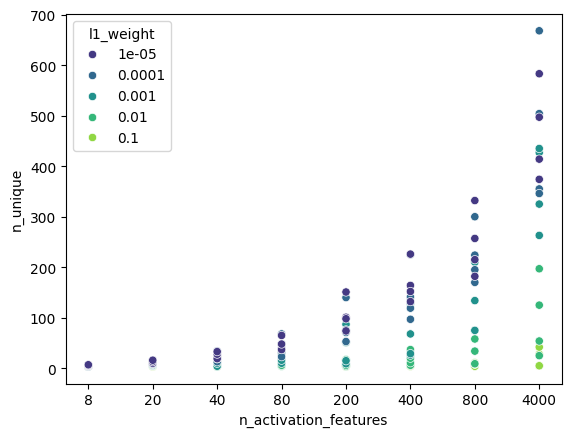

In [7]:
value_palette = sns.color_palette('viridis', n_colors=len(l1_weight_options))

df_sae_metrics_lr3 = df_sae_metrics[df_sae_metrics['lr'] == 1e-3]
df_sae_metrics_lr3['n_activation_features'] = df_sae_metrics_lr3['n_activation_features'].astype(str)

sns.scatterplot(data=df_sae_metrics_lr3, x='n_activation_features', y='n_unique', hue='l1_weight', palette=value_palette)
plt.show()

/tmp/ipykernel_471478/3674646327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sae_metrics_lr3['fraction_unique'] = df_sae_metrics_lr3['n_unique'] / df_sae_metrics_lr3['n_activation_features']
/tmp/ipykernel_471478/3674646327.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sae_metrics_lr3['fraction_redundant'] = df_sae_metrics_lr3['n_redundant'] / df_sae_metrics_lr3['n_activation_features']
/tmp/ipykernel_471478/3674646327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

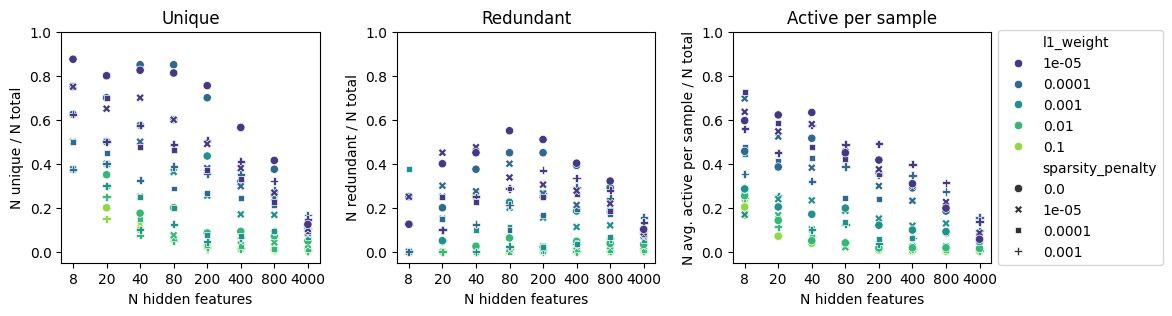

In [165]:
# figure with 3 subplots

df_sae_metrics_lr3 = df_sae_metrics[df_sae_metrics['lr'] == 1e-3]
df_sae_metrics_lr3['fraction_unique'] = df_sae_metrics_lr3['n_unique'] / df_sae_metrics_lr3['n_activation_features']
df_sae_metrics_lr3['fraction_redundant'] = df_sae_metrics_lr3['n_redundant'] / df_sae_metrics_lr3['n_activation_features']
df_sae_metrics_lr3['fraction_active_per_sample'] = df_sae_metrics_lr3['avg_active_hidden_units'] / df_sae_metrics_lr3['n_activation_features']
# make hidden factor a categorical variable
df_sae_metrics_lr3['hidden_factor'] = df_sae_metrics_lr3['hidden_factor'].astype(str)
df_sae_metrics_lr3['n_activation_features'] = df_sae_metrics_lr3['n_activation_features'].astype(str)

x = 'n_activation_features'
y = ['fraction_unique', 'fraction_redundant', 'fraction_active_per_sample']
y_titles = ['Unique', 'Redundant', 'Active per sample']
y_labels = ['N unique / N total', 'N redundant / N total', 'N avg. active per sample / N total']
hue = 'l1_weight'
point_style = 'sparsity_penalty'

value_palette = sns.color_palette('viridis', n_colors=len(l1_weight_options))

fig, axs = plt.subplots(1, len(y), figsize=(len(y)*4, 3))
plt.subplots_adjust(wspace=0.3)

for i, y_val in enumerate(y):
    sns.scatterplot(data=df_sae_metrics_lr3, x=x, y=y_val, hue=hue, style=point_style, ax=axs[i], palette=value_palette)
    axs[i].set_title(y_titles[i])
    axs[i].set_ylabel(y_labels[i])
    axs[i].set_xlabel('N hidden features')
    axs[i].set_ylim(-0.05, 1)
    if i < len(y) - 1:
        axs[i].get_legend().remove()
    else:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

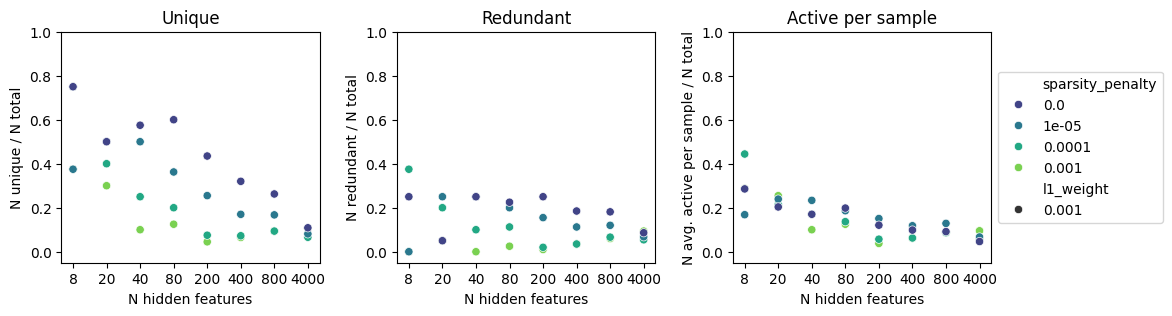

In [167]:
value_palette = sns.color_palette('viridis', n_colors=len(sparsity_penalty_options))

fig, axs = plt.subplots(1, len(y), figsize=(len(y)*4, 3))
plt.subplots_adjust(wspace=0.3)

for i, y_val in enumerate(y):
    sns.scatterplot(data=df_sae_metrics_lr3[df_sae_metrics_lr3['l1_weight'] == 1e-3], x=x, y=y_val, hue=point_style, style=hue, ax=axs[i], palette=value_palette)
    axs[i].set_title(y_titles[i])
    axs[i].set_ylabel(y_labels[i])
    axs[i].set_xlabel('N hidden features')
    axs[i].set_ylim(-0.05, 1)
    if i < len(y) - 1:
        axs[i].get_legend().remove()
    else:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/tmp/ipykernel_471478/4204504273.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sae_metrics_lr3['l1_weight'] = df_sae_metrics_lr3['l1_weight'].astype(str)
/tmp/ipykernel_471478/4204504273.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sae_metrics_lr3['sparsity_penalty'] = df_sae_metrics_lr3['sparsity_penalty'].astype(str)


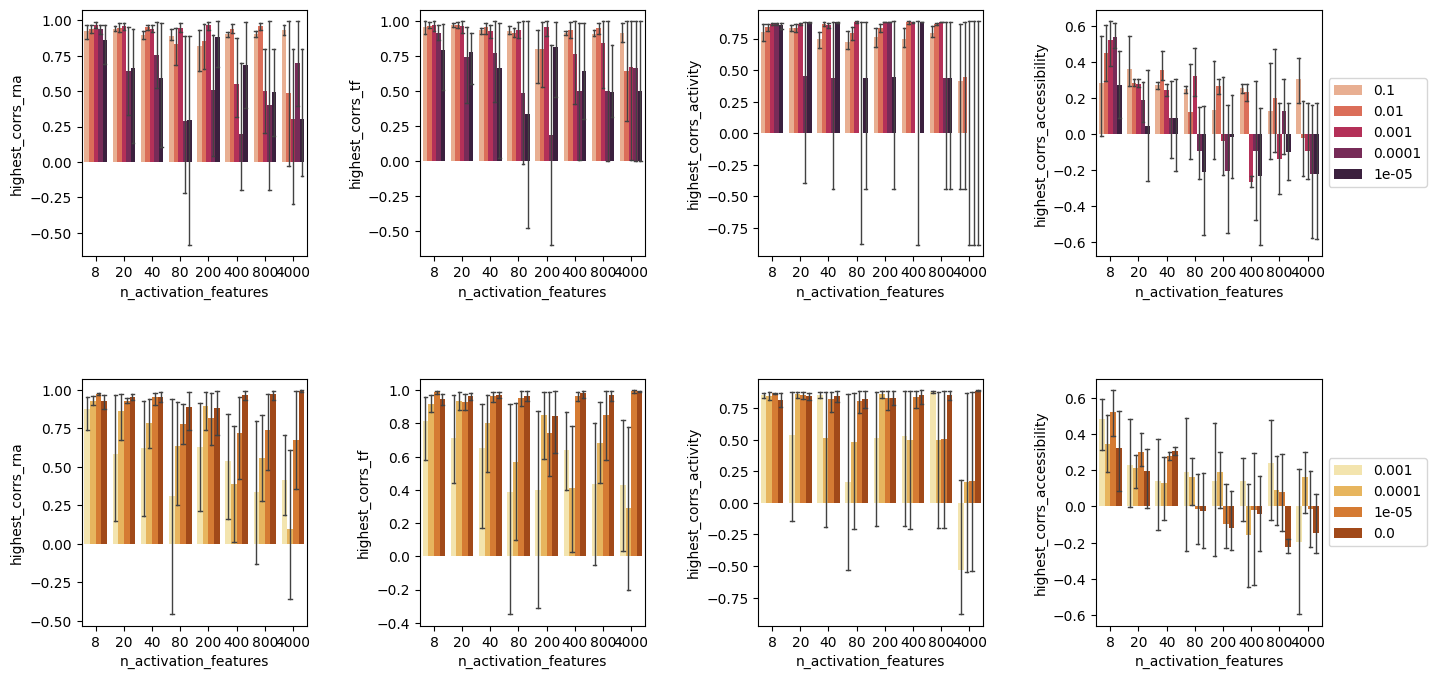

In [188]:
# plot the loss over the different hyperparameters
hue = [i for i in df_sae_metrics.columns if 'highest' in i]
x = 'n_activation_features'
y1 = 'l1_weight'
y2 = 'sparsity_penalty'

l1_palette = sns.color_palette('rocket_r', n_colors=len(l1_weight_options))
sparse_palette = sns.color_palette('YlOrBr', n_colors=len(sparsity_penalty_options))

df_sae_metrics_lr3['l1_weight'] = df_sae_metrics_lr3['l1_weight'].astype(str)
df_sae_metrics_lr3['sparsity_penalty'] = df_sae_metrics_lr3['sparsity_penalty'].astype(str)

fig, axs = plt.subplots(2, len(hue), figsize=(len(hue)*4, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, hue_val in enumerate(hue):
    sns.barplot(data=df_sae_metrics_lr3, x=x, y=hue_val, hue=y1, ax=axs[0][i], err_kws={'linewidth': 1}, capsize=0.5, palette=l1_palette)
    sns.barplot(data=df_sae_metrics_lr3, x=x, y=hue_val, hue=y2, ax=axs[1][i], err_kws={'linewidth': 1}, capsize=0.5, palette=sparse_palette)
    if i < len(hue) - 1:
        axs[0][i].get_legend().remove()
        axs[1][i].get_legend().remove()
    else:
        axs[0][i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[1][i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/tmp/ipykernel_471478/3579698931.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sae_metrics_lr3['l1_weight'] = df_sae_metrics_lr3['l1_weight'].astype(str)
/tmp/ipykernel_471478/3579698931.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sae_metrics_lr3['sparsity_penalty'] = df_sae_metrics_lr3['sparsity_penalty'].astype(str)


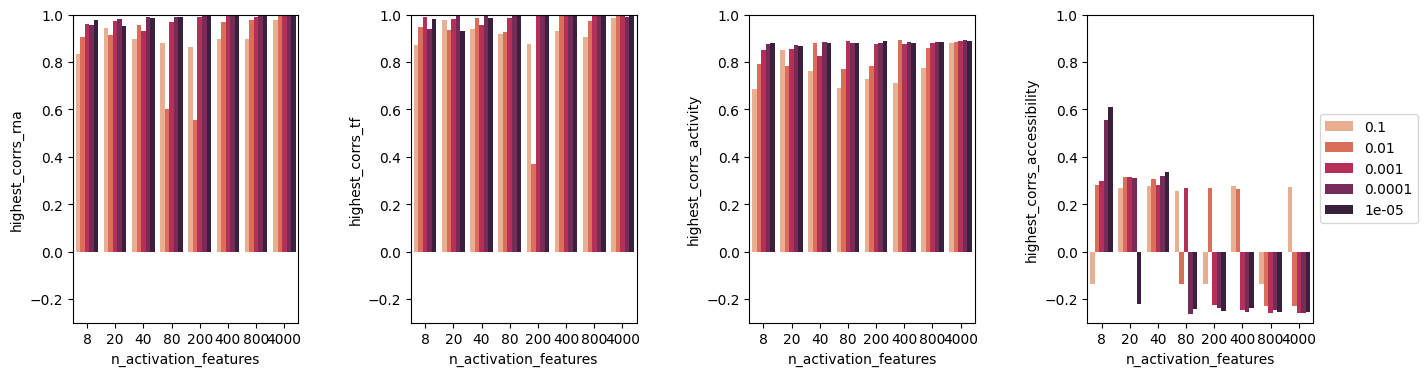

In [198]:
# plot the loss over the different hyperparameters
hue = [i for i in df_sae_metrics.columns if 'highest' in i]
x = 'n_activation_features'
y1 = 'l1_weight'
y2 = 'sparsity_penalty'

l1_palette = sns.color_palette('rocket_r', n_colors=len(l1_weight_options))
sparse_palette = sns.color_palette('YlOrBr', n_colors=len(sparsity_penalty_options))

df_sae_metrics_lr3['l1_weight'] = df_sae_metrics_lr3['l1_weight'].astype(str)
df_sae_metrics_lr3['sparsity_penalty'] = df_sae_metrics_lr3['sparsity_penalty'].astype(str)

fig, axs = plt.subplots(1, len(hue), figsize=(len(hue)*4, 4))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, hue_val in enumerate(hue):
    sns.barplot(data=df_sae_metrics_lr3[df_sae_metrics_lr3['sparsity_penalty'] == '0.0'], x=x, y=hue_val, hue=y1, ax=axs[i], err_kws={'linewidth': 1}, capsize=0.5, palette=l1_palette)
    axs[i].set_ylim(-0.3, 1.0)
    if i < len(hue) - 1:
        axs[i].get_legend().remove()
    else:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [193]:
df_sae_metrics_lr3['sparsity_penalty']

20      0.001
21     0.0001
22      1e-05
23        0.0
24      0.001
        ...  
595       0.0
596     0.001
597    0.0001
598     1e-05
599       0.0
Name: sparsity_penalty, Length: 160, dtype: object

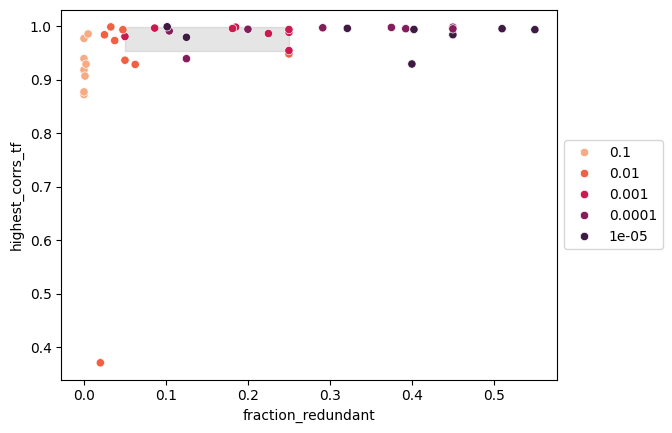

In [211]:
# plot the fraction of redundancy against the correlation for tf and activity
df_temp = df_sae_metrics_lr3[(df_sae_metrics_lr3['sparsity_penalty'] == '0.0') & (df_sae_metrics_lr3['l1_weight'] == '0.001')]

x_min, x_max = df_temp['fraction_redundant'].min(), df_temp['fraction_redundant'].max()
y_min, y_max = df_temp['highest_corrs_tf'].min(), df_temp['highest_corrs_tf'].max()

plt.fill_between([x_min, x_max], [y_min, y_min], [y_max, y_max], color='grey', alpha=0.2)
sns.scatterplot(data=df_sae_metrics_lr3[df_sae_metrics_lr3['sparsity_penalty'] == '0.0'], x='fraction_redundant', y='highest_corrs_tf', hue='l1_weight', palette=l1_palette)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

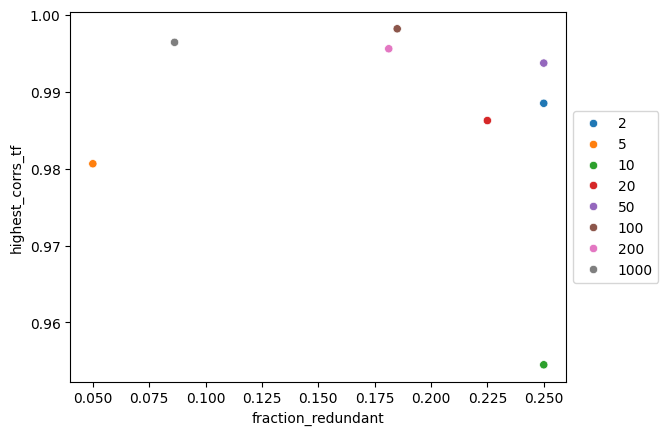

In [205]:
# plot the fraction of redundancy against the correlation for tf and activity

sns.scatterplot(data=df_sae_metrics_lr3[(df_sae_metrics_lr3['sparsity_penalty'] == '0.0') & (df_sae_metrics_lr3['l1_weight'] == '0.001')], x='fraction_redundant', y='highest_corrs_tf', hue='hidden_factor')
# take legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [212]:
best_model = df_sae_metrics_lr3[
    (df_sae_metrics_lr3['sparsity_penalty'] == '0.0') & 
    (df_sae_metrics_lr3['l1_weight'] == '0.001') &
    (df_sae_metrics_lr3['hidden_factor'] == '100')
]

best_model

hidden_factor     lr l1_weight sparsity_penalty      loss  \
431           100  0.001     0.001              0.0  0.000082   

    n_activation_features  n_unique  avg_active_hidden_units  n_redundant  \
431                   400       128                 39.36525           74   

     n_per_rna  n_per_tf  n_per_activity  n_per_accessibility  \
431        5.2       7.0             0.0                  0.0   

     highest_corrs_rna  highest_corrs_tf  highest_corrs_activity  \
431           0.992948          0.998182                0.877839   

     highest_corrs_accessibility  fraction_unique  fraction_redundant  \
431                    -0.246402             0.32               0.185   

     fraction_active_per_sample  
431                    0.098413

### metrics2

In [238]:
df_sae_metrics = pd.read_csv('03_results/reports/files/sim_modl1l4_sae_metrics.csv')
# remove all rows with sparsity penalty > 0
df_sae_metrics = df_sae_metrics[df_sae_metrics['sparsity_penalty'] == 0.0]
df_sae_metrics['type'] = 'Vanilla'

df_sae_metrics_relu = pd.read_csv('03_results/reports/files/sim_modl1l4_sae-bricken2_metrics.csv')
df_sae_metrics_relu['type'] = 'ReLU'
df_sae_metrics = pd.concat([df_sae_metrics, df_sae_metrics_relu])

df_sae_metrics_topk = pd.read_csv('03_results/reports/files/sim_modl1l4_sae-topK_metrics.csv')
df_sae_metrics_topk['type'] = 'TopK'
df_sae_metrics = pd.concat([df_sae_metrics, df_sae_metrics_topk])

hidden_factor_options = [2, 5, 10, 20, 50, 100, 200, 1000]
lr_options = [1e-2, 1e-3, 1e-4, 1e-5]
l1_weight_options = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
k_options = [1, 5, 10, 20, 50, 75, 100]

In [239]:
df_sae_metrics['k'] = df_sae_metrics['k'].fillna(0)
df_sae_metrics['k'] = df_sae_metrics['k'].astype(int)
df_sae_metrics['k'] = df_sae_metrics['k'].astype(str)
#df_sae_metrics['l1_weight'] = df_sae_metrics['l1_weight'].fillna(0)
df_sae_metrics['l1_weight'] = df_sae_metrics['l1_weight'].astype(str)

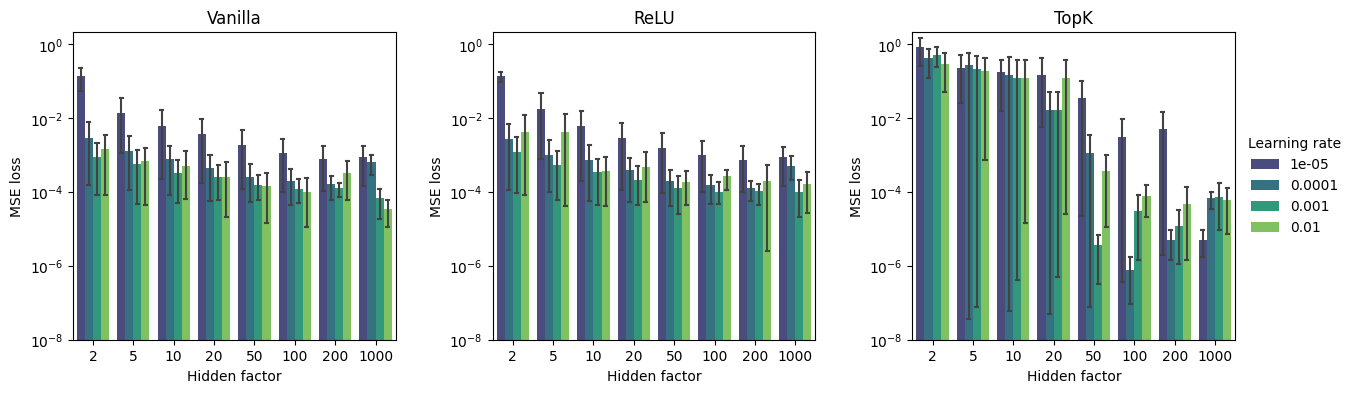

In [38]:
# plot the loss over the different hyperparameters
hue = 'loss'
x = 'hidden_factor'
y = 'lr'

lr_palette = sns.color_palette('viridis', n_colors=len(lr_options))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.3)
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], palette=lr_palette, err_kws={'linewidth': 1.5}, capsize=0.3)
    axs[i].set_ylim(1e-8, df_sae_metrics['loss'].max())
    axs[i].set_yscale('log')
    axs[i].set_title(t)
    axs[i].set_xlabel('Hidden factor')
    axs[i].set_ylabel('MSE loss')
    if i < 2:
        axs[i].get_legend().remove()
    else:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Learning rate')
plt.show()

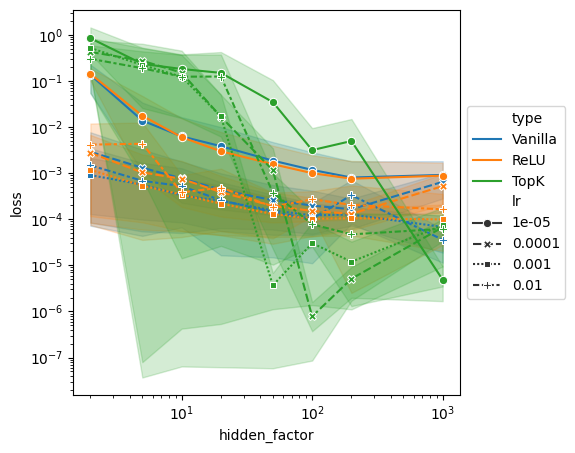

In [91]:
# make one plot with the loss as a function of the hidden factor for the different types (lineplot)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=df_sae_metrics, x='hidden_factor', y='loss', hue='type', style='lr', markers=True)
plt.yscale('log')
plt.xscale('log')
# take the legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

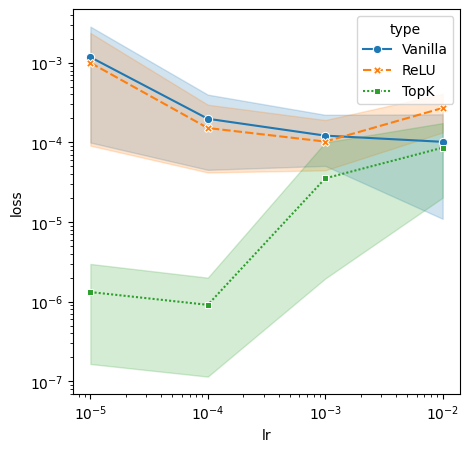

In [243]:
df_temp = df_sae_metrics.copy()
df_temp = df_temp[df_temp['k'] != '1']
df_temp = df_temp[df_temp['hidden_factor'] == 100]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=df_temp, x='lr', y='loss', hue='type', style='type', markers=True, ax=ax)
plt.yscale('log')
plt.xscale('log')

plt.show()

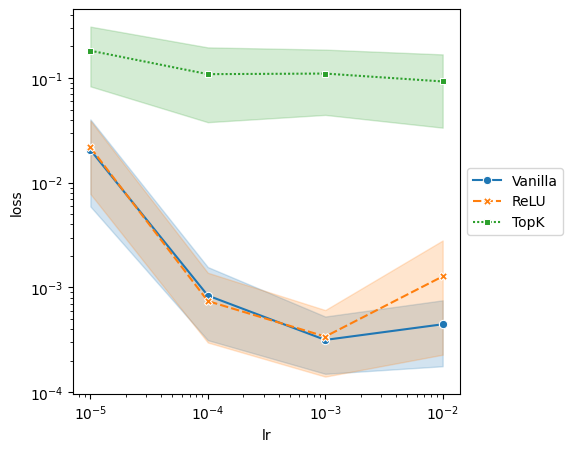

In [235]:
# make one plot with the loss as a function of the hidden factor for the different types (lineplot)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=df_sae_metrics, x='lr', y='loss', hue='type', style='type', markers=True)
plt.yscale('log')
plt.xscale('log')
# take the legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Vanilla and ReLU losses seem more robust, but generally higher than some TopK models. TopK seems to do best with large hidden sizes. For a fixed number of epochs, the learning rate is rather chosen one step too big than too small.

/tmp/ipykernel_1405467/2896672444.py:14: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)
/tmp/ipykernel_1405467/2896672444.py:14: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)


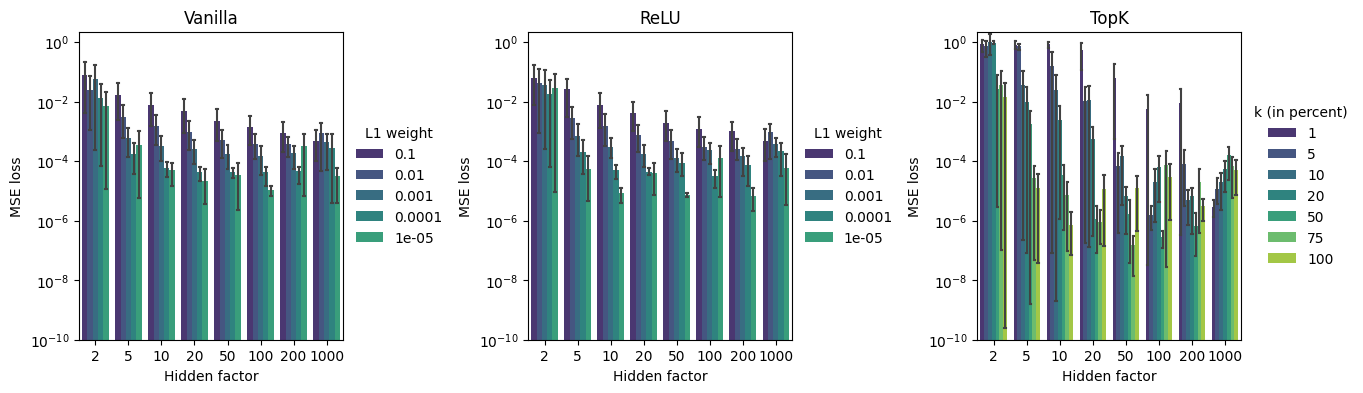

In [34]:
# plot the loss over the different hyperparameters
hue = 'loss'
x = 'hidden_factor'
y = 'l1_weight'

#lr_palette = sns.color_palette('viridis', n_colors=len(lr_options))
cmap_palette = sns.color_palette('viridis', n_colors=max(len(l1_weight_options), len(k_options)))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.7)
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        y = 'k'
    sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)
    axs[i].set_ylim(1e-10, df_sae_metrics['loss'].max())
    axs[i].set_yscale('log')
    axs[i].set_title(t)
    axs[i].set_xlabel('Hidden factor')
    axs[i].set_ylabel('MSE loss')
    if t == 'TopK':
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='k (in percent)')
    else:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='L1 weight')
plt.show()

Not surprisingly, the loss is better with less sparsity (for Vanilla and ReLU). The TopK is a little less robust in this sense and varies more. But overall losses are lower when the sparsity is around 20-75 percent (except largest hidden size).

/tmp/ipykernel_1405467/3663854563.py:15: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)


/tmp/ipykernel_1405467/3663854563.py:15: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)


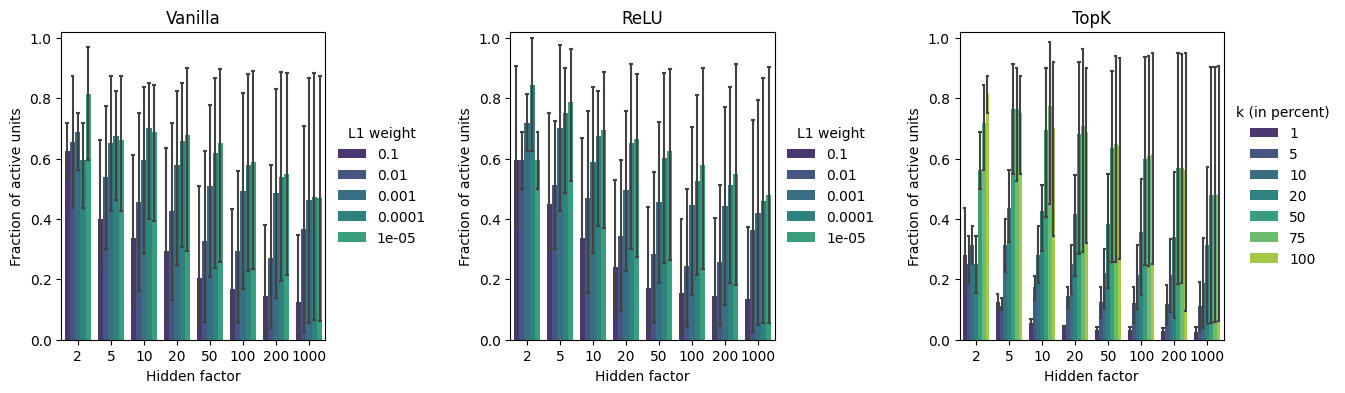

In [39]:
df_sae_metrics['fraction_unique'] = df_sae_metrics['n_unique'] / df_sae_metrics['n_activation_features']

hue = 'fraction_unique'
x = 'hidden_factor'
y = 'l1_weight'

#lr_palette = sns.color_palette('viridis', n_colors=len(lr_options))
cmap_palette = sns.color_palette('viridis', n_colors=max(len(l1_weight_options), len(k_options)))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.7)
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        y = 'k'
    sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)
    axs[i].set_ylim(0, 1.02)
    #axs[i].set_yscale('log')
    axs[i].set_title(t)
    axs[i].set_xlabel('Hidden factor')
    axs[i].set_ylabel('Fraction of active units')
    if t == 'TopK':
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='k (in percent)')
    else:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='L1 weight')
plt.show()

Obviously, the average fraction of active units increases with decreasing sparsity constraint. But the fraction is extremely variable for low sparsity.

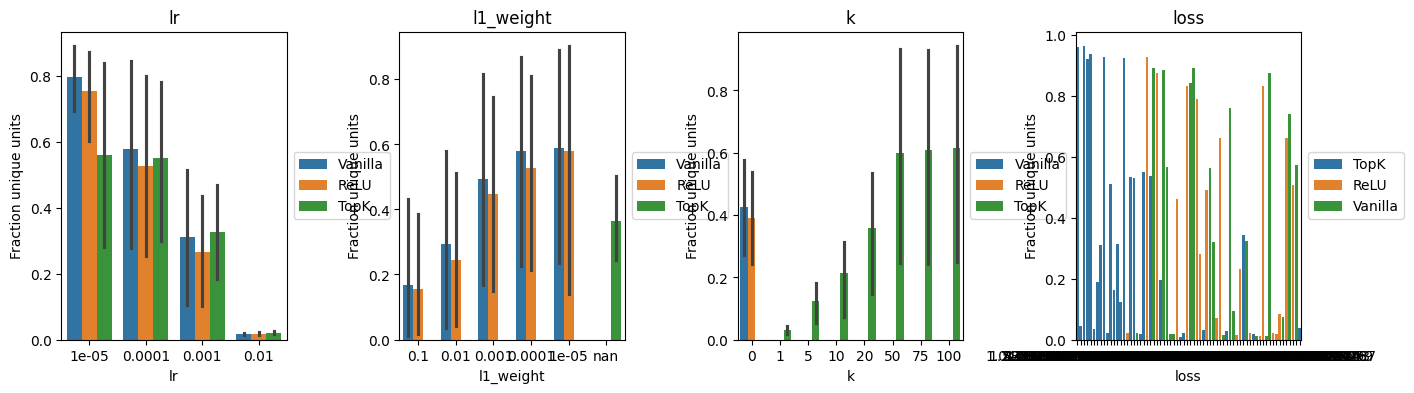

In [41]:
# what causes the variability in the fraction of unique units for low l1 weights and high ks?

# it is most pronounced in the large hidden space
df_sae_temp = df_sae_metrics[df_sae_metrics['hidden_factor'] == 100]

# look at learning rate, l1 weight, k, and loss
y = 'fraction_unique'
x_options = ['lr', 'l1_weight', 'k', 'loss']
hue = 'type'

fig, axs = plt.subplots(1, len(x_options), figsize=(len(x_options)*4, 4))
plt.subplots_adjust(wspace=0.5)
for i, x in enumerate(x_options):
    sns.barplot(data=df_sae_temp, x=x, y=y, hue=hue, ax=axs[i])
    axs[i].set_title(x)
    axs[i].set_ylabel('Fraction unique units')
    axs[i].set_xlabel(x)
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

For all models, the fraction of active units seems to strongly depend on the learning rate.

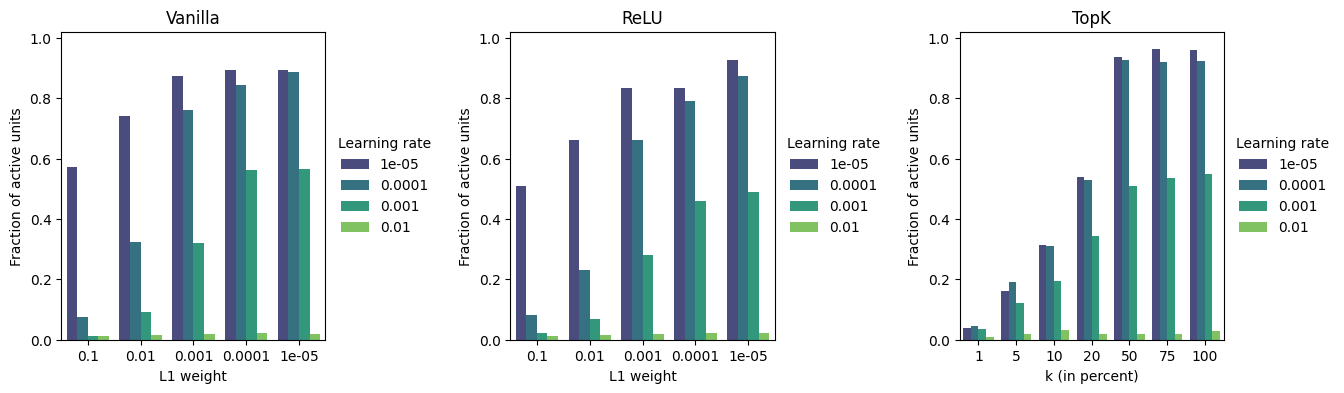

In [44]:
#df_sae_metrics['fraction_unique'] = df_sae_metrics['n_unique'] / df_sae_metrics['n_activation_features']
#df_sae_temp = df_sae_metrics[df_sae_metrics['hidden_factor'] == 100]

y = 'fraction_unique'
hue = 'lr'
x = 'l1_weight'

#lr_palette = sns.color_palette('viridis', n_colors=len(lr_options))
cmap_palette = sns.color_palette('viridis', n_colors=len(lr_options))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.7)
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        x = 'k'
    sns.barplot(data=df_sae_temp[df_sae_temp['type'] == t], x=x, y=y, hue=hue, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)
    axs[i].set_ylim(0, 1.02)
    #axs[i].set_yscale('log')
    axs[i].set_title(t)
    if t == 'TopK':
        axs[i].set_xlabel('k (in percent)')
    else:
        axs[i].set_xlabel('L1 weight')
    axs[i].set_ylabel('Fraction of active units')
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Learning rate')
plt.show()

Compromise between loss and live neurons: lr 1e-4

In [114]:
df_sae_metrics = df_sae_metrics[df_sae_metrics['lr'] == 1e-4]
df_sae_metrics = df_sae_metrics[df_sae_metrics['k'] != '1']
df_sae_metrics['fraction_unique'] = df_sae_metrics['n_unique'] / df_sae_metrics['n_activation_features']
df_sae_metrics['fraction_dead'] = 1 - df_sae_metrics['fraction_unique']

In [46]:
df_sae_metrics

hidden_factor      lr l1_weight  sparsity_penalty      loss  \
43               2  0.0001       0.1               0.0  0.012215   
47               2  0.0001      0.01               0.0  0.001812   
51               2  0.0001     0.001               0.0  0.000365   
55               2  0.0001    0.0001               0.0  0.000127   
59               2  0.0001     1e-05               0.0  0.000014   
..             ...     ...       ...               ...       ...   
212           1000  0.0001       nan               0.0  0.000040   
213           1000  0.0001       nan               0.0  0.000123   
214           1000  0.0001       nan               0.0  0.000048   
215           1000  0.0001       nan               0.0  0.000080   
216           1000  0.0001       nan               0.0  0.000145   

     n_activation_features  n_unique  avg_active_hidden_units  n_redundant  \
43                       8         5                 1.801417            0   
47                       8         4                 1.396250            1   
51                       8         6                 3.300583            3   
55                       8         5                 3.894667            1   
59                       8         7                 5.946000            2   
..                     ...       ...                      ...          ...   
212                   4000      1329               400.000000         1290   
213                   4000      2279               800.000000         2231   
214                   4000      3386              1866.022083         3337   
215                   4000      3406              1841.992750         3361   
216                   4000      3424              1874.256167         3382   

     n_per_rna    n_per_tf  n_per_activity  n_per_accessibility  \
43         0.6    1.000000             0.0                  0.0   
47         0.8    1.333333             0.0                  0.0   
51         1.2    2.000000             0.0                  0.0   
55         0.8    1.000000             0.0                  0.0   
59         1.4    1.666667             0.0                  0.0   
..         ...         ...             ...                  ...   
212       64.0   63.000000             0.0                  0.0   
213      139.2  133.000000             0.0                  0.0   
214      217.6  197.666667             0.0                  0.0   
215      222.2  208.000000             0.0                  0.0   
216      218.8  197.666667             0.0                  0.0   

     highest_corrs_rna  highest_corrs_tf  highest_corrs_activity  \
43            0.961854          0.999647                0.874904   
47            0.958471          1.000000                0.873104   
51            0.958452          1.000000                0.873066   
55            0.881170          0.830221                0.873067   
59            0.993580          0.998091                0.871615   
..                 ...               ...                     ...   
212           0.992931          0.995596                0.870659   
213           0.997357          0.998187                0.873489   
214           0.998602          0.997774                0.882978   
215           0.999852          0.999842                0.883237   
216           0.999677          0.999752                0.883139   

     highest_corrs_accessibility     type    k  fraction_unique  
43                      0.315018  Vanilla    0          0.62500  
47                      0.636663  Vanilla    0          0.50000  
51                      0.636701  Vanilla    0          0.75000  
55                      0.462749  Vanilla    0          0.62500  
59                      0.633908  Vanilla    0          0.87500  
..                           ...      ...  ...              ...  
212                     0.302784     TopK   10          0.33225  
213                     0.306532     TopK   20          0.56975  
214                    -0.244355   

/tmp/ipykernel_1417024/3294770765.py:50: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
/tmp/ipykernel_1417024/3294770765.py:50: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
/tmp/ipykernel_1417024/3294770765.py:50: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
/tmp/ipykernel_1417024/3294770765.py:50: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)


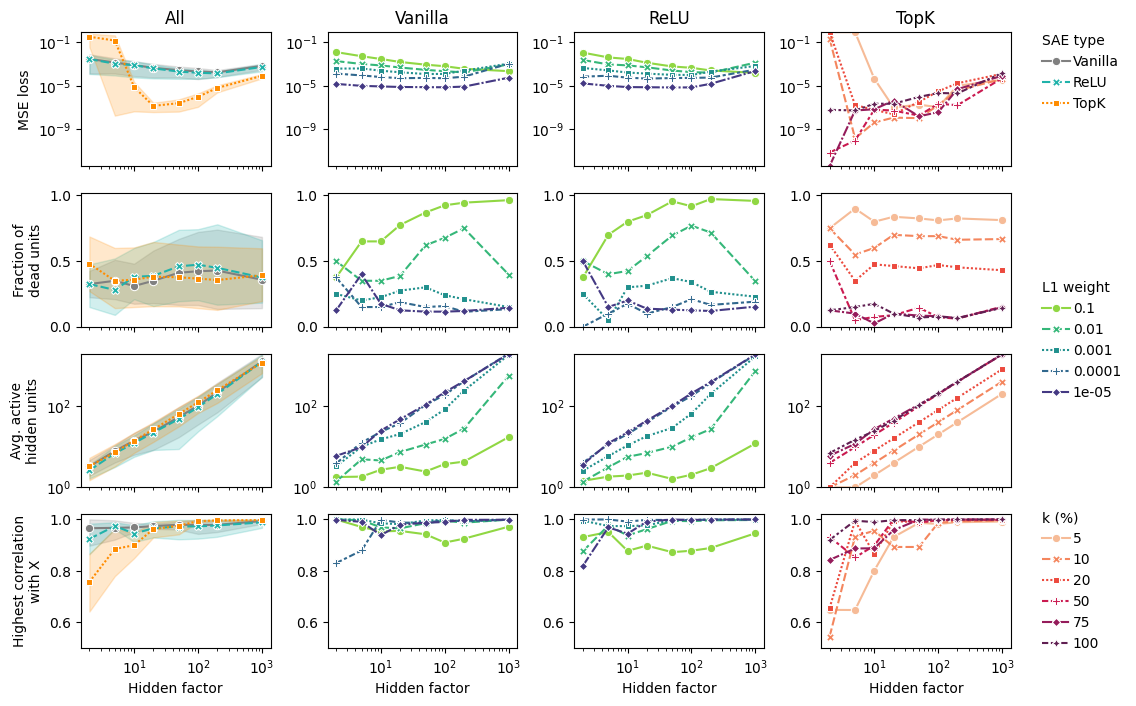

In [171]:
n_cols = 4

x = 'hidden_factor'
y_options = ['loss', 'fraction_dead', 'avg_active_hidden_units', 'highest_corrs_tf']
y_labels = ['MSE loss', 'Fraction of\ndead units', 'Avg. active\nhidden units', 'Highest correlation\nwith X']
y_lims = []
for y in y_options:
    y_lims.append((df_sae_metrics[y].min(), df_sae_metrics[y].max()))
n_rows = len(y_options)

#model_palette = sns.color_palette('colorblind', n_colors=3)
model_palette = ['grey','lightseagreen','darkorange']
l1_palette = sns.color_palette('viridis_r', n_colors=len(l1_weight_options))
k_palette = sns.color_palette('rocket_r', n_colors=len(k_options))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

# first column is generalized over models
j = 0
for i, y in enumerate(y_options):
    sns.lineplot(data=df_sae_metrics, x=x, y=y, ax=axs[i,j], hue='type', style='type', markers=True, palette=model_palette)
    axs[i,j].set_xscale('log')
    if i == 1:
        axs[i,j].set_ylim([0, 1.02])
    elif i == 3:
        axs[i,j].set_ylim([0.5, 1.02])
    else:
        axs[i,j].set_ylim(y_lims[i])
    if i in [0,2]:
        axs[i,j].set_yscale('log')
    if i == 0:
        axs[i,j].set_title('All')
    if i == len(y_options) - 1:
        axs[i,j].set_xlabel('Hidden factor')
    else:
        axs[i,j].set_xlabel('')
        axs[i,j].set_xticklabels([])
    axs[i,j].set_ylabel(y_labels[i])
    if i == len(y_options) - 1:
        axs[i,j].legend(loc='center left', bbox_to_anchor=(5.0, 4.3), ncol=1, frameon=False, title='SAE type', handletextpad=0.2, alignment='left')
    else:
        axs[i,j].get_legend().remove()

model_type = ['Vanilla', 'ReLU', 'TopK']
for j, t in enumerate(model_type):
    df_temp = df_sae_metrics[df_sae_metrics['type'] == t]
    for i, y in enumerate(y_options):
        if t == 'TopK':
            sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
        else:
            sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='l1_weight', style='l1_weight', markers=True, palette=l1_palette)
        axs[i,j+1].set_xscale('log')
        if i == 1:
            axs[i,j+1].set_ylim([0, 1.02])
        elif i == 3:
            axs[i,j+1].set_ylim([0.5, 1.02])
        else:
            axs[i,j+1].set_ylim(y_lims[i])
        if i in [0,2]:
            axs[i,j+1].set_yscale('log')
        if i == 0:
            axs[i,j+1].set_title(t)
        if i == len(y_options) - 1:
            axs[i,j+1].set_xlabel('Hidden factor')
        else:
            axs[i,j+1].set_xlabel('')
            axs[i,j+1].set_xticklabels([])
        axs[i,j+1].set_ylabel('')
        if i == len(y_options) - 1:
            if j != 1:
                if t == 'TopK':
                    axs[i,j+1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1, title='k (%)', frameon=False, handletextpad=0.2, alignment='left')
                else:
                    axs[i,j+1].legend(loc='center left', bbox_to_anchor=(3.7, 2.3), ncol=1, title='L1 weight', frameon=False, handletextpad=0.2, alignment='left')
            else:
                axs[i,j+1].get_legend().remove()
        else:
            axs[i,j+1].get_legend().remove()
plt.show()

/tmp/ipykernel_1405467/1981651756.py:13: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)
/tmp/ipykernel_1405467/1981651756.py:13: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)


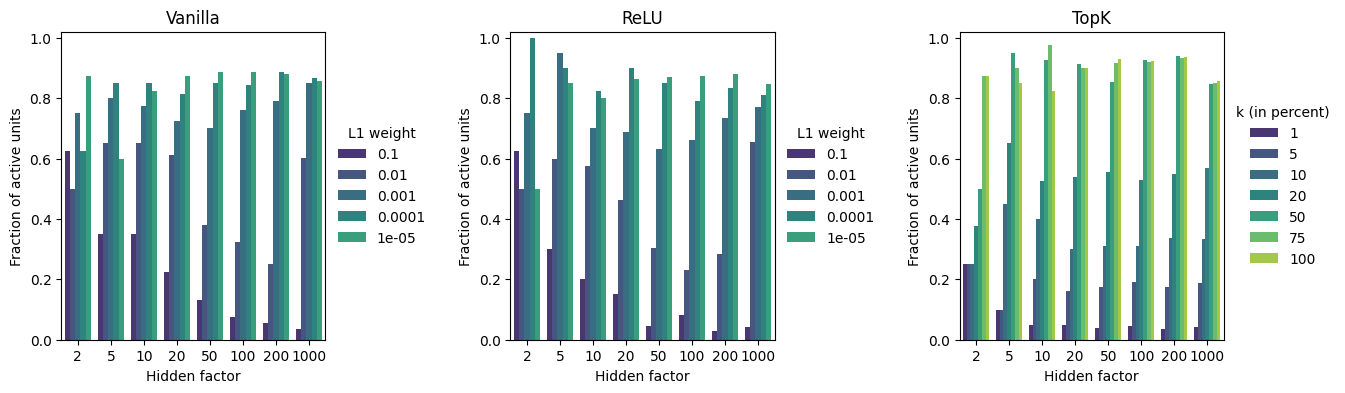

In [47]:
hue = 'fraction_unique'
x = 'hidden_factor'
y = 'l1_weight'

#lr_palette = sns.color_palette('viridis', n_colors=len(lr_options))
cmap_palette = sns.color_palette('viridis', n_colors=max(len(l1_weight_options), len(k_options)))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.7)
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        y = 'k'
    sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=hue, hue=y, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)
    axs[i].set_ylim(0, 1.02)
    #axs[i].set_yscale('log')
    axs[i].set_title(t)
    axs[i].set_xlabel('Hidden factor')
    axs[i].set_ylabel('Fraction of active units')
    if t == 'TopK':
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='k (in percent)')
    else:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='L1 weight')
plt.show()

Now let's look at the goodness of fit of our hidden variables.

/tmp/ipykernel_1405467/1765041082.py:13: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)


/tmp/ipykernel_1405467/1765041082.py:13: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)


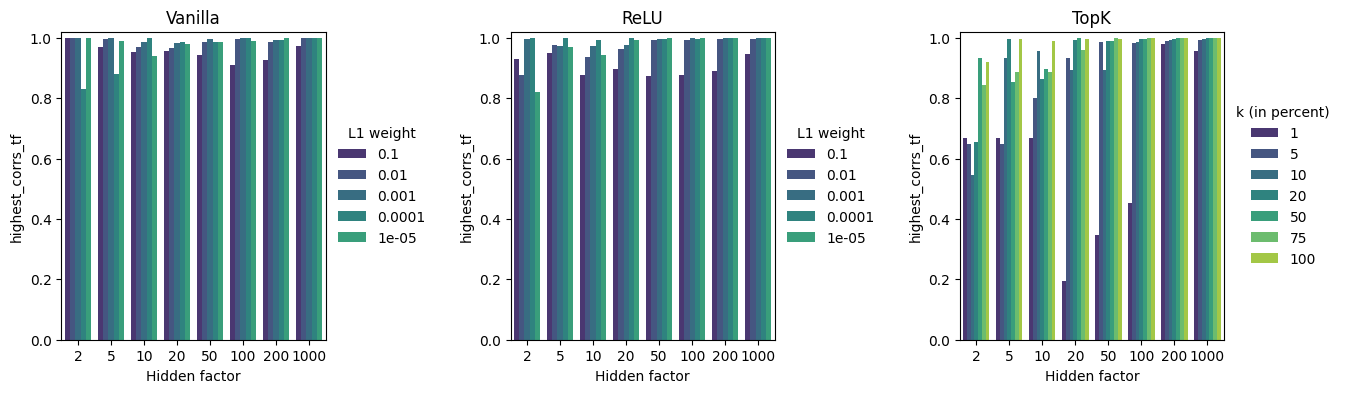

In [49]:
y = 'highest_corrs_tf'
x = 'hidden_factor'
hue = 'l1_weight'

#lr_palette = sns.color_palette('viridis', n_colors=len(lr_options))
cmap_palette = sns.color_palette('viridis', n_colors=max(len(l1_weight_options), len(k_options)))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.7)
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        hue = 'k'
    sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)
    axs[i].set_ylim(0, 1.02)
    #axs[i].set_yscale('log')
    axs[i].set_title(t)
    axs[i].set_xlabel('Hidden factor')
    #axs[i].set_ylabel('Fraction of active units')
    if t == 'TopK':
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='k (in percent)')
    else:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='L1 weight')
plt.show()

As we saw with the loss, a small hidden size can be detrimental to the performance and interpretability of TopK models.

/tmp/ipykernel_1405467/1000515008.py:13: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)
/tmp/ipykernel_1405467/1000515008.py:13: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)


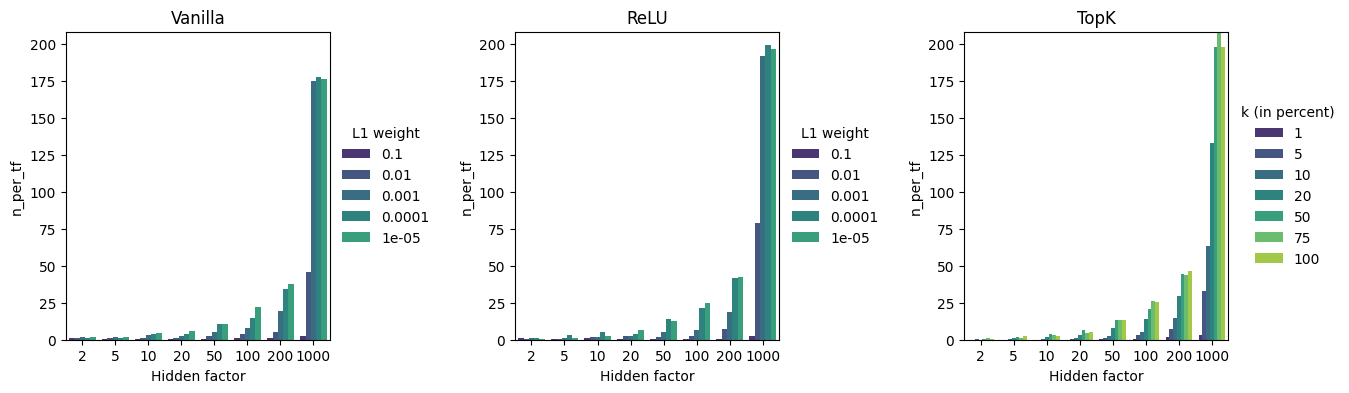

In [52]:
y = 'n_per_tf'
x = 'hidden_factor'
hue = 'l1_weight'

#lr_palette = sns.color_palette('viridis', n_colors=len(lr_options))
cmap_palette = sns.color_palette('viridis', n_colors=max(len(l1_weight_options), len(k_options)))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.7)
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        hue = 'k'
    sns.barplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[i], err_kws={'linewidth': 1.5}, capsize=0.3, palette=cmap_palette)
    axs[i].set_ylim(0, max(df_sae_metrics['n_per_tf']))
    #axs[i].set_yscale('log')
    axs[i].set_title(t)
    axs[i].set_xlabel('Hidden factor')
    #axs[i].set_ylabel('Fraction of active units')
    if t == 'TopK':
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='k (in percent)')
    else:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='L1 weight')
plt.show()

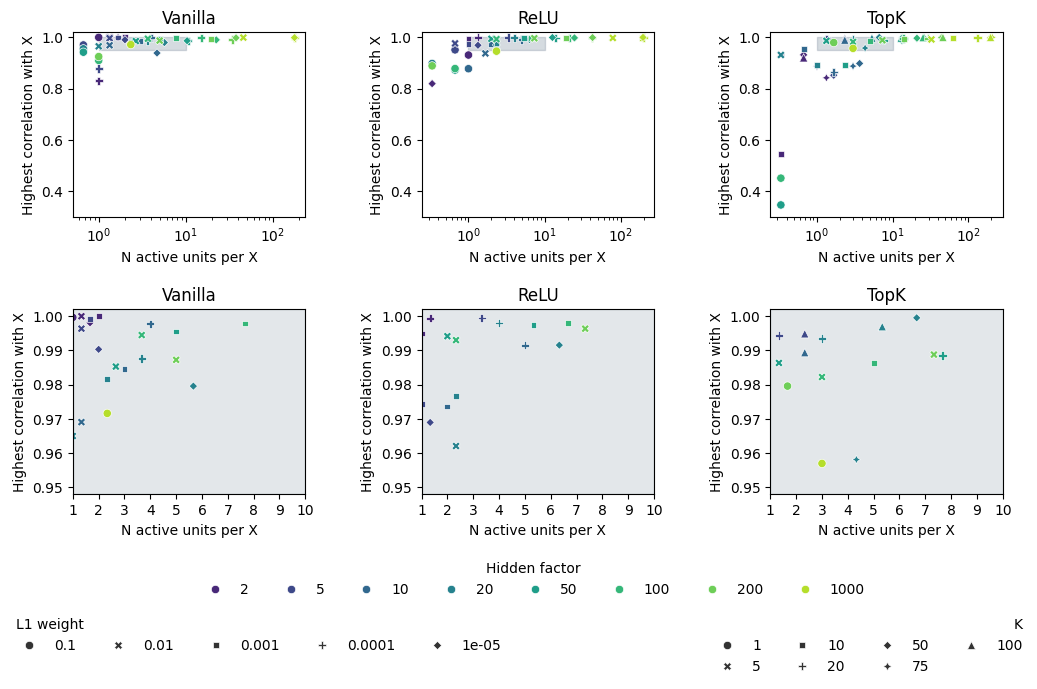

In [45]:
# I want to plot n_per_tf against highest_corrs_tf

x = 'n_per_tf'
y = 'highest_corrs_tf'
style = 'l1_weight'
hue = 'hidden_factor'

cmap_palette = sns.color_palette('viridis', n_colors=len(hidden_factor_options))

fig, axs = plt.subplots(2, 3, figsize=(12,6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
j = 0
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        style = 'k'
    # put in a grey line at y=0.95
    x_min, x_max = 1, 10
    y_min, y_max = 0.95, 1.0
    axs[j,i].fill_between([x_min, x_max], [y_min, y_min], [y_max, y_max], color='lightslategray', alpha=0.3)
    #sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, style=style, ax=axs[i], palette=cmap_palette)
    sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, style=style, ax=axs[j,i], palette=cmap_palette, markers=True)
    #axs[i].set_xlim(min(df_sae_metrics[y]), max(df_sae_metrics[y]))
    axs[j,i].set_ylim(0.3, 1.02)
    axs[j,i].set_xscale('log')
    axs[j,i].set_title(t)
    axs[j,i].set_ylabel('Highest correlation with X')
    axs[j,i].set_xlabel('N active units per X')
    #axs[j,i].legend(loc='upper left', bbox_to_anchor=(1, 0.7), frameon=False)
    axs[j,i].get_legend().remove()
j = 1
style = 'l1_weight'

for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        style = 'k'
    # put in a grey line at y=0.95
    x_min, x_max = 1, 10
    y_min, y_max = 0.948, 1.002
    # set the background color to grey
    axs[j,i].fill([x_min, x_max, x_max, x_min], [y_min, y_min, y_max, y_max], color='lightslategray', alpha=0.2)
    sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, style=style, ax=axs[j,i], palette=cmap_palette, markers=True)
    #axs[i].set_xlim(min(df_sae_metrics[y]), max(df_sae_metrics[y]))
    axs[j,i].set_ylim(y_min, y_max)
    axs[j,i].set_xlim(x_min, x_max)
    axs[j,i].set_title(t)
    axs[j,i].set_ylabel('Highest correlation with X')
    axs[j,i].set_xlabel('N active units per X')
    # make sure the x ticks stay integers and start at 1
    axs[j,i].set_xticks(np.arange(1, 11, 1))
    #if t == 'TopK':
    #    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='k (in percent)')
    #else:
    #    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='L1 weight')
    #axs[j,i].get_legend().remove()
    if i == 1:
        handles, labels = axs[j,i].get_legend_handles_labels()
        stop_index = np.where(np.array(labels) == style)[0][0]
        handles = handles[1:stop_index]
        labels = labels[1:stop_index]
        axs[j,i].legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(-1, -0.3), frameon=False, ncol=8, title='Hidden factor', alignment='center')
    elif i == 0:
        handles, labels = axs[j,i].get_legend_handles_labels()
        start_index = np.where(np.array(labels) == style)[0][0]
        handles = handles[(start_index+1):]
        labels = labels[(start_index+1):]
        axs[j,i].legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(-0.3, -0.6), frameon=False, ncol=5, title='L1 weight', alignment='left')
    else:
        handles, labels = axs[j,i].get_legend_handles_labels()
        start_index = np.where(np.array(labels) == style)[0][0]
        handles = handles[(start_index+1):]
        labels = labels[(start_index+1):]
        axs[j,i].legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(-0.3, -0.6), frameon=False, ncol=4, title='K', alignment='right')
plt.show()

In terms of high correlation with little redundancy in the underlying variables, the Vanilla model has the best trade-off, TopK the worst.

L1 weights 1e-1 and 1e-5 do not contribute to the highest-ranking models here. Vanilla may do better with 1e-2 and 1e-3, while ReLU has the best results for 1e-4.The hidden factor here mainly increases the redundancy. For an average of 1-5 units per feature, the hidden factor should be between 5 and 50.

For TopK, a k between 20 and 100 percent of the hidden size seems to work best in terms of correlation, with a hidden factor between 5 and 20. Higher hidden factors here lower the maximum correlation with X. This, however, speaks against the loss performance.

What about the other hidden variables?

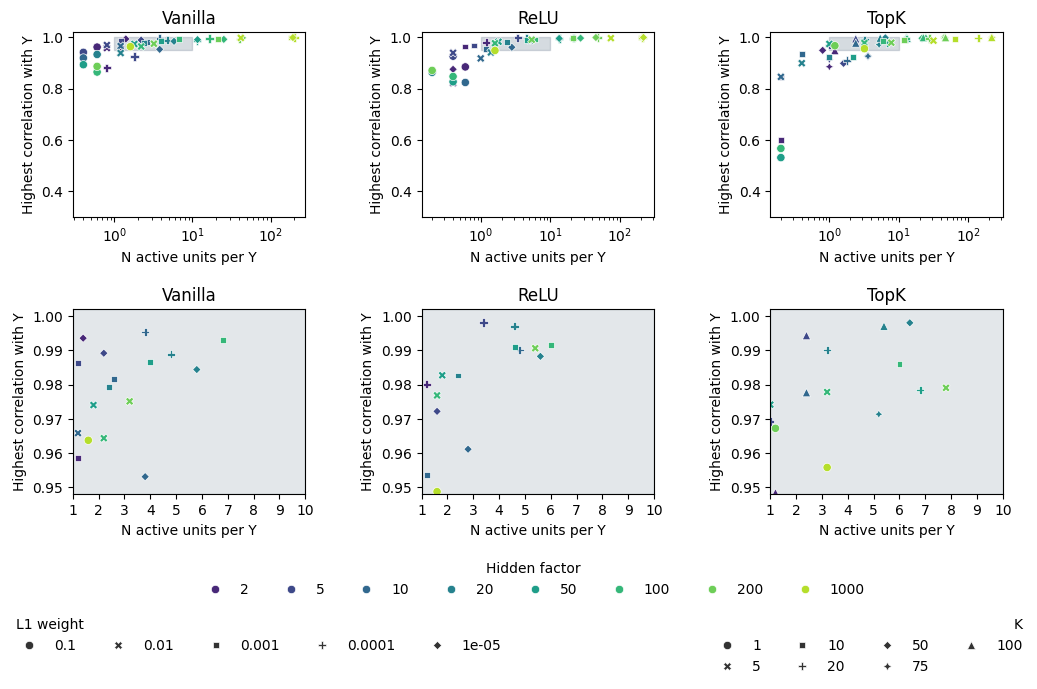

In [46]:
# I want to plot n_per_tf against highest_corrs_tf

x = 'n_per_rna'
y = 'highest_corrs_rna'
style = 'l1_weight'
hue = 'hidden_factor'

cmap_palette = sns.color_palette('viridis', n_colors=len(hidden_factor_options))

fig, axs = plt.subplots(2, 3, figsize=(12,6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
j = 0
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        style = 'k'
    # put in a grey line at y=0.95
    x_min, x_max = 1, 10
    y_min, y_max = 0.95, 1.0
    axs[j,i].fill_between([x_min, x_max], [y_min, y_min], [y_max, y_max], color='lightslategray', alpha=0.3)
    #sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, style=style, ax=axs[i], palette=cmap_palette)
    sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, style=style, ax=axs[j,i], palette=cmap_palette, markers=True)
    #axs[i].set_xlim(min(df_sae_metrics[y]), max(df_sae_metrics[y]))
    axs[j,i].set_ylim(0.3, 1.02)
    axs[j,i].set_xscale('log')
    axs[j,i].set_title(t)
    axs[j,i].set_ylabel('Highest correlation with Y')
    axs[j,i].set_xlabel('N active units per Y')
    #axs[j,i].legend(loc='upper left', bbox_to_anchor=(1, 0.7), frameon=False)
    axs[j,i].get_legend().remove()
j = 1
style = 'l1_weight'

for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        style = 'k'
    # put in a grey line at y=0.95
    x_min, x_max = 1, 10
    y_min, y_max = 0.948, 1.002
    # set the background color to grey
    axs[j,i].fill([x_min, x_max, x_max, x_min], [y_min, y_min, y_max, y_max], color='lightslategray', alpha=0.2)
    sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, style=style, ax=axs[j,i], palette=cmap_palette, markers=True)
    #axs[i].set_xlim(min(df_sae_metrics[y]), max(df_sae_metrics[y]))
    axs[j,i].set_ylim(y_min, y_max)
    axs[j,i].set_xlim(x_min, x_max)
    axs[j,i].set_title(t)
    axs[j,i].set_ylabel('Highest correlation with Y')
    axs[j,i].set_xlabel('N active units per Y')
    # make sure the x ticks stay integers and start at 1
    axs[j,i].set_xticks(np.arange(1, 11, 1))
    #if t == 'TopK':
    #    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='k (in percent)')
    #else:
    #    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='L1 weight')
    #axs[j,i].get_legend().remove()
    if i == 1:
        handles, labels = axs[j,i].get_legend_handles_labels()
        stop_index = np.where(np.array(labels) == style)[0][0]
        handles = handles[1:stop_index]
        labels = labels[1:stop_index]
        axs[j,i].legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(-1, -0.3), frameon=False, ncol=8, title='Hidden factor', alignment='center')
    elif i == 0:
        handles, labels = axs[j,i].get_legend_handles_labels()
        start_index = np.where(np.array(labels) == style)[0][0]
        handles = handles[(start_index+1):]
        labels = labels[(start_index+1):]
        axs[j,i].legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(-0.3, -0.6), frameon=False, ncol=5, title='L1 weight', alignment='left')
    else:
        handles, labels = axs[j,i].get_legend_handles_labels()
        start_index = np.where(np.array(labels) == style)[0][0]
        handles = handles[(start_index+1):]
        labels = labels[(start_index+1):]
        axs[j,i].legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(-0.3, -0.6), frameon=False, ncol=4, title='K', alignment='right')
plt.show()

Not much change for TopK.

Vanillar prefers l1 weights 1e-3 and 1e-4 here, and ReLU performs best with 1e-4.

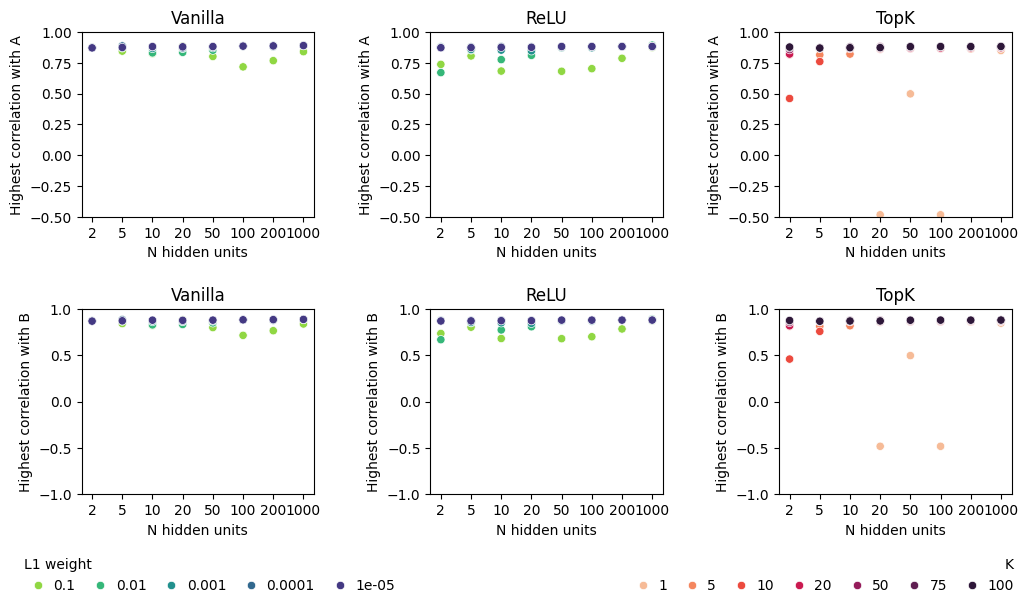

In [83]:
# I want to plot n_per_tf against highest_corrs_tf

df_sae_metrics['hidden_factor_cat'] = df_sae_metrics['hidden_factor'].astype(str)

x = 'hidden_factor_cat'
y = 'highest_corrs_activity'
hue = 'l1_weight'

l1_palette = sns.color_palette('viridis_r', n_colors=len(l1_weight_options))
k_palette = sns.color_palette('rocket_r', n_colors=len(k_options))

fig, axs = plt.subplots(2, 3, figsize=(12,6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
j = 0
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        hue = 'k'
        palette = k_palette
    else:
        palette = l1_palette
    sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[j,i], palette=palette, markers=True)
    axs[j,i].set_title(t)
    axs[j,i].set_ylim(-0.5, 1.0)
    axs[j,i].set_ylabel('Highest correlation with A')
    axs[j,i].set_xlabel('N hidden units')
    axs[j,i].get_legend().remove()

j = 1
hue = 'l1_weight'
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        hue = 'k'
        palette = k_palette
    else:
        palette = l1_palette
    sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[j,i], palette=palette, markers=True)
    axs[j,i].set_title(t)
    axs[j,i].set_ylim(-1.0, 1.0)
    axs[j,i].set_ylabel('Highest correlation with B')
    axs[j,i].set_xlabel('N hidden units')
    # if i == 0, put the legend under the plot
    if i == 0:
        axs[j,i].legend(loc='lower left', bbox_to_anchor=(-0.3, -0.6), frameon=False, title='L1 weight', ncol=len(l1_weight_options), alignment='left',handletextpad=0.1,columnspacing=0.8)
    elif i == 2:
        axs[j,i].legend(loc='lower left', bbox_to_anchor=(-0.7, -0.6), frameon=False, title='K', ncol=len(k_options), alignment='right',handletextpad=0.1,columnspacing=0.8)
    else:
        axs[j,i].get_legend().remove()
plt.show()

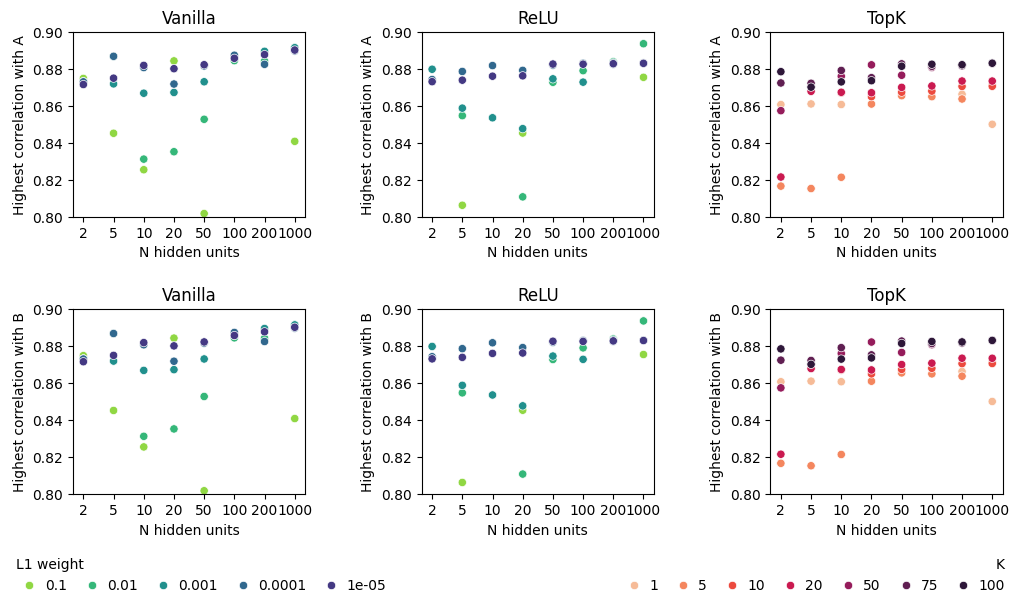

In [84]:
# I want to plot n_per_tf against highest_corrs_tf

df_sae_metrics['hidden_factor_cat'] = df_sae_metrics['hidden_factor'].astype(str)

x = 'hidden_factor_cat'
y = 'highest_corrs_activity'
hue = 'l1_weight'

l1_palette = sns.color_palette('viridis_r', n_colors=len(l1_weight_options))
k_palette = sns.color_palette('rocket_r', n_colors=len(k_options))

fig, axs = plt.subplots(2, 3, figsize=(12,6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
j = 0
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        hue = 'k'
        palette = k_palette
    else:
        palette = l1_palette
    sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[j,i], palette=palette, markers=True)
    axs[j,i].set_title(t)
    axs[j,i].set_ylim(0.8, 0.9)
    axs[j,i].set_ylabel('Highest correlation with A')
    axs[j,i].set_xlabel('N hidden units')
    axs[j,i].get_legend().remove()

j = 1
hue = 'l1_weight'
for i, t in enumerate(['Vanilla', 'ReLU', 'TopK']):
    if t == 'TopK':
        hue = 'k'
        palette = k_palette
    else:
        palette = l1_palette
    sns.scatterplot(data=df_sae_metrics[df_sae_metrics['type'] == t], x=x, y=y, hue=hue, ax=axs[j,i], palette=palette, markers=True)
    axs[j,i].set_title(t)
    axs[j,i].set_ylim(0.8, 0.9)
    axs[j,i].set_ylabel('Highest correlation with B')
    axs[j,i].set_xlabel('N hidden units')
    # if i == 0, put the legend under the plot
    if i == 0:
        axs[j,i].legend(loc='lower left', bbox_to_anchor=(-0.3, -0.6), frameon=False, title='L1 weight', ncol=len(l1_weight_options), alignment='left',handletextpad=0.1,columnspacing=0.8)
    elif i == 2:
        axs[j,i].legend(loc='lower left', bbox_to_anchor=(-0.7, -0.6), frameon=False, title='K', ncol=len(k_options), alignment='right',handletextpad=0.1,columnspacing=0.8)
    else:
        axs[j,i].get_legend().remove()
plt.show()

For the original random variables A and B, we see much worse correlations with sae activations. This may be due to the fact that the original variables are not linearly separable / decomposable from X.

Here, for Vanilla and ReLU we find that L1 weights <= 1e-4 are most robust.

TopK again does best with k >= 50 percent of the hidden size, but the overall correlation is again lower than for Vanilla and ReLU.

/tmp/ipykernel_1417024/1640188157.py:52: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
/tmp/ipykernel_1417024/1640188157.py:52: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
/tmp/ipykernel_1417024/1640188157.py:52: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
/tmp/ipykernel_1417024/1640188157.py:52: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
/tmp/ipykernel_1417024/164018815

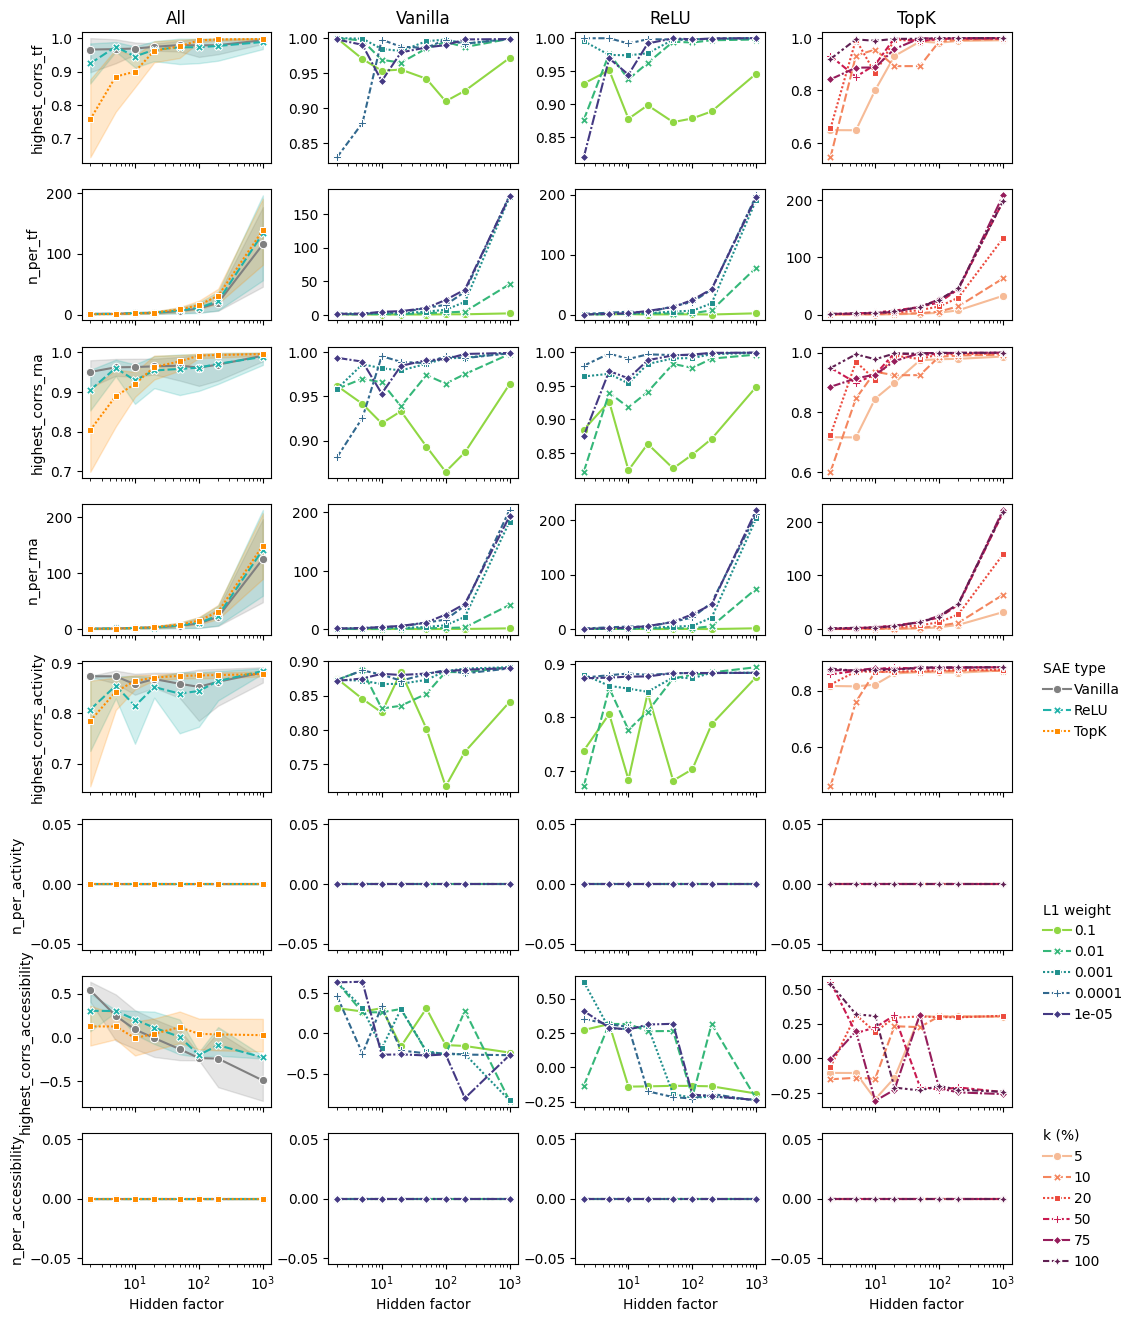

In [173]:
n_cols = 4

x = 'hidden_factor'
y_options = ['highest_corrs_tf', 'n_per_tf', 'highest_corrs_rna', 'n_per_rna', 'highest_corrs_activity', 'n_per_activity', 'highest_corrs_accessibility', 'n_per_accessibility']
y_labels = y_options
y_lims = []
for y in y_options:
    y_lims.append((df_sae_metrics[y].min(), df_sae_metrics[y].max()))
n_rows = len(y_options)

#model_palette = sns.color_palette('colorblind', n_colors=3)
model_palette = ['grey','lightseagreen','darkorange']
l1_palette = sns.color_palette('viridis_r', n_colors=len(l1_weight_options))
k_palette = sns.color_palette('rocket_r', n_colors=len(k_options))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

# first column is generalized over models
j = 0
for i, y in enumerate(y_options):
    sns.lineplot(data=df_sae_metrics, x=x, y=y, ax=axs[i,j], hue='type', style='type', markers=True, palette=model_palette)
    axs[i,j].set_xscale('log')
    """
    if i == 1:
        axs[i,j].set_ylim([0, 1.02])
    elif i == 3:
        axs[i,j].set_ylim([0.5, 1.02])
    else:
        axs[i,j].set_ylim(y_lims[i])
    if i in [0,2]:
        axs[i,j].set_yscale('log')
    """
    if i == 0:
        axs[i,j].set_title('All')
    if i == len(y_options) - 1:
        axs[i,j].set_xlabel('Hidden factor')
    else:
        axs[i,j].set_xlabel('')
        axs[i,j].set_xticklabels([])
    axs[i,j].set_ylabel(y_labels[i])
    if i == len(y_options) - 1:
        axs[i,j].legend(loc='center left', bbox_to_anchor=(5.0, 4.3), ncol=1, frameon=False, title='SAE type', handletextpad=0.2, alignment='left')
    else:
        axs[i,j].get_legend().remove()

model_type = ['Vanilla', 'ReLU', 'TopK']
for j, t in enumerate(model_type):
    df_temp = df_sae_metrics[df_sae_metrics['type'] == t]
    for i, y in enumerate(y_options):
        if t == 'TopK':
            sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
        else:
            sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='l1_weight', style='l1_weight', markers=True, palette=l1_palette)
        axs[i,j+1].set_xscale('log')
        """
        if i == 1:
            axs[i,j+1].set_ylim([0, 1.02])
        elif i == 3:
            axs[i,j+1].set_ylim([0.5, 1.02])
        else:
            axs[i,j+1].set_ylim(y_lims[i])
        if i in [0,2]:
            axs[i,j+1].set_yscale('log')
        """
        if i == 0:
            axs[i,j+1].set_title(t)
        if i == len(y_options) - 1:
            axs[i,j+1].set_xlabel('Hidden factor')
        else:
            axs[i,j+1].set_xlabel('')
            axs[i,j+1].set_xticklabels([])
        axs[i,j+1].set_ylabel('')
        if i == len(y_options) - 1:
            if j != 1:
                if t == 'TopK':
                    axs[i,j+1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1, title='k (%)', frameon=False, handletextpad=0.2, alignment='left')
                else:
                    axs[i,j+1].legend(loc='center left', bbox_to_anchor=(3.7, 2.3), ncol=1, title='L1 weight', frameon=False, handletextpad=0.2, alignment='left')
            else:
                axs[i,j+1].get_legend().remove()
        else:
            axs[i,j+1].get_legend().remove()
plt.show()

/tmp/ipykernel_1417024/4164039035.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i,j].set_ylim(y_lims[i])
/tmp/ipykernel_1417024/4164039035.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i,j].set_ylim(y_lims[i])
/tmp/ipykernel_1417024/4164039035.py:53: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i,j+1].set_ylim(y_lims[i])
/tmp/ipykernel_1417024/4164039035.py:53: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i,j+1].set_ylim(y_lims[i])
/tmp/ipykernel_1417024/4164039035.py:53: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i,j+1].set_ylim(y_lims[i])
/tmp/ipykernel_1417024/4164039035.py:53: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i,j+1].set_ylim(y_lims[i])
/tmp/ipykernel_1417024/4164039035.py:47: UserWarning: Th

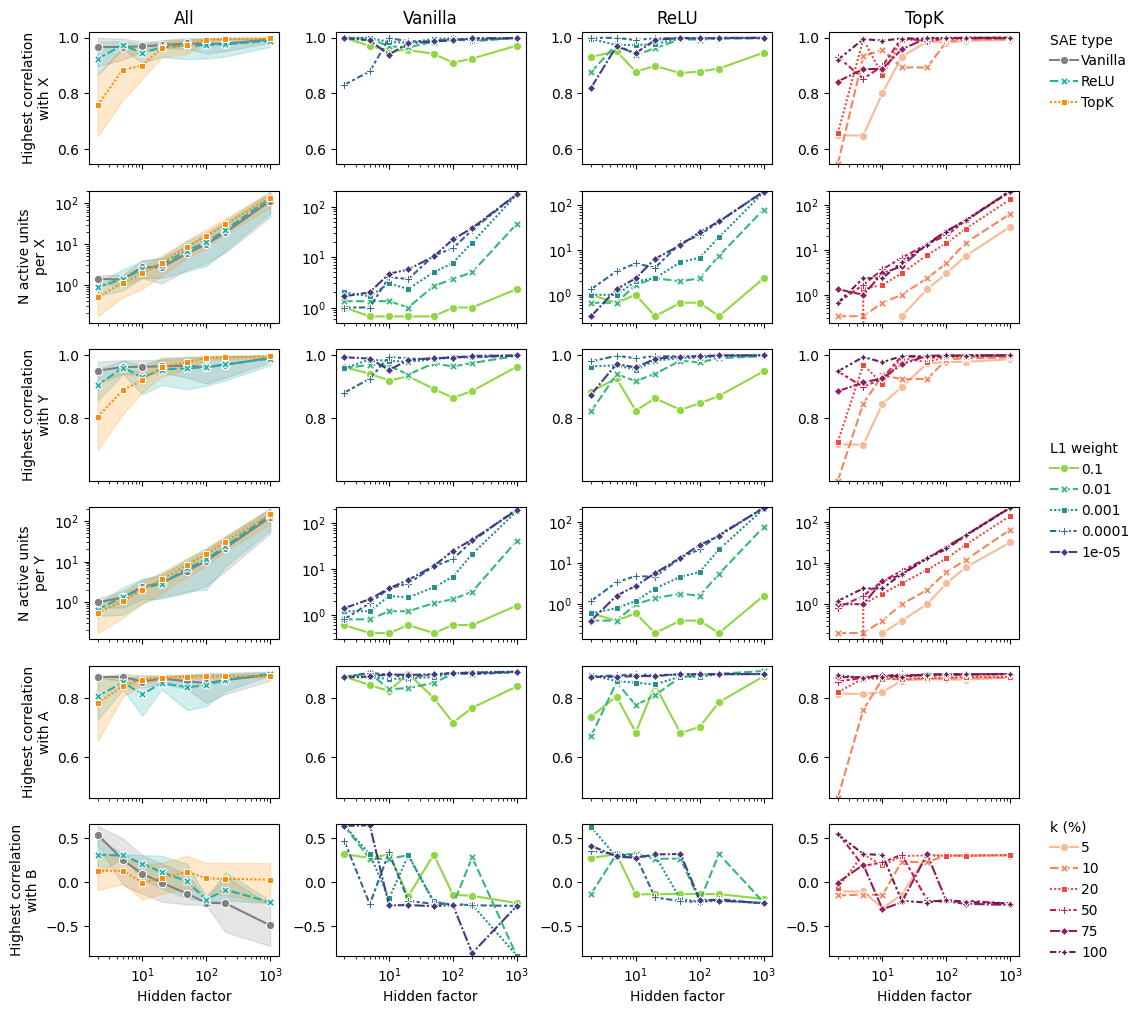

In [187]:
n_cols = 4

x = 'hidden_factor'
y_options = ['highest_corrs_tf', 'n_per_tf', 'highest_corrs_rna', 'n_per_rna', 'highest_corrs_activity', 'highest_corrs_accessibility']
y_labels = ['Highest correlation\nwith X', 'N active units\nper X', 'Highest correlation\nwith Y', 'N active units\nper Y', 'Highest correlation\nwith A', 'Highest correlation\nwith B']
y_lims = []
for y in y_options:
    y_lims.append((df_sae_metrics[y].min(), df_sae_metrics[y].max()))
n_rows = len(y_options)

#model_palette = sns.color_palette('colorblind', n_colors=3)
model_palette = ['grey','lightseagreen','darkorange']
l1_palette = sns.color_palette('viridis_r', n_colors=len(l1_weight_options))
k_palette = sns.color_palette('rocket_r', n_colors=len(k_options))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

# first column is generalized over models
j = 0
for i, y in enumerate(y_options):
    sns.lineplot(data=df_sae_metrics, x=x, y=y, ax=axs[i,j], hue='type', style='type', markers=True, palette=model_palette)
    axs[i,j].set_xscale('log')
    if y[:5] == 'n_per':
        axs[i,j].set_yscale('log')
        axs[i,j].set_ylim(y_lims[i])
    else:
        axs[i,j].set_ylim(y_lims[i][0], y_lims[i][1]*1.02)
    if i == 0:
        axs[i,j].set_title('All')
    if i == len(y_options) - 1:
        axs[i,j].set_xlabel('Hidden factor')
    else:
        axs[i,j].set_xlabel('')
        axs[i,j].set_xticklabels([])
    axs[i,j].set_ylabel(y_labels[i])
    if i == len(y_options) - 1:
        axs[i,j].legend(loc='center left', bbox_to_anchor=(5.0, 6.7), ncol=1, frameon=False, title='SAE type', handletextpad=0.2, alignment='left')
    else:
        axs[i,j].get_legend().remove()

model_type = ['Vanilla', 'ReLU', 'TopK']
for j, t in enumerate(model_type):
    df_temp = df_sae_metrics[df_sae_metrics['type'] == t]
    for i, y in enumerate(y_options):
        if t == 'TopK':
            sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='k', style='k', markers=True, palette=k_palette)
        else:
            sns.lineplot(data=df_temp, x=x, y=y, ax=axs[i,j+1], hue='l1_weight', style='l1_weight', markers=True, palette=l1_palette)
        axs[i,j+1].set_xscale('log')
        if y[:5] == 'n_per':
            axs[i,j+1].set_yscale('log')
            axs[i,j+1].set_ylim(y_lims[i])
        else:
            axs[i,j+1].set_ylim(y_lims[i][0], y_lims[i][1]*1.02)
        if i == 0:
            axs[i,j+1].set_title(t)
        if i == len(y_options) - 1:
            axs[i,j+1].set_xlabel('Hidden factor')
        else:
            axs[i,j+1].set_xlabel('')
            axs[i,j+1].set_xticklabels([])
        axs[i,j+1].set_ylabel('')
        if i == len(y_options) - 1:
            if j != 1:
                if t == 'TopK':
                    axs[i,j+1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1, title='k (%)', frameon=False, handletextpad=0.2, alignment='left')
                else:
                    axs[i,j+1].legend(loc='center left', bbox_to_anchor=(3.7, 3.45), ncol=1, title='L1 weight', frameon=False, handletextpad=0.2, alignment='left')
            else:
                axs[i,j+1].get_legend().remove()
        else:
            axs[i,j+1].get_legend().remove()
plt.show()

### publication

In [15]:
df_sae_metrics = pd.read_csv('03_results/reports/files/sim_modl1l4_sae_metrics.csv')
# remove all rows with sparsity penalty > 0
df_sae_metrics = df_sae_metrics[df_sae_metrics['sparsity_penalty'] == 0.0]
df_sae_metrics['type'] = 'Vanilla'

df_sae_metrics_relu = pd.read_csv('03_results/reports/files/sim_modl1l4_sae-bricken2_metrics.csv')
df_sae_metrics_relu['type'] = 'ReLU'
df_sae_metrics = pd.concat([df_sae_metrics, df_sae_metrics_relu])

df_sae_metrics_topk = pd.read_csv('03_results/reports/files/sim_modl1l4_sae-topK_metrics.csv')
df_sae_metrics_topk['type'] = 'TopK'
df_sae_metrics = pd.concat([df_sae_metrics, df_sae_metrics_topk])

# mods
df_sae_metrics['k'] = df_sae_metrics['k'].fillna(0)
df_sae_metrics['k'] = df_sae_metrics['k'].astype(int)
df_sae_metrics['k'] = df_sae_metrics['k'].astype(str)
df_sae_metrics = df_sae_metrics[df_sae_metrics['k'] != '1']
df_sae_metrics['l1_weight'] = df_sae_metrics['l1_weight'].astype(str)
df_sae_metrics['fraction_unique'] = df_sae_metrics['n_unique'] / df_sae_metrics['n_activation_features']
df_sae_metrics['fraction_dead'] = 1 - df_sae_metrics['fraction_unique']

hidden_factor_options = [2, 5, 10, 20, 50, 100, 200, 1000]
lr_options = [1e-2, 1e-3, 1e-4, 1e-5]
l1_weight_options = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
k_options = [1, 5, 10, 20, 50, 75, 100]

In [11]:
len(df_sae_metrics[(df_sae_metrics['type'] == 'Vanilla') & (df_sae_metrics['lr'] == 1e-5)])

40

In [16]:
df_lr = df_sae_metrics.copy()
#df_temp = df_temp[df_temp['k'] != '1']
df_lr = df_lr[df_lr['hidden_factor'] == 100]

df_sae_metrics = df_sae_metrics[df_sae_metrics['lr'] == 1e-4]

In [13]:
len(df_sae_metrics[(df_sae_metrics['type'] == 'Vanilla') & (df_sae_metrics['hidden_factor'] == 100)])

5

In [16]:
len(df_sae_metrics[(df_sae_metrics['type'] == 'Vanilla') & (df_sae_metrics['l1_weight'] == '0.001')])

8

In [18]:
len(df_sae_metrics[(df_sae_metrics['type'] == 'TopK') & (df_sae_metrics['k'] == '10')])

8

/tmp/ipykernel_3486766/703321358.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_sae_metrics['type'].cat.reorder_categories(['Vanilla', 'ReLU', 'TopK'], inplace=True)
/tmp/ipykernel_3486766/703321358.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_metrics['correlation'] = df_sae_metrics[c]
/tmp/ipykernel_3486766/703321358.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

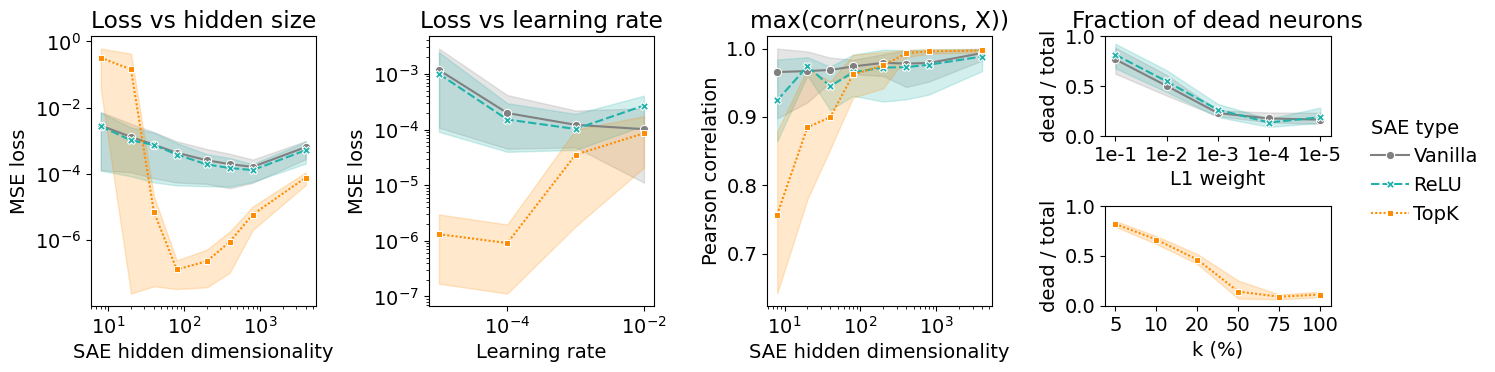

In [5]:
# a new line plot with 4 columns
# make the type categorical
df_sae_metrics['type'] = df_sae_metrics['type'].astype('category')
# set the order
df_sae_metrics['type'].cat.reorder_categories(['Vanilla', 'ReLU', 'TopK'], inplace=True)

variable_dict = {'highest_corrs_tf': 'X',
                'highest_corrs_rna': 'Y',
                'highest_corrs_activity': 'A',
                'highest_corrs_accessibility': 'B'}
df_corr_metrics = df_sae_metrics[['hidden_factor','type']]
corr_columns = [c for c in df_sae_metrics.columns if 'corrs' in c]
for i,c in enumerate(corr_columns):
    if i == 0:
        df_corr_metrics = df_sae_metrics[['hidden_factor','type']]
        df_corr_metrics['correlation'] = df_sae_metrics[c]
        df_corr_metrics['target'] = variable_dict[c]
    else:
        df_temp = df_sae_metrics[['hidden_factor','type']]
        df_temp['correlation'] = df_sae_metrics[c]
        df_temp['target'] = variable_dict[c]
        df_corr_metrics = pd.concat([df_corr_metrics, df_temp], axis=0)

n_cols = 4

model_palette = ['grey','lightseagreen','darkorange']
l1_palette = sns.color_palette('viridis_r', n_colors=len(l1_weight_options))
k_palette = sns.color_palette('rocket_r', n_colors=len(k_options))

# make the figure a grid of 2 rows and 4 columns
from matplotlib.gridspec import GridSpec
# set the font size
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16, 3.5))
# add spacing
fig.subplots_adjust(wspace=0.5, hspace=0.7)
gs = GridSpec(2, n_cols, figure=fig)

# first subplot
ax0 = fig.add_subplot(gs[0:, 0])
# the first plot is the loss vs hidden colored by model type
x = 'n_activation_features'
y = 'loss'
y_label = 'MSE loss'
sns.lineplot(data=df_sae_metrics, x=x, y=y, ax=ax0, hue='type', style='type', markers=True, palette=model_palette)
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_title('Loss vs hidden size')
ax0.set_xlabel('SAE hidden dimensionality')
ax0.set_ylabel(y_label)
ax0.get_legend().remove()
#ax0.legend(loc='center left', bbox_to_anchor=(-0.3, -0.3), ncol=3, frameon=False, title='SAE type', handletextpad=0.2, alignment='left', columnspacing=0.8)

ax0b = fig.add_subplot(gs[0:, 1])
# the first plot is the loss vs hidden colored by model type
x = 'lr'
y = 'loss'
y_label = 'MSE loss'
sns.lineplot(data=df_lr, x=x, y=y, ax=ax0b, hue='type', style='type', markers=True, palette=model_palette)
ax0b.set_xscale('log')
ax0b.set_yscale('log')
ax0b.set_title('Loss vs learning rate')
ax0b.set_xlabel('Learning rate')
ax0b.set_ylabel(y_label)
ax0b.get_legend().remove()

ax2 = fig.add_subplot(gs[0:, 2])
# plot the correlation of X vs hidden factor
x = 'n_activation_features'
y = 'highest_corrs_tf'
y_label = 'max(corr(neurons, X))'
sns.lineplot(data=df_sae_metrics, x=x, y=y, ax=ax2, hue='type', style='type', markers=True, palette=model_palette)
ax2.set_xscale('log')
ax2.set_title(y_label)
ax2.set_xlabel('SAE hidden dimensionality')
ax2.set_ylabel('Pearson correlation')
ax2.legend(loc='center left', bbox_to_anchor=(2.6, 0.5), ncol=1, frameon=False, title='SAE type', handletextpad=0.2, alignment='left', columnspacing=0.8)

ax1_a = fig.add_subplot(gs[0, 3])
ax1_b = fig.add_subplot(gs[1, 3])
# the second column gives the fraction of dead units vs l1 weight and k (need double axis)
x1 = 'l1_weight'
x2 = 'k'
y = 'fraction_dead'
y_label = 'Fraction of dead neurons'
#y_lims = [df_sae_metrics[y].min(), df_sae_metrics[y].max()]
y_lims = [0,1]
sns.lineplot(data=df_sae_metrics[df_sae_metrics['type'] != 'TopK'], x=x1, y=y, ax=ax1_a, hue='type', style='type', markers=True, palette=model_palette)
sns.lineplot(data=df_sae_metrics[df_sae_metrics['type'] == 'TopK'], x=x2, y=y, ax=ax1_b, hue='type', style='type', markers=True, palette=[model_palette[-1]])
ax1_a.set_title(y_label)
ax1_a.set_xlabel('L1 weight')
# change the x tick labels to scientific notation
ax1_a.set_xticklabels(['1e-1', '1e-2', '1e-3', '1e-4', '1e-5'])
ax1_b.set_xlabel('k (%)')
ax1_a.set_ylabel('dead / total')
ax1_b.set_ylabel('dead / total')
ax1_a.set_ylim(y_lims)
ax1_b.set_ylim(y_lims)
# remove the legends
ax1_a.get_legend().remove()
ax1_b.get_legend().remove()

plt.show()
# export to pdf
fig.savefig('03_results/figures/sim_modl1l4_sae_performance_metrics.pdf', bbox_inches='tight')

In [7]:
len(df_corr_metrics[(df_corr_metrics['target'] == 'X') & (df_corr_metrics['hidden_factor'] == 100)])

16

/tmp/ipykernel_3486766/714542357.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_sae_metrics['type'].cat.reorder_categories(['Vanilla', 'ReLU', 'TopK'], inplace=True)
/tmp/ipykernel_3486766/714542357.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_metrics['correlation'] = df_sae_metrics[c]
/tmp/ipykernel_3486766/714542357.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

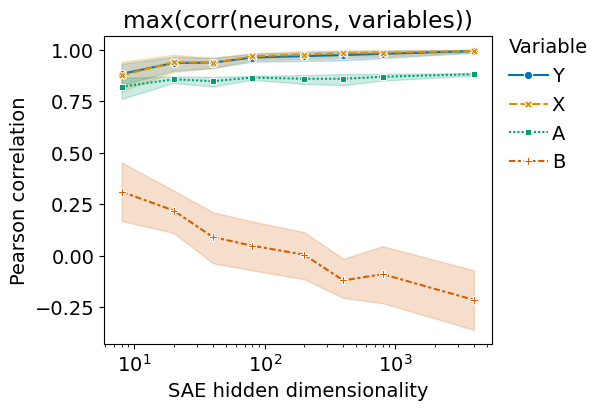

In [20]:
# a new line plot with 4 columns
# make the type categorical
df_sae_metrics['type'] = df_sae_metrics['type'].astype('category')
# set the order
df_sae_metrics['type'].cat.reorder_categories(['Vanilla', 'ReLU', 'TopK'], inplace=True)

variable_dict = {'highest_corrs_tf': 'X',
                'highest_corrs_rna': 'Y',
                'highest_corrs_activity': 'A',
                'highest_corrs_accessibility': 'B'}
df_corr_metrics = df_sae_metrics[['hidden_factor','type','n_activation_features']]
corr_columns = [c for c in df_sae_metrics.columns if 'corrs' in c]
for i,c in enumerate(corr_columns):
    if i == 0:
        df_corr_metrics = df_sae_metrics[['hidden_factor','type','n_activation_features']]
        df_corr_metrics['correlation'] = df_sae_metrics[c]
        df_corr_metrics['target'] = variable_dict[c]
    else:
        df_temp = df_sae_metrics[['hidden_factor','type','n_activation_features']]
        df_temp['correlation'] = df_sae_metrics[c]
        df_temp['target'] = variable_dict[c]
        df_corr_metrics = pd.concat([df_corr_metrics, df_temp], axis=0)

n_cols = 1

model_palette = ['grey','lightseagreen','darkorange']
variable_palette = sns.color_palette('colorblind', n_colors=4)
l1_palette = sns.color_palette('viridis_r', n_colors=len(l1_weight_options))
k_palette = sns.color_palette('rocket_r', n_colors=len(k_options))

# make the figure a grid of 2 rows and 4 columns
from matplotlib.gridspec import GridSpec
# set the font size
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(5, 4))
# add spacing
#fig.subplots_adjust(left=0.2, right=0.8)
gs = GridSpec(1, n_cols, figure=fig)


ax_list = []
"""
ax_list.append(fig.add_subplot(gs[0, 0]))
# plot the avg number of active units per variable
x = 'n_activation_features'
y = 'avg_active_hidden_units'
y_label = 'Avg N active units'
# make a line plot that scales linearly with x
x_unique = df_sae_metrics['hidden_factor'].unique()
ax_list[-1].plot(x_unique, x_unique, color='black', linestyle='--')
sns.lineplot(data=df_sae_metrics, x=x, y=y, ax=ax_list[-1], hue='type', style='type', markers=True, palette=model_palette)
ax_list[-1].set_xscale('log')
ax_list[-1].set_yscale('log')
ax_list[-1].set_title(y_label)
ax_list[-1].set_xlabel('Hidden units')
ax_list[-1].set_ylabel('N active units')
ax_list[-1].legend(loc='center left', bbox_to_anchor=(-0.1, -0.2), ncol=3, frameon=False, title='SAE type', handletextpad=0.2, alignment='left', columnspacing=0.8)
"""

ax_list.append(fig.add_subplot(gs[0, 0]))
x = 'n_activation_features'
y = 'correlation'
y_label = 'Pearson correlation'
hue = 'target'
sns.lineplot(data=df_corr_metrics, x=x, y=y, ax=ax_list[-1], hue=hue, style=hue, markers=True, palette=variable_palette)
ax_list[-1].set_xscale('log')
ax_list[-1].set_xlabel('SAE hidden dimensionality')
ax_list[-1].set_ylabel('Pearson correlation')
ax_list[-1].set_title('max(corr(neurons, variables))')
ax_list[-1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), ncol=1, frameon=False, title='Variable', handletextpad=0.2, alignment='left', columnspacing=0.8)

plt.show()
# export to pdf
fig.savefig('03_results/figures/sim_modl1l4_sae_recovery_metrics_a.pdf', bbox_inches='tight')

/tmp/ipykernel_3486766/2502087778.py:46: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_sae_metrics[df_sae_metrics['type'] == 'TopK'], x=x, y=y, ax=ax_list[-1], hue='k', style='k', markers=True, palette=k_palette)


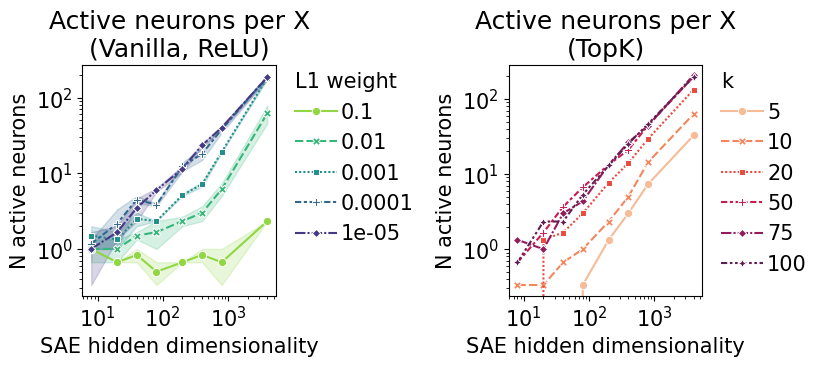

In [21]:
n_cols=2
# set the font size
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(8, 3))
# add spacing
fig.subplots_adjust(wspace=1.2, hspace=0.7)
gs = GridSpec(1, n_cols, figure=fig)


ax_list = []
"""
ax_list.append(fig.add_subplot(gs[0, 0]))
# plot the avg number of active units per variable
x = 'n_activation_features'
y = 'avg_active_hidden_units'
y_label = 'Avg N active units'
# make a line plot that scales linearly with x
x_unique = df_sae_metrics['hidden_factor'].unique()
ax_list[-1].plot(x_unique, x_unique, color='black', linestyle='--')
sns.lineplot(data=df_sae_metrics, x=x, y=y, ax=ax_list[-1], hue='type', style='type', markers=True, palette=model_palette)
ax_list[-1].set_xscale('log')
ax_list[-1].set_yscale('log')
ax_list[-1].set_title(y_label)
ax_list[-1].set_xlabel('Hidden units')
ax_list[-1].set_ylabel('N active units')
ax_list[-1].legend(loc='center left', bbox_to_anchor=(-0.1, -0.2), ncol=3, frameon=False, title='SAE type', handletextpad=0.2, alignment='left', columnspacing=0.8)
"""

ax_list.append(fig.add_subplot(gs[0, 0]))
# plot the number of active units per variable
x = 'n_activation_features'
y = 'n_per_tf'
y_label = 'Active neurons per X\n(Vanilla, ReLU)'
sns.lineplot(data=df_sae_metrics[df_sae_metrics['type'] != 'TopK'], x=x, y=y, ax=ax_list[-1], hue='l1_weight', style='l1_weight', markers=True, palette=l1_palette)
ax_list[-1].set_xscale('log')
ax_list[-1].set_yscale('log')
ax_list[-1].set_title(y_label)
ax_list[-1].set_xlabel('SAE hidden dimensionality')
ax_list[-1].set_ylabel('N active neurons')
ax_list[-1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), ncol=1, frameon=False, title='L1 weight', handletextpad=0.2, alignment='left', columnspacing=0.8)

ax_list.append(fig.add_subplot(gs[0, 1]))
#y = 'n_per_rna'
#y_label = 'N active units per Y'
y_label = 'Active neurons per X\n(TopK)'
sns.lineplot(data=df_sae_metrics[df_sae_metrics['type'] == 'TopK'], x=x, y=y, ax=ax_list[-1], hue='k', style='k', markers=True, palette=k_palette)
ax_list[-1].set_xscale('log')
ax_list[-1].set_yscale('log')
ax_list[-1].set_title(y_label)
ax_list[-1].set_xlabel('SAE hidden dimensionality')
ax_list[-1].set_ylabel('N active neurons')
ax_list[-1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), ncol=1, frameon=False, title='k', handletextpad=0.2, alignment='left', columnspacing=0.8)
#ax_list[-1].legend(loc='center left', bbox_to_anchor=(1.0, 1.0), ncol=1, frameon=False, title='SAE type', handletextpad=0.2, alignment='left', columnspacing=0.8)

plt.show()
# export to pdf
fig.savefig('03_results/figures/sim_modl1l4_sae_recovery_metrics_b.pdf', bbox_inches='tight')

Try to see if spearman corr was better

In [9]:
df_sae_metrics = pd.read_csv('03_results/reports/files/sim_modl1l4_sae-vanilla_metrics_spearman.csv')
# remove all rows with sparsity penalty > 0
df_sae_metrics = df_sae_metrics[df_sae_metrics['sparsity_penalty'] == 0.0]
df_sae_metrics['type'] = 'Vanilla'

df_sae_metrics_relu = pd.read_csv('03_results/reports/files/sim_modl1l4_sae-bricken2_metrics_spearman.csv')
df_sae_metrics_relu['type'] = 'ReLU'
df_sae_metrics = pd.concat([df_sae_metrics, df_sae_metrics_relu])

df_sae_metrics_topk = pd.read_csv('03_results/reports/files/sim_modl1l4_sae-topk_metrics_spearman.csv')
df_sae_metrics_topk['type'] = 'TopK'
df_sae_metrics = pd.concat([df_sae_metrics, df_sae_metrics_topk])

# mods
df_sae_metrics['k'] = df_sae_metrics['k'].fillna(0)
df_sae_metrics['k'] = df_sae_metrics['k'].astype(int)
df_sae_metrics['k'] = df_sae_metrics['k'].astype(str)
df_sae_metrics = df_sae_metrics[df_sae_metrics['k'] != '1']
df_sae_metrics['l1_weight'] = df_sae_metrics['l1_weight'].astype(str)
df_sae_metrics['fraction_unique'] = df_sae_metrics['n_unique'] / df_sae_metrics['n_activation_features']
df_sae_metrics['fraction_dead'] = 1 - df_sae_metrics['fraction_unique']

hidden_factor_options = [2, 5, 10, 20, 50, 100, 200, 1000]
lr_options = [1e-2, 1e-3, 1e-4, 1e-5]
l1_weight_options = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
k_options = [1, 5, 10, 20, 50, 75, 100]

df_sae_metrics = df_sae_metrics[df_sae_metrics['lr'] == 1e-4]

In [12]:
df_sae_metrics

hidden_factor      lr l1_weight  sparsity_penalty      loss  \
0               2  0.0001       0.1                 0  0.011881   
1               2  0.0001      0.01                 0  0.001542   
2               2  0.0001     0.001                 0  0.000382   
3               2  0.0001    0.0001                 0  0.000112   
4               2  0.0001     1e-05                 0  0.000012   
..            ...     ...       ...               ...       ...   
51           1000  0.0001       nan                 0  0.000063   
52           1000  0.0001       nan                 0  0.000056   
53           1000  0.0001       nan                 0  0.000480   
54           1000  0.0001       nan                 0  0.000075   
55           1000  0.0001       nan                 0  0.000372   

    n_activation_features  n_unique  avg_active_hidden_units  n_redundant  \
0                       8         5                 1.779583            0   
1                       8         6                 2.301167            0   
2                       8         6                 2.605083            1   
3                       8         7                 5.203500            5   
4                       8         7                 5.338917            2   
..                    ...       ...                      ...          ...   
51                   4000      1324               400.000000         1285   
52                   4000      2269               800.000000         2235   
53                   4000      3449              1876.827833         3402   
54                   4000      3467              1876.749167         3421   
55                   4000      3412              1854.579500         3371   

    n_per_rna  ...  n_per_activity  n_per_accessibility  highest_corrs_rna  \
0         0.8  ...             0.0                  0.0           0.970958   
1         0.4  ...             0.0                  0.0           0.260725   
2         1.2  ...             0.0                  0.0           0.985177   
3         1.2  ...             0.0                  0.0           0.860656   
4         1.0  ...             0.0                  0.0           0.840120   
..        ...  ...             ...                  ...                ...   
51       84.8  ...             0.0                  0.0           0.993656   
52      169.6  ...             0.0                  0.0           0.994151   
53      294.2  ...             0.0                  0.0           0.994165   
54      283.6  ...             0.0                  0.0           0.994165   
55      289.8  ...             0.0                  0.0           0.994132   

    highest_corrs_tf  highest_corrs_activity  highest_corrs_accessibility  \
0           0.990783                0.864269                     0.369484   
1           0.395088                0.662276                     0.392827   
2           0.986760                0.841781                     0.408202   
3           0.788708                0.837387                     0.533582   
4           0.761666                0.858447                     0.532538   
..               ...                     ...                          ...   
51          0.994904                0.861127                    -0.211947   
52          0.994917                0.869764                    -0.211947   
53          0.994917                0.870435                    -0.211947   
54          0.994917                0.870435                    -0.211947   
55          0.994861                0.869764                    -0.211947   

       type  k fraction_unique  fraction_dead  
0   Vanilla  0         0.62500        0.37500  
1   Vanilla  0         0.75000        0.25000  
2   Vanilla  0         0.75000        0.25000  
3   Vanilla  0         0.87500        0.12500  
4   Vanilla  0         0.87500        0.12500  
..      ... ..             ...            ...  
51     TopK  0         0.33100        0.66900  
52     TopK  0         0.567

/tmp/ipykernel_3486766/1134924040.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_sae_metrics['type'].cat.reorder_categories(['Vanilla', 'ReLU', 'TopK'], inplace=True)
/tmp/ipykernel_3486766/1134924040.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_metrics['correlation'] = df_sae_metrics[c]
/tmp/ipykernel_3486766/1134924040.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

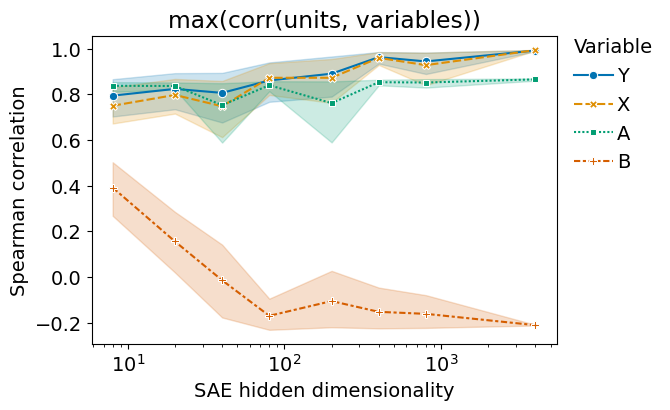

In [14]:
# a new line plot with 4 columns
# make the type categorical
df_sae_metrics['type'] = df_sae_metrics['type'].astype('category')
# set the order
df_sae_metrics['type'].cat.reorder_categories(['Vanilla', 'ReLU', 'TopK'], inplace=True)

variable_dict = {'highest_corrs_tf': 'X',
                'highest_corrs_rna': 'Y',
                'highest_corrs_activity': 'A',
                'highest_corrs_accessibility': 'B'}
df_corr_metrics = df_sae_metrics[['hidden_factor','type','n_activation_features']]
corr_columns = [c for c in df_sae_metrics.columns if 'corrs' in c]
for i,c in enumerate(corr_columns):
    if i == 0:
        df_corr_metrics = df_sae_metrics[['hidden_factor','type','n_activation_features']]
        df_corr_metrics['correlation'] = df_sae_metrics[c]
        df_corr_metrics['target'] = variable_dict[c]
    else:
        df_temp = df_sae_metrics[['hidden_factor','type','n_activation_features']]
        df_temp['correlation'] = df_sae_metrics[c]
        df_temp['target'] = variable_dict[c]
        df_corr_metrics = pd.concat([df_corr_metrics, df_temp], axis=0)

n_cols = 1

model_palette = ['grey','lightseagreen','darkorange']
variable_palette = sns.color_palette('colorblind', n_colors=4)
l1_palette = sns.color_palette('viridis_r', n_colors=len(l1_weight_options))
k_palette = sns.color_palette('rocket_r', n_colors=len(k_options))

# make the figure a grid of 2 rows and 4 columns
from matplotlib.gridspec import GridSpec
# set the font size
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(6, 4))
# add spacing
#fig.subplots_adjust(left=0.2, right=0.8)
gs = GridSpec(1, n_cols, figure=fig)


ax_list = []
"""
ax_list.append(fig.add_subplot(gs[0, 0]))
# plot the avg number of active units per variable
x = 'n_activation_features'
y = 'avg_active_hidden_units'
y_label = 'Avg N active units'
# make a line plot that scales linearly with x
x_unique = df_sae_metrics['hidden_factor'].unique()
ax_list[-1].plot(x_unique, x_unique, color='black', linestyle='--')
sns.lineplot(data=df_sae_metrics, x=x, y=y, ax=ax_list[-1], hue='type', style='type', markers=True, palette=model_palette)
ax_list[-1].set_xscale('log')
ax_list[-1].set_yscale('log')
ax_list[-1].set_title(y_label)
ax_list[-1].set_xlabel('Hidden units')
ax_list[-1].set_ylabel('N active units')
ax_list[-1].legend(loc='center left', bbox_to_anchor=(-0.1, -0.2), ncol=3, frameon=False, title='SAE type', handletextpad=0.2, alignment='left', columnspacing=0.8)
"""

ax_list.append(fig.add_subplot(gs[0, 0]))
x = 'n_activation_features'
y = 'correlation'
y_label = 'Pearson correlation'
hue = 'target'
sns.lineplot(data=df_corr_metrics, x=x, y=y, ax=ax_list[-1], hue=hue, style=hue, markers=True, palette=variable_palette)
ax_list[-1].set_xscale('log')
ax_list[-1].set_xlabel('SAE hidden dimensionality')
ax_list[-1].set_ylabel('Spearman correlation')
ax_list[-1].set_title('max(corr(units, variables))')
ax_list[-1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), ncol=1, frameon=False, title='Variable', handletextpad=0.2, alignment='left', columnspacing=0.8)

plt.show()
# export to pdf
fig.savefig('03_results/figures/sim_modl1l4_sae_recovery_metrics_a_spearman.pdf', bbox_inches='tight')